# <span style='color:brown'> Vietnam Daily Weather Analysis & Forecasting

## <span style='color:blue'> Step 2 · Data Understanding

This notebook follows the requested workflow:
- explain every column and inspect value distributions;
- visualise the temperature target (Hanoi proxy) across the available timeframe;
- study relationships between variables before modelling.

> **Note:** The raw file contains Ho Chi Minh City observations; we use it as a proxy for Hanoi because the shared data folder only includes this feed. The engineering steps stay identical for Hanoi data once available.

In [4]:
import warnings
import math
import random
from collections import OrderedDict
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Add src to path - FUNCTIONS IMPORTED FROM src/ AND scripts/
sys.path.append(str(Path.cwd() / 'src'))
sys.path.append(str(Path.cwd() / 'scripts'))

# Import reusable functions from src/
from feature_engineering import prepare_supervised_dataset, prepare_features_hourly
from preprocessing import build_preprocessor, make_pipeline, ModTimeSeriesSplit, identify_column_types, to_dense
from model_training import compute_metrics, cross_val_evaluate, aggregate_metrics
from answer_helper import helper_step1
from analyse_helper import analyze_model_comprehensive, compare_optuna_performance
from plot_helper import base_model_plot, final_summary
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme(style='darkgrid')

print(" Functions imported from src")

 Functions imported from src


In [5]:
DATA_PATH = "data/weather_hcm_daily.csv"
df_raw = pd.read_csv(DATA_PATH)
print(f'Dataset shape: {df_raw.shape}')
print(f"Sampling period: {df_raw['datetime'].min()} ? {df_raw['datetime'].max()} ({df_raw.shape[0]} days)")
display(df_raw.head())

Dataset shape: (3927, 38)
Sampling period: 2015-01-01 ? 2025-10-01 (3927 days)


name           address        resolvedAddress  latitude  \
0  Hồ Chí Minh city  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
1  Hồ Chí Minh city  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
2  Hồ Chí Minh city  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
3  Hồ Chí Minh city  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
4  Hồ Chí Minh city  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   

   longitude    datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0    106.701  2015-01-01     31.0     23.0  26.6          31.4          23.0   
1    106.701  2015-01-02     30.0     20.0  25.0          30.4          20.0   
2    106.701  2015-01-03     32.0     23.0  26.8          33.5          23.0   
3    106.701  2015-01-04     32.0     24.0  27.1          34.8          24.0   
4    106.701  2015-01-05     30.6     24.9  26.7          33.2          24.9   

   feelslike   dew  humidity  precip  precipprob  precipcover preciptype  \
0       26.8  17.9      60.3     0.0           0         0.00        NaN   
1       25.1  15.8      57.2     0.0           0         0.00        NaN   
2       27.4  19.0      63.7     0.2         100         8.33       rain   
3       28.3  21.3      71.7     0.0           0         0.00        NaN   
4       27.7  22.1      76.4     6.0         100         4.17       rain   

   windgust  windspeed  windspeedmax  windspeedmean  windspeedmin  winddir  \
0      20.5       15.4          15.4            7.9           2.9     27.3   
1      21.6       13.0          13.0            7.2           2.9    331.6   
2      23.8       11.2          11.2            7.8           1.8      9.5   
3      22.7       10.8          10.8            6.3           2.9    237.4   
4      24.8       11.6          11.6            5.5           1.1    168.5   

   sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  \
0            1012.5        53.8         8.9           230.6         19.9   
1            1013.0        66.3        10.2           186.2         16.1   
2            1012.0        52.7         9.8           185.8         16.0   
3            1010.2        59.3         8.4           125.8         10.9   
4            1010.0        78.0         9.1           163.4         14.1   

   uvindex  severerisk              sunrise               sunset  moonphase  \
0        8         NaN  2015-01-01T06:11:22  2015-01-01T17:41:39       0.36   
1        7         NaN  2015-01-02T06:11:46  2015-01-02T17:42:12       0.39   
2        8         NaN  2015-01-03T06:12:09  2015-01-03T17:42:44       0.43   
3        4         NaN  2015-01-04T06:12:32  2015-01-04T17:43:17       0.46   
4        8         NaN  2015-01-05T06:12:54  2015-01-05T17:43:50       0.50   

               conditions                                        description  \
0        Partially cloudy                  Partly cloudy throughout the day.   
1        Partially cloudy                  Partly cloudy throughout the day.   
2  Rain, Partially cloudy  Partly cloudy throughout the day with rain in ...   
3        Partially cloudy                  Partly cloudy throughout the day.   
4  Rain, Partially cloudy  Partly cloudy throughout the day with morning ...   

                icon source  
0  partly-cloudy-day    obs  
1  partly-cloudy-day    obs  
2               rain    obs  
3  partly-cloudy-day    obs  
4               rain    obs

In [6]:
helper_step1(df_raw)

column    dtype  missing  unique  \
0               name   object        0       1   
1            address   object        0       1   
2    resolvedAddress   object        0       1   
3           latitude  float64        0       1   
4          longitude  float64        0       1   
5           datetime   object        0    3927   
6            tempmax  float64        0      99   
7            tempmin  float64        0      82   
8               temp  float64        0      92   
9       feelslikemax  float64        0     180   
10      feelslikemin  float64        0     138   
11         feelslike  float64        0     174   
12               dew  float64        0     126   
13          humidity  float64        0     450   
14            precip  float64        0     330   
15        precipprob    int64        0       2   
16       precipcover  float64        0      25   
17        preciptype   object      924       1   
18          windgust  float64        0     143   
19         windspeed  float64        0     251   
20      windspeedmax  float64        0     251   
21     windspeedmean  float64        0     179   
22      windspeedmin  float64        0     100   
23           winddir  float64        0    2068   
24  sealevelpressure  float64        0     128   
25        cloudcover  float64        0     659   
26        visibility  float64        0      58   
27    solarradiation  float64        0    1631   
28       solarenergy  float64        0     229   
29           uvindex    int64        0      11   
30        severerisk  float64     2731       5   
31           sunrise   object        0    3927   
32            sunset   object        0    3927   
33         moonphase  float64        0      96   
34        conditions   object        0       4   
35       description   object        0      26   
36              icon   object        0       3   
37            source   object        0       1   

                                        sample_values  \
0                                  [Hồ Chí Minh city]   
1                                  [Hồ Chí Minh city]   
2                             [Hồ Chí Minh, Việt Nam]   
3                                            [10.776]   
4                                           [106.701]   
5   [2015-01-01, 2015-01-02, 2015-01-03, 2015-01-0...   
6                      [31.0, 30.0, 32.0, 30.6, 31.9]   
7                      [23.0, 20.0, 24.0, 24.9, 23.4]   
8                      [26.6, 25.0, 26.8, 27.1, 26.7]   
9                      [31.4, 30.4, 33.5, 34.8, 33.2]   
10                     [23.0, 20.0, 24.0, 24.9, 23.4]   
11                     [26.8, 25.1, 27.4, 28.3, 27.7]   
12                     [17.9, 15.8, 19.0, 21.3, 22.1]   
13                     [60.3, 57.2, 63.7, 71.7, 76.4]   
14                          [0.0, 0.2, 6.0, 9.0, 0.6]   
15                                           [0, 100]   
16                     [0.0, 8.33, 4.17, 16.67, 12.5]   
17                                             [rain]   
18                     [20.5, 21.6, 23.8, 22.7, 24.8]   
19                     [15.4, 13.0, 11.2, 10.8, 11.6]   
20                     [15.4, 13.0, 11.2, 10.8, 11.6]   
21                          [7.9, 7.2, 7.8, 6.3, 5.5]   
22                          [2.9, 1.8, 1.1, 0.7, 0.0]   
23                   [27.3, 331.6, 9.5, 237.4, 168.5]   
24           [1012.5, 1013.0, 1012.0, 1010.2, 1010.0]   
25                     [53.8, 66.3, 52.7, 59.3, 78.0]   
26                         [8.9, 10.2, 9.8, 8.4, 9.1]   
27                [230.6, 186.2, 185.8, 125.8, 163.4]   
28                     [19.9, 16.1, 16.0, 10.9, 14.1]   
29                                   [8, 7, 4, 9, 10]   
30                      [30.0, 60.0, 75.0, 10.0, 5.0]   
31  [2015-01-01T06:11:22, 2015-01-02T06:11:46, 201...   
32  [2015-01-01T17:41:39, 2015-01-02T17:42:12, 201...   
33                      [0.36, 0.39, 0.43, 0.46, 0.5]   
34  [Partially cloudy, Rain, Partially cloudy, Cle...   
35  [Partly

Total columns documented: 38


### What does moonphase mean?

- moonphase is a normalised lunar cycle indicator ranging from 0.0 (new moon) ? 0.5 (full moon) ? 1.0 (next new moon).
- Textual columns (conditions, description, icon, preciptype) encode qualitative summaries that we later vectorise for modelling.

### <span style='color:blue'> Step 2.5 · Feature Hypothesis & Exploration

Before diving into modeling, we explore key features based on domain knowledge and correlation analysis. This helps identify which features are worth keeping and which might be redundant or noisy.

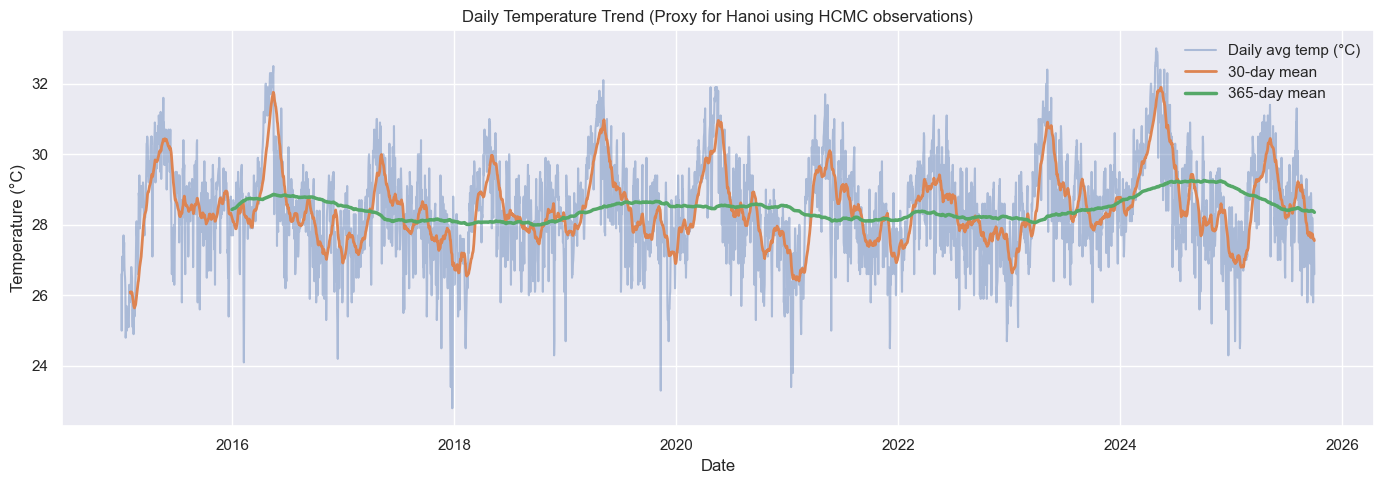

In [7]:
df_time = df_raw.copy()
df_time['datetime'] = pd.to_datetime(df_time['datetime'])
df_time = df_time.sort_values('datetime')
df_time['temp_ma30'] = df_time['temp'].rolling(30).mean()
df_time['temp_ma365'] = df_time['temp'].rolling(365).mean()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df_time['datetime'], df_time['temp'], label='Daily avg temp (°C)', alpha=0.4)
ax.plot(df_time['datetime'], df_time['temp_ma30'], label='30-day mean', linewidth=2)
ax.plot(df_time['datetime'], df_time['temp_ma365'], label='365-day mean', linewidth=2.5)
ax.set_title('Daily Temperature Trend (Proxy for Hanoi using HCMC observations)')
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Date')
ax.legend()
plt.tight_layout()

In [8]:
# Feature Hypothesis & Exploration
# Identify features worth exploring and those to remove based on simple correlation scores

print("="*80)
print("FEATURE HYPOTHESIS & EXPLORATION")
print("="*80)

# Get correlation with target
numeric_cols = df_time.select_dtypes(include=np.number).columns.tolist()
corr_matrix = df_time[numeric_cols].corr()
corr_with_temp = corr_matrix['temp'].sort_values(ascending=False)

# Categorize features by correlation strength
strong_features = corr_with_temp[corr_with_temp.abs() > 0.7].drop('temp')
moderate_features = corr_with_temp[(corr_with_temp.abs() > 0.3) & (corr_with_temp.abs() <= 0.7)]
weak_features = corr_with_temp[corr_with_temp.abs() <= 0.3]

print(f"\n✓ STRONG SIGNALS (|corr| > 0.7): {len(strong_features)}")
print(strong_features.to_string())
print(f"\n~ MODERATE SIGNALS (0.3 < |corr| ≤ 0.7): {len(moderate_features)}")  
print(moderate_features.to_string())
print(f"\n✗ WEAK/NOISY SIGNALS (|corr| ≤ 0.3): {len(weak_features)}")
print(weak_features.to_string())
print("\n" + "="*80)

FEATURE HYPOTHESIS & EXPLORATION

✓ STRONG SIGNALS (|corr| > 0.7): 4
feelslike       0.893183
tempmax         0.847479
tempmin         0.792170
feelslikemin    0.770885

~ MODERATE SIGNALS (0.3 < |corr| ≤ 0.7): 8
temp_ma30         0.658027
feelslikemax      0.633797
solarradiation    0.579843
solarenergy       0.578870
uvindex           0.471194
visibility        0.420761
cloudcover       -0.307563
humidity         -0.339675

✗ WEAK/NOISY SIGNALS (|corr| ≤ 0.3): 14
windspeedmean       0.280446
windspeedmin        0.269430
dew                 0.260570
temp_ma365          0.152633
severerisk          0.100555
windspeed           0.077646
windspeedmax        0.077646
precipprob          0.034154
precipcover         0.023565
moonphase           0.015321
windgust           -0.015512
winddir            -0.087161
sealevelpressure   -0.128316
precip             -0.221646



### Temperature behaviour (2015–2025)

- Daily average temperature stays between roughly 24–30?°C with minor inter-annual variation.
- Wet-season months (May–October) drive the recurring dips seen in the rolling averages.
- No strong long-term warming or cooling trend is evident, although variability increases during monsoon periods.

Correlation_with_temp
temp                         1.000000
feelslike                    0.893183
tempmax                      0.847479
tempmin                      0.792170
feelslikemin                 0.770885
temp_ma30                    0.658027
feelslikemax                 0.633797
solarradiation               0.579843
solarenergy                  0.578870
uvindex                      0.471194
visibility                   0.420761
windspeedmean                0.280446
windspeedmin                 0.269430
dew                          0.260570
temp_ma365                   0.152633

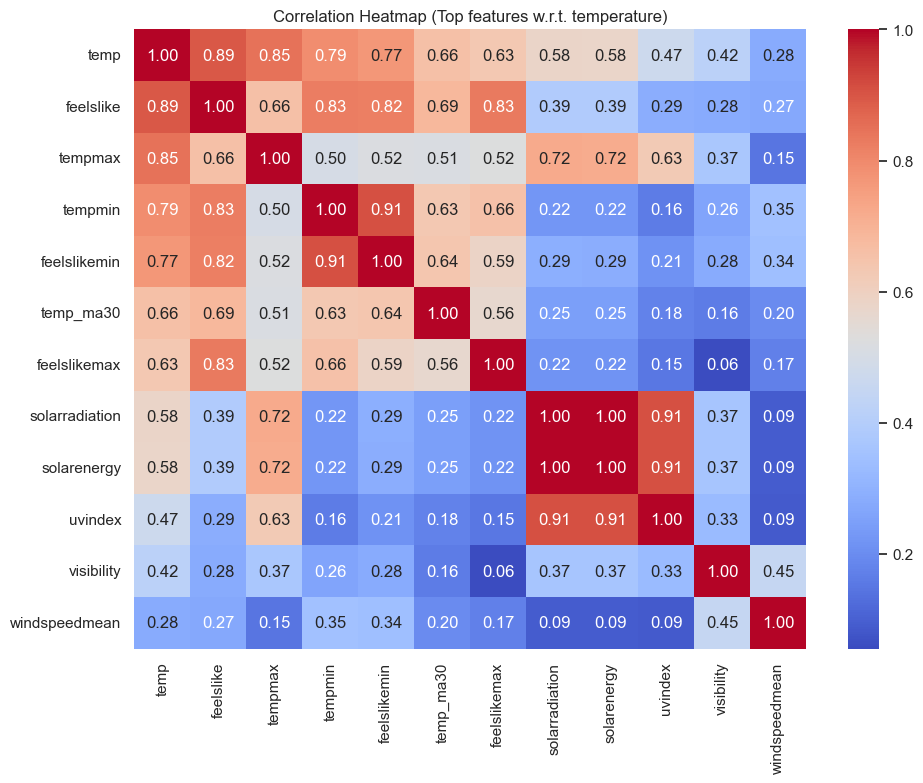

In [9]:
numeric_cols = df_time.select_dtypes(include=np.number).columns.tolist()
corr_matrix = df_time[numeric_cols].corr()
corr_target = corr_matrix['temp'].sort_values(ascending=False)
top_features = corr_target.index[:12].tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap (Top features w.r.t. temperature)')
plt.tight_layout()

corr_target_df = corr_target.to_frame(name='Correlation_with_temp')
display(corr_target_df.head(15))

## <span style='color:blue'> Step 3 · Data Processing

In [10]:
missing_summary = df_raw.isna().sum().sort_values(ascending=False)
missing_focus = missing_summary[missing_summary > 0]
print('Missing values focus:')
display(missing_focus.to_frame('count'))

feature_types = {
    'numeric': df_raw.select_dtypes(include=[np.number]).columns.tolist(),
    'categorical_or_text': df_raw.select_dtypes(include=['object']).columns.tolist()
}
print(f"Numeric features: {len(feature_types['numeric'])}")
print(f"Categorical/text features: {len(feature_types['categorical_or_text'])}")
print('Examples (numeric):', feature_types['numeric'][:10])
print('Examples (categorical/text):', feature_types['categorical_or_text'][:10])

Missing values focus:


count
severerisk   2731
preciptype    924

Numeric features: 27
Categorical/text features: 11
Examples (numeric): ['latitude', 'longitude', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity']
Examples (categorical/text): ['name', 'address', 'resolvedAddress', 'datetime', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon']


## <span style='color:blue'> Step 4 · Feature Engineering

Goal: transform the daily weather log into a supervised dataset that predicts the next five days of average temperature (	emp). We generate calendar features, lags, rolling statistics, and textual embeddings so that any ML model (linear ? deep) can ingest the data.

In [11]:
# Configuration for feature engineering
HORIZONS = [1, 2, 3, 4, 5]
LAG_VALUES = [1, 2, 3, 7, 14]
ROLLING_WINDOWS = [3, 7, 14]
SEQUENCE_LENGTH = 30

print("Using prepare_supervised_dataset from src/feature_engineering.py")

Using prepare_supervised_dataset from src/feature_engineering.py


In [12]:
feature_df, target_df, target_cols, sequence_package = prepare_supervised_dataset(df_raw, horizons=HORIZONS, lag_values=LAG_VALUES, rolling_windows=ROLLING_WINDOWS, sequence_length=SEQUENCE_LENGTH)
print(f'Engineered feature matrix shape: {feature_df.shape}')
print(f'Target matrix shape: {target_df.shape}')
print('Target horizons:', target_cols)
display(feature_df.head())
display(target_df.head())

Engineered feature matrix shape: (3892, 182)
Target matrix shape: (3892, 6)
Target horizons: ['target_temp_t+1', 'target_temp_t+2', 'target_temp_t+3', 'target_temp_t+4', 'target_temp_t+5']


row_id   datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0      30 2015-01-31     31.6     21.0  25.9          31.2          21.0   
1      31 2015-02-01     33.0     19.4  26.2          31.7          19.4   
2      32 2015-02-02     33.6     20.0  26.8          32.9          20.0   
3      33 2015-02-03     33.0     22.6  26.8          33.0          22.6   
4      34 2015-02-04     33.0     22.0  26.6          32.4          22.0   

   feelslike   dew  humidity  precip  precipprob  precipcover preciptype  \
0       25.9  16.7      58.9     0.0           0          0.0       none   
1       25.9  15.7      56.0     0.0           0          0.0       none   
2       26.8  17.2      59.1     0.0           0          0.0       none   
3       27.1  18.6      63.0     0.0           0          0.0       none   
4       26.6  17.8      60.8     0.0           0          0.0       none   

   windgust  windspeed  windspeedmax  windspeedmean  windspeedmin  winddir  \
0      28.1       16.2          16.2            7.3           2.9    151.7   
1      38.9       19.6          19.6            9.6           3.3     87.8   
2      37.1       13.0          13.0            7.1           0.7    112.8   
3      31.3       18.4          18.4            8.7           2.1    137.6   
4      32.4       18.4          18.4            7.9           1.5    107.4   

   sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  \
0            1013.9        36.8         9.7           268.1         23.2   
1            1013.7        26.4         9.8           258.3         22.3   
2            1014.1        32.2         9.4           264.9         22.8   
3            1014.9        40.4         9.2           241.2         20.8   
4            1014.2        51.5        10.5           254.6         21.9   

   uvindex  severerisk  moonphase        conditions  \
0        9         0.0       0.37  Partially cloudy   
1        9         0.0       0.40  Partially cloudy   
2        9         0.0       0.44  Partially cloudy   
3        9         0.0       0.47  Partially cloudy   
4        9         0.0       0.50  Partially cloudy   

                         description               icon  sunrise_minutes  \
0         Clearing in the afternoon.  partly-cloudy-day              376   
1  Partly cloudy throughout the day.  partly-cloudy-day              376   
2  Partly cloudy throughout the day.  partly-cloudy-day              376   
3  Partly cloudy throughout the day.  partly-cloudy-day              376   
4  Partly cloudy throughout the day.  partly-cloudy-day              376   

   sunset_minutes  day_length_minutes  day_of_year  month  year  day_of_week  \
0            1076          699.650000           31      1  2015            5   
1            1076          700.100000           32      2  2015            6   
2            1077          700.566667           33      2  2015            0   
3            1077          701.050000           34      2  2015            1   
4            1077          701.533333           35      2  2015            2   

   sin_day_of_year  cos_day_of_year  sin_month  cos_month  temp_diff_1  \
0         0.507415         0.861702   0.500000   0.866025         -0.1   
1         0.522133         0.852864   0.866025   0.500000          0.3   
2         0.536696         0.843776   0.866025   0.500000          0.6   
3         0.551102         0.834438   0.866025   0.500000          0.0   
4         0.565345         0.824855   0.866025   0.500000         -0.2   

   temp_diff_7  temp_lag_1  tempmax_lag_1  tempmin_lag_1  feelslikemax_lag_1  \
0          0.8        26.0           33.0           22.0                34.3   
1          1.1        25.9           31.6           21.0                31.2   
2          1.3        26.2           33.0           19.4                31.7   
3          0.5        26.8           33.6           20.0                32.9   
4          0.8        26.8           33.0        

row_id  target_temp_t+1  target_temp_t+2  target_temp_t+3  target_temp_t+4  \
0      30             26.2             26.8             26.8             26.6   
1      31             26.8             26.8             26.6             26.5   
2      32             26.8             26.6             26.5             25.4   
3      33             26.6             26.5             25.4             25.1   
4      34             26.5             25.4             25.1             25.6   

   target_temp_t+5  
0             26.5  
1             25.4  
2             25.1  
3             25.6  
4             25.4

## <span style='color:blue'>Step 5 · Modelling & Hyper-Parameter Tuning

We follow the requested line-up: naive & statistical baselines, linear and robust regressors, tree/gradient ensembles, Optuna tuning, a seq2seq LSTM, and a simple hybrid ensemble.

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from tqdm.auto import tqdm
import optuna

split_idx = int(len(feature_df) * 0.85)

dates = feature_df['datetime'].reset_index(drop=True)
X = feature_df.drop(columns=['datetime'])
y = target_df[target_cols]

split_idx = int(len(feature_df) * 0.85)
LEAKAGE_BUFFER = 14  # Maximum lag/rolling window size

dates = feature_df['datetime'].reset_index(drop=True)
X = feature_df.drop(columns=['datetime'])
y = target_df[target_cols]

X_train = X.iloc[:split_idx].reset_index(drop=True)
# Remove first LEAKAGE_BUFFER rows from test set
X_test = X.iloc[split_idx + LEAKAGE_BUFFER:].reset_index(drop=True)
y_train = y.iloc[:split_idx].reset_index(drop=True)
y_test = y.iloc[split_idx + LEAKAGE_BUFFER:].reset_index(drop=True)
train_dates = dates.iloc[:split_idx].reset_index(drop=True)
test_dates = dates.iloc[split_idx + LEAKAGE_BUFFER:].reset_index(drop=True)


text_cols = ['description']
categorical_cols = ['preciptype', 'conditions', 'icon']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols + text_cols]

# Note: ModTimeSeriesSplit, build_preprocessor, make_pipeline, compute_metrics, 
# cross_val_evaluate, and aggregate_metrics are imported from src/preprocessing.py 
# and src/model_training.py (see first cell)

tscv = ModTimeSeriesSplit(n_splits=5, buffer=LEAKAGE_BUFFER)


print(f'Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}')
print(f'Numeric features: {len(numeric_cols)}, categorical: {len(categorical_cols)}, text: {text_cols}')


model_results = {}

Train samples: 3308, Test samples: 570
Numeric features: 177, categorical: 3, text: ['description']


### **<span style='color:brown'> Modelling**

> **Note:** You can use the model analysis function above, use 'analyze_model_comprehensive' to use print all the analysis at one (except optuna). But you should use function below the 'analyze_model_comprehensive' to print the result one by one for better visualization. You can use other function or plot that you define yourself, just make sure it look nice!

> **Here is one example how to use it** analyze_model_comprehensive('LinearRegression', model_results, X_train, X_test, y_train, y_test, test_dates, HORIZONS)

### **5.1. Naive Baseline**

In [14]:
def persistence_baseline(temp_series):
    return np.repeat(temp_series.reshape(-1, 1), len(HORIZONS), axis=1)

naive_train_preds = persistence_baseline(X_train['temp'].values)
naive_test_preds = persistence_baseline(X_test['temp'].values)
model_results['NaivePersistence'] = {
    'train_metrics': compute_metrics(y_train.values, naive_train_preds, HORIZONS),
    'test_metrics': compute_metrics(y_test.values, naive_test_preds, HORIZONS),
    'cv_metrics': None,
    'predictions_test': naive_test_preds,
    'predictions_train': naive_train_preds,
    'details': 'Copies latest observed temperature across all future horizons.'
}
print('Naive baseline metrics:')
display(pd.Series(model_results['NaivePersistence']['test_metrics']).to_frame('NaivePersistence').T)


Naive baseline metrics:


RMSE_h1    MAE_h1   MAPE_h1     R2_h1   RMSE_h2    MAE_h2  \
NaivePersistence  0.892523  0.690526  2.426897  0.681809  1.176532  0.925789   

                   MAPE_h2     R2_h2   RMSE_h3    MAE_h3   MAPE_h3    R2_h3  \
NaivePersistence  3.254859  0.448555  1.296114  1.020877  3.579254  0.33155   

                   RMSE_h4    MAE_h4   MAPE_h4     R2_h4   RMSE_h5    MAE_h5  \
NaivePersistence  1.349386  1.070877  3.749654  0.275709  1.333121  1.072807   

                   MAPE_h5     R2_h5  RMSE_macro  MAE_macro  MAPE_macro  \
NaivePersistence  3.754028  0.294746    1.209535   0.956175    3.352939   

                  R2_macro  
NaivePersistence  0.406474

### **5.2. Train and compute metrics of 5 basic models**

In [15]:
estimators = {
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'RandomForestRegressor': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)),
    'HistGradientBoosting': MultiOutputRegressor(HistGradientBoostingRegressor(max_iter=100, random_state=RANDOM_STATE)),
    'HuberRegressor': MultiOutputRegressor(HuberRegressor()),
    'BayesianRidge': MultiOutputRegressor(BayesianRidge()),
}
warnings.filterwarnings('ignore', category=UserWarning)
for name, estimator in tqdm(estimators.items(), desc='Training ML models'):
    pipeline = make_pipeline(estimator = estimator, numeric_cols=numeric_cols,
                             categorical_cols=categorical_cols, text_cols=text_cols)
    cv_metrics = aggregate_metrics(cross_val_evaluate(pipeline, X_train, y_train, tscv, HORIZONS))
    pipeline.fit(X_train, y_train)
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)
    model_results[name] = {
        'pipeline': pipeline,
        'cv_metrics': cv_metrics,
        'train_metrics': compute_metrics(y_train.values, train_pred, HORIZONS),
        'test_metrics': compute_metrics(y_test.values, test_pred, HORIZONS),
        'predictions_test': test_pred,
        'predictions_train': train_pred,
        'details': 'Sklearn pipeline with preprocessing.'
    }
    print(f"{name} cv RMSE_macro: {model_results[name]['cv_metrics']}")

Training ML models:  20%|██        | 1/5 [00:07<00:31,  7.88s/it]

LinearRegression cv RMSE_macro: {'RMSE_h1': 0.9145549127992249, 'MAE_h1': 0.6732779871544885, 'MAPE_h1': 2.3946287524018492, 'R2_h1': 0.4523244160276724, 'RMSE_h2': 1.2310963600538272, 'MAE_h2': 0.8776471764580028, 'MAPE_h2': 3.1322778590962916, 'R2_h2': -0.022645036211533177, 'RMSE_h3': 1.1853722238483426, 'MAE_h3': 0.9194876660728223, 'MAPE_h3': 3.2821153871510846, 'R2_h3': 0.10279637475574958, 'RMSE_h4': 1.4740352677402881, 'MAE_h4': 0.9599202884487511, 'MAPE_h4': 3.4273625309849542, 'R2_h4': -0.5982807892084664, 'RMSE_h5': 1.4216788621961753, 'MAE_h5': 0.9858912334511603, 'MAPE_h5': 3.519048409082908, 'R2_h5': -0.389811927185157, 'RMSE_macro': 1.2453475253275716, 'MAE_macro': 0.8832448703170449, 'MAPE_macro': 3.1510865877434178, 'R2_macro': -0.09112339236434688}


Training ML models:  40%|████      | 2/5 [01:25<02:26, 48.73s/it]

RandomForestRegressor cv RMSE_macro: {'RMSE_h1': 0.7858528549735698, 'MAE_h1': 0.6112878957169461, 'MAPE_h1': 2.1751475451278184, 'R2_h1': 0.6101977398440033, 'RMSE_h2': 0.9797590990555536, 'MAE_h2': 0.7768182495344507, 'MAPE_h2': 2.764411650137382, 'R2_h2': 0.39551092733042753, 'RMSE_h3': 1.0672070438526993, 'MAE_h3': 0.8498271880819365, 'MAPE_h3': 3.02510506430926, 'R2_h3': 0.28203425386492925, 'RMSE_h4': 1.1067195642889813, 'MAE_h4': 0.8813664804469269, 'MAPE_h4': 3.1371414650712763, 'R2_h4': 0.2291147756698865, 'RMSE_h5': 1.1260586506808195, 'MAE_h5': 0.9000108007448787, 'MAPE_h5': 3.200843488337552, 'R2_h5': 0.20284669278771367, 'RMSE_macro': 1.0131194425703245, 'MAE_macro': 0.8038621229050278, 'MAPE_macro': 2.860529842596658, 'R2_macro': 0.34394087789939204}


Training ML models:  60%|██████    | 3/5 [02:00<01:24, 42.39s/it]

HistGradientBoosting cv RMSE_macro: {'RMSE_h1': 0.789185046945941, 'MAE_h1': 0.6146457145673215, 'MAPE_h1': 2.1905737573029698, 'R2_h1': 0.6055888654585837, 'RMSE_h2': 1.0107528108527912, 'MAE_h2': 0.798581355560537, 'MAPE_h2': 2.84545881838051, 'R2_h2': 0.35401740190719655, 'RMSE_h3': 1.1127740144802611, 'MAE_h3': 0.8877999334295457, 'MAPE_h3': 3.1600571107609947, 'R2_h3': 0.21612049623441712, 'RMSE_h4': 1.12350725034414, 'MAE_h4': 0.8926437792262361, 'MAPE_h4': 3.177756747685158, 'R2_h4': 0.20535858180932384, 'RMSE_h5': 1.145687026752548, 'MAE_h5': 0.9011311074353412, 'MAPE_h5': 3.2062774759208437, 'R2_h5': 0.17901831897497258, 'RMSE_macro': 1.0363812298751365, 'MAE_macro': 0.8189603780437963, 'MAPE_macro': 2.916024782010095, 'R2_macro': 0.31202073287689874}


Training ML models:  80%|████████  | 4/5 [02:07<00:28, 28.74s/it]

HuberRegressor cv RMSE_macro: {'RMSE_h1': 0.8809962014561025, 'MAE_h1': 0.6736021555194595, 'MAPE_h1': 2.4030052502663577, 'R2_h1': 0.5067077483761468, 'RMSE_h2': 1.1089948517145314, 'MAE_h2': 0.856868560585782, 'MAPE_h2': 3.0685861173054163, 'R2_h2': 0.20493648844974066, 'RMSE_h3': 1.164178146950658, 'MAE_h3': 0.9138109674189657, 'MAPE_h3': 3.267041952885618, 'R2_h3': 0.13614763789127962, 'RMSE_h4': 1.2096378443862918, 'MAE_h4': 0.9432035766702892, 'MAPE_h4': 3.377620894461411, 'R2_h4': 0.07030397984302861, 'RMSE_h5': 1.2319674313383826, 'MAE_h5': 0.9643493863625962, 'MAPE_h5': 3.4505248969186417, 'R2_h5': 0.04012432700275026, 'RMSE_macro': 1.1191548951691934, 'MAE_macro': 0.8703669293114185, 'MAPE_macro': 3.113355822367489, 'R2_macro': 0.19164403631258922}


Training ML models: 100%|██████████| 5/5 [02:22<00:00, 28.48s/it]

BayesianRidge cv RMSE_macro: {'RMSE_h1': 0.7910396756838203, 'MAE_h1': 0.6115059966442558, 'MAPE_h1': 2.176408466894853, 'R2_h1': 0.6046464613530202, 'RMSE_h2': 0.9822249048600422, 'MAE_h2': 0.7691314596235976, 'MAPE_h2': 2.741105349029275, 'R2_h2': 0.3922892585792834, 'RMSE_h3': 1.0319044228012246, 'MAE_h3': 0.8093960339452144, 'MAPE_h3': 2.8837765692387323, 'R2_h3': 0.3320964444560209, 'RMSE_h4': 1.0594485081396763, 'MAE_h4': 0.8322100972710345, 'MAPE_h4': 2.9664565658561903, 'R2_h4': 0.29754475384292, 'RMSE_h5': 1.0766503850236102, 'MAE_h5': 0.8502518702757677, 'MAPE_h5': 3.0294696626731574, 'R2_h5': 0.2754784469084172, 'RMSE_macro': 0.9882535793016747, 'MAE_macro': 0.7744990915519739, 'MAPE_macro': 2.759443322738442, 'R2_macro': 0.38041107302793237}


### **5.3. Linear Regression**


COMPREHENSIVE ANALYSIS: LinearRegression

## 2. MODEL SPECIFICATION
Model: LinearRegression
Details: Sklearn pipeline with preprocessing.

Hyperparameters:
  - copy_X: True
  - fit_intercept: True
  - n_jobs: None
  - positive: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 0.9993

MAE:
  Value: 0.7994

MAPE:
  Value: 2.8057

R2:
  Value: 0.5989


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.817106  0.647122  2.265926  0.733310
1     t+2  0.982618  0.786330  2.757233  0.615351
2     t+3  1.049982  0.846678  2.969903  0.561322
3     t+4  1.073343  0.851668  2.993161  0.541734
4     t+5  1.073345  0.865234  3.042123  0.542822


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.874850  0.999279    0.124429           No
1   MAE_macro  0.688491  0.799406    0.110915           No
2    R2_macro  0.557592  0.598908    0.041316           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.2453
CV MAE (mean): 0.8832
CV R² (mean): -0.0911

[Note: Standard deviation would require storing individual fold results]


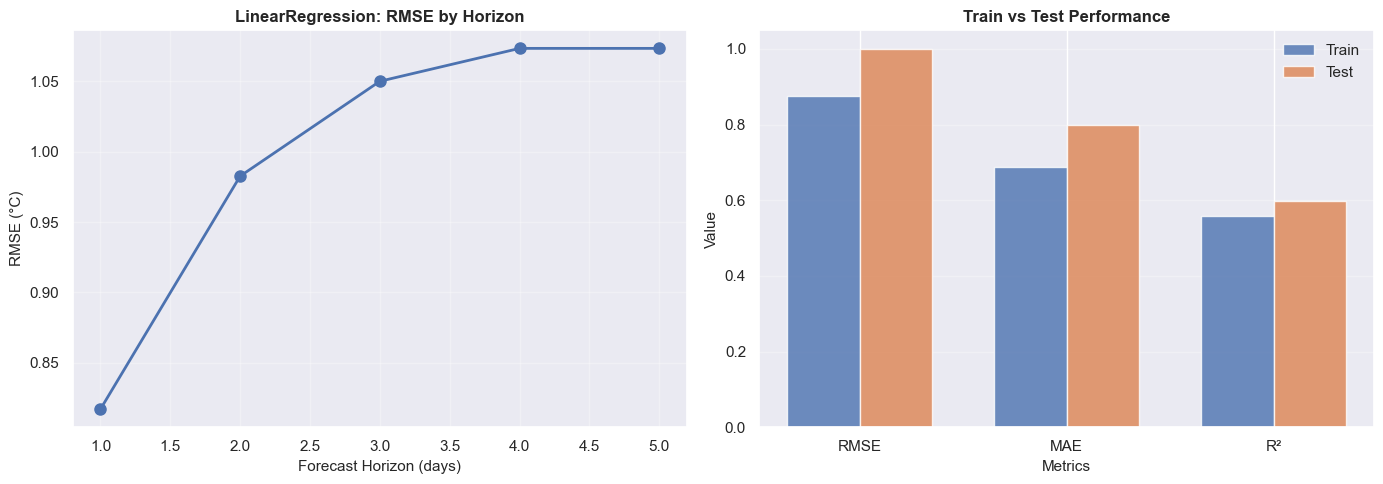


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.093741  0.812007     31
2      0.172557  0.654622     28
3      0.066575  0.595558     57
4      0.233046  0.515150     60
5      0.029034  1.006280     62
6     -0.002138  0.924572     60
7     -0.004893  0.814947     62
8      0.035670  0.848716     62
9     -0.086923  0.882130     56
10    -0.104440  0.970436     31
11     0.049417  0.657942     30
12    -0.220139  0.937185     31


High Error Periods (top 10% errors > 1.32°C):
Total occurrences: 57
Date range: 2024-05-04 00:00:00 to 2025-09-26 00:00:00


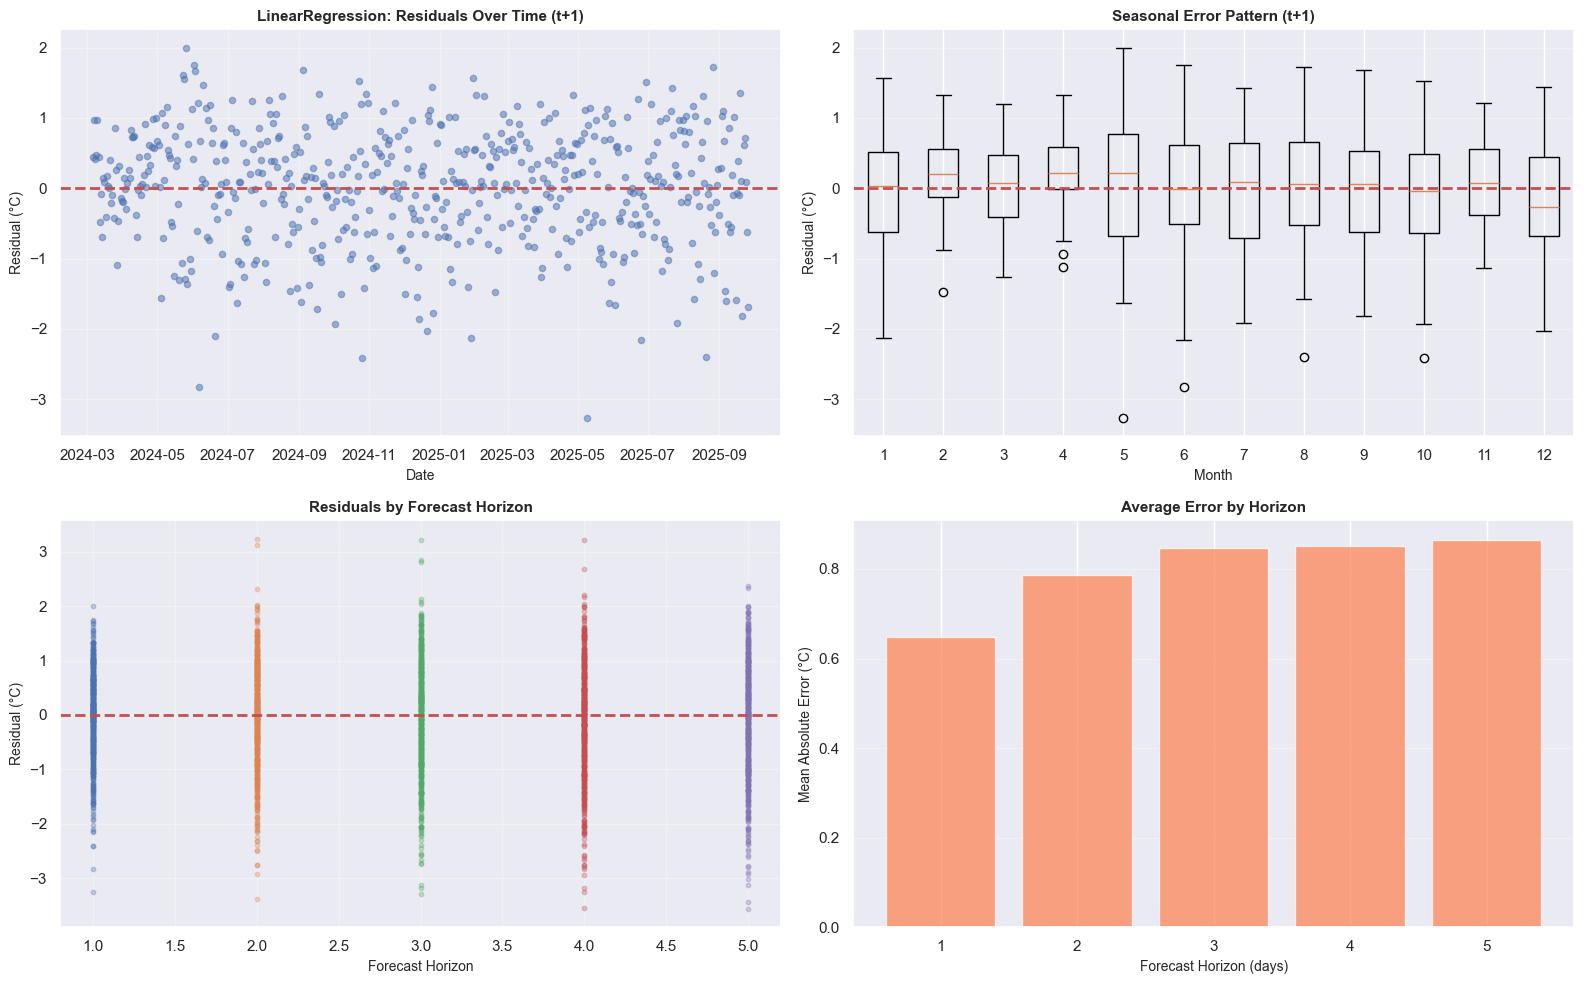


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.0173°C
  Std Dev: 0.8169°C
  Skewness: -0.5058 (left-skewed)
  Kurtosis: 0.2803 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: -0.0054°C
  Std Dev: 0.9826°C
  Skewness: -0.3032 (left-skewed)
  Kurtosis: 0.1062 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+3:
  Mean: -0.0602°C
  Std Dev: 1.0483°C
  Skewness: -0.2206 (left-skewed)
  Kurtosis: -0.1065 (light-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+4:
  Mean: -0.1095°C
  Std Dev: 1.0677°C
  Skewness: -0.3065 (left-skewed)
  Kurtosis: -0.0592 (light-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: -0.1220°C
  Std Dev: 1.0664°C
  Skewness: -0.3295 (left-skewed)
  Kurtosis: -0.2080 (light-tailed)
  ~ Moderate bias


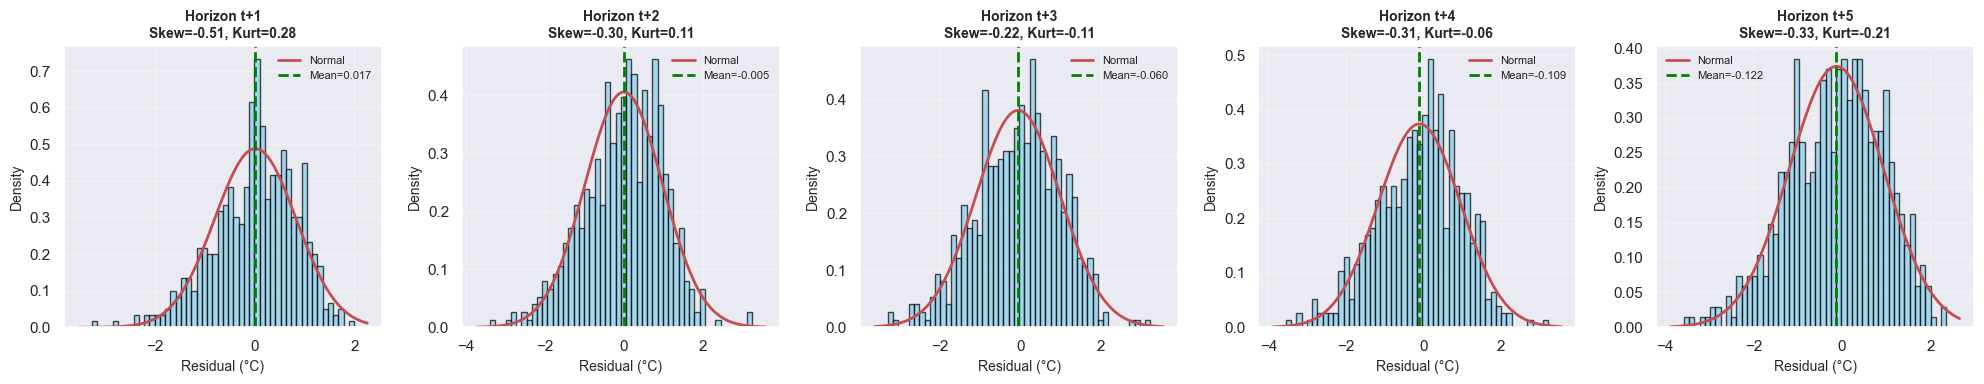


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.667663  0.000298  1.854855           2.503515  0.044600   
1     t+2   0.965538  0.000029  1.440709           2.510182  0.003022   
2     t+3   1.102462  0.003626  1.268864           2.513146  0.328925   
3     t+4   1.152065  0.011986  1.167128           2.513964  1.040360   
4     t+5   1.152070  0.014880  1.104524           2.519957  1.291558   

   Variance %  
0  277.813191  
1  149.213090  
2  115.093648  
3  101.307473  
4   95.873069

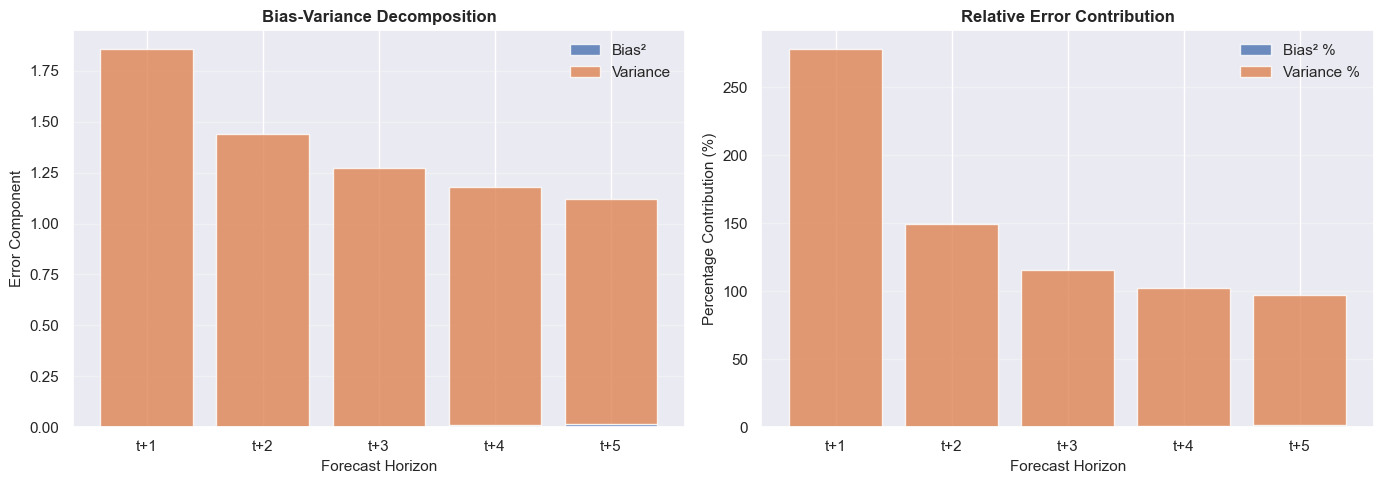


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [16]:
# Analyze Linear Regression model 
analyze_model_comprehensive('LinearRegression', model_results, X_train, X_test,
                           y_train, y_test, test_dates, HORIZONS)

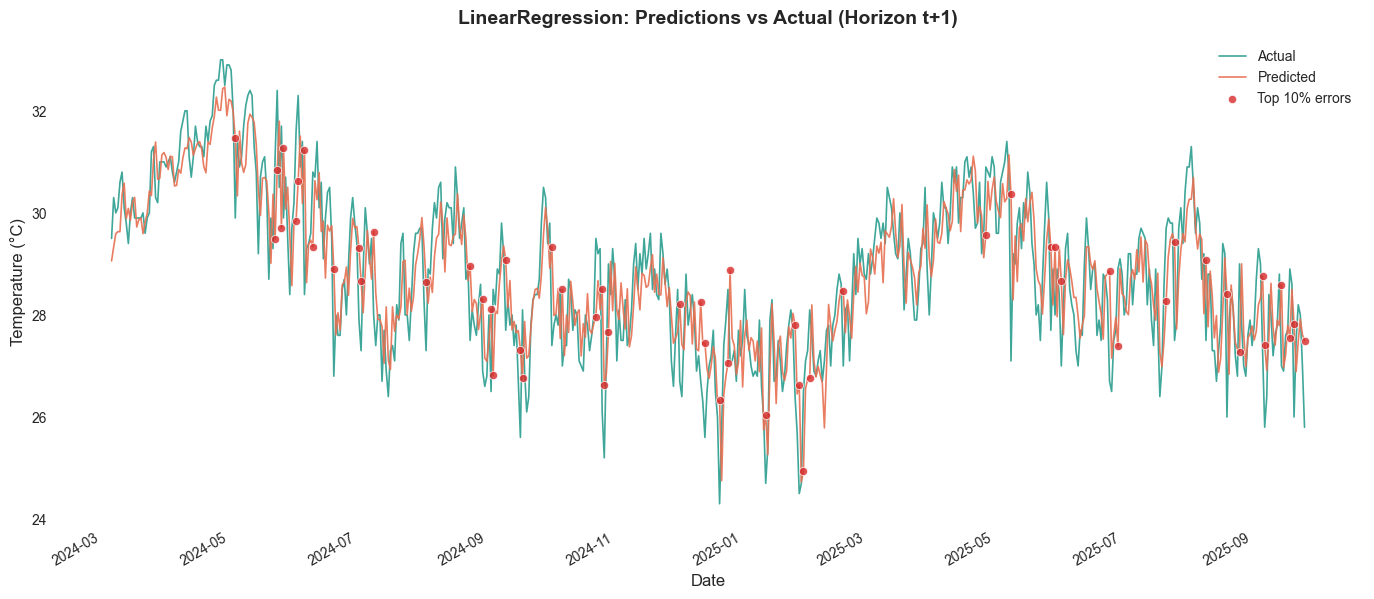

In [17]:
# Actual vs Predicted plot for Linear Regression
from src.plot_helper import base_model_plot

model_name = 'LinearRegression' 
base_model_plot(model_results, model_name, y_test, test_dates)


### **5.4. Random Forest**


COMPREHENSIVE ANALYSIS: RandomForestRegressor

## 2. MODEL SPECIFICATION
Model: RandomForestRegressor
Details: Sklearn pipeline with preprocessing.

Hyperparameters:
  - bootstrap: True
  - ccp_alpha: 0.0
  - criterion: squared_error
  - max_depth: None
  - max_features: 1.0
  - max_leaf_nodes: None
  - max_samples: None
  - min_impurity_decrease: 0.0
  - min_samples_leaf: 1
  - min_samples_split: 2
  - min_weight_fraction_leaf: 0.0
  - monotonic_cst: None
  - n_estimators: 100
  - n_jobs: -1
  - oob_score: False
  - random_state: 42
  - verbose: 0
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 1.0154

MAE:
  Value: 0.8133

MAPE:
  Value: 2.8308

R2:
  Value: 0.5860


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.830487  0.658149  2.291017  0.724504
1     t+2  1.011043  0.811149  2.827317  0.592776
2     t+3  1.072228  0.861061  2.995932  0.542536
3     t+4  1.085211  0.874102  3.043316  0.531543
4     t+5  1.078175  0.861793  2.996288  0.538698


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.317043  1.015429    0.698386          Yes
1   MAE_macro  0.244090  0.813251    0.569160          Yes
2    R2_macro  0.942272  0.586011   -0.356260           No


⚠ Potential overfitting detected (large train-test gap)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.0131
CV MAE (mean): 0.8039
CV R² (mean): 0.3439

[Note: Standard deviation would require storing individual fold results]


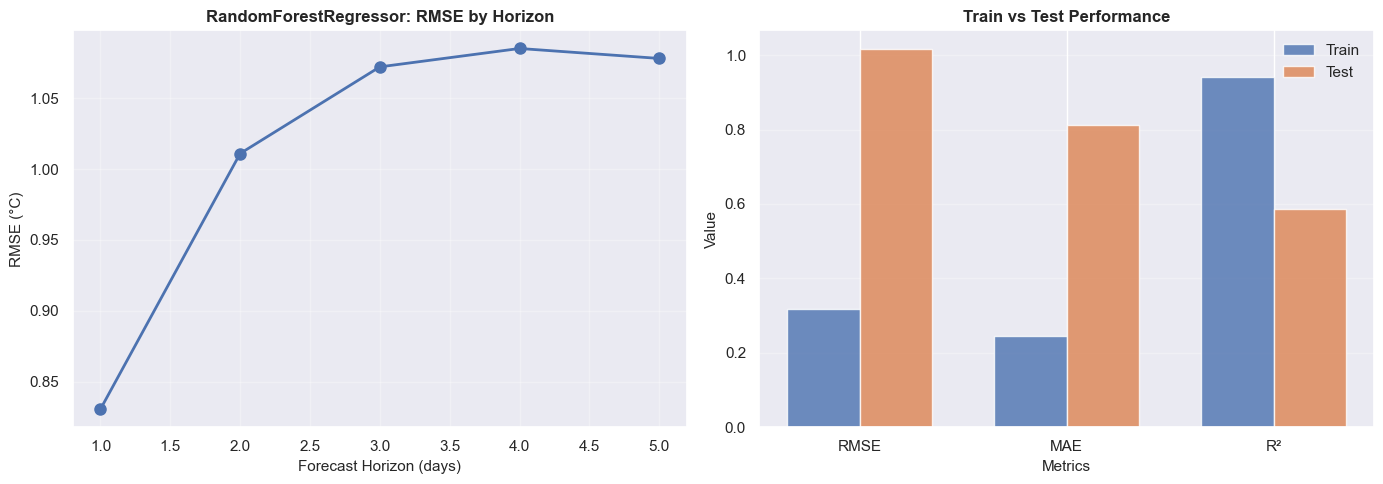


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.231968  0.759210     31
2      0.042714  0.670760     28
3      0.123456  0.565514     57
4      0.296667  0.591589     60
5      0.288774  1.020518     62
6      0.223933  0.858401     60
7      0.211210  0.823497     62
8      0.008774  0.913164     62
9     -0.009518  0.920423     56
10     0.071065  0.972697     31
11     0.146800  0.662244     30
12    -0.190065  0.762801     31


High Error Periods (top 10% errors > 1.37°C):
Total occurrences: 57
Date range: 2024-04-27 00:00:00 to 2025-09-26 00:00:00


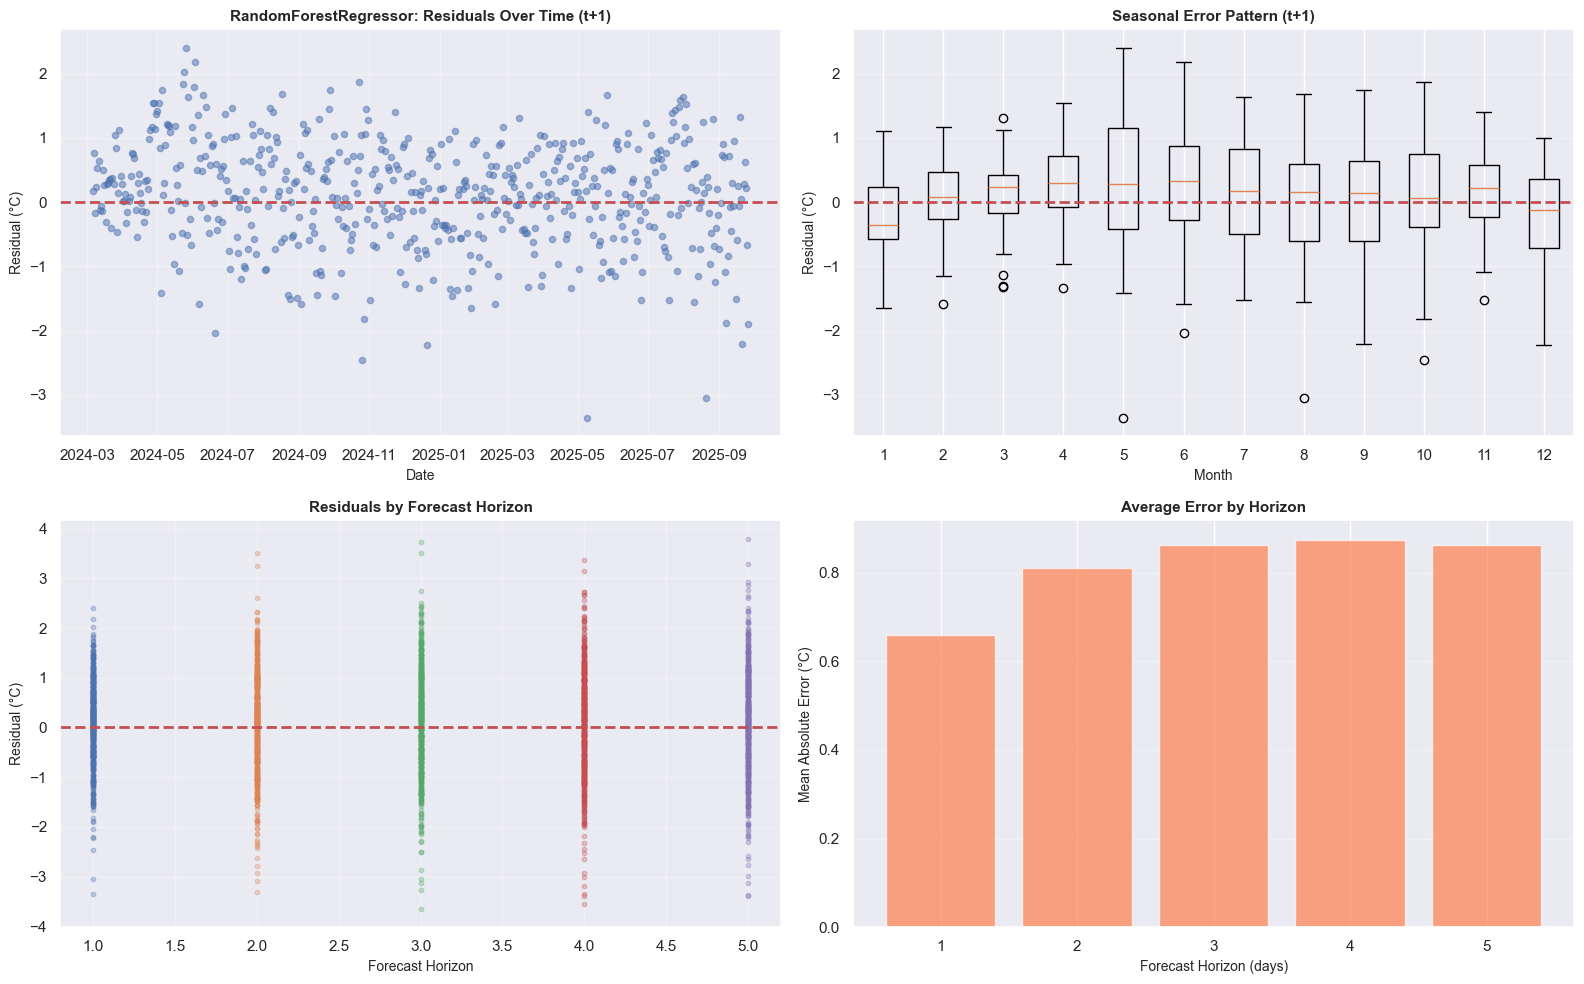


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.1123°C
  Std Dev: 0.8229°C
  Skewness: -0.4167 (left-skewed)
  Kurtosis: 0.5570 (heavy-tailed)
  ~ Moderate bias

Horizon t+2:
  Mean: 0.1013°C
  Std Dev: 1.0060°C
  Skewness: -0.2166 (left-skewed)
  Kurtosis: 0.2414 (heavy-tailed)
  ~ Moderate bias

Horizon t+3:
  Mean: 0.1307°C
  Std Dev: 1.0642°C
  Skewness: -0.1675 (left-skewed)
  Kurtosis: 0.2736 (heavy-tailed)
  ~ Moderate bias

Horizon t+4:
  Mean: 0.0893°C
  Std Dev: 1.0815°C
  Skewness: -0.1785 (left-skewed)
  Kurtosis: 0.2193 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+5:
  Mean: 0.1184°C
  Std Dev: 1.0717°C
  Skewness: -0.1472 (left-skewed)
  Kurtosis: 0.2499 (heavy-tailed)
  ~ Moderate bias


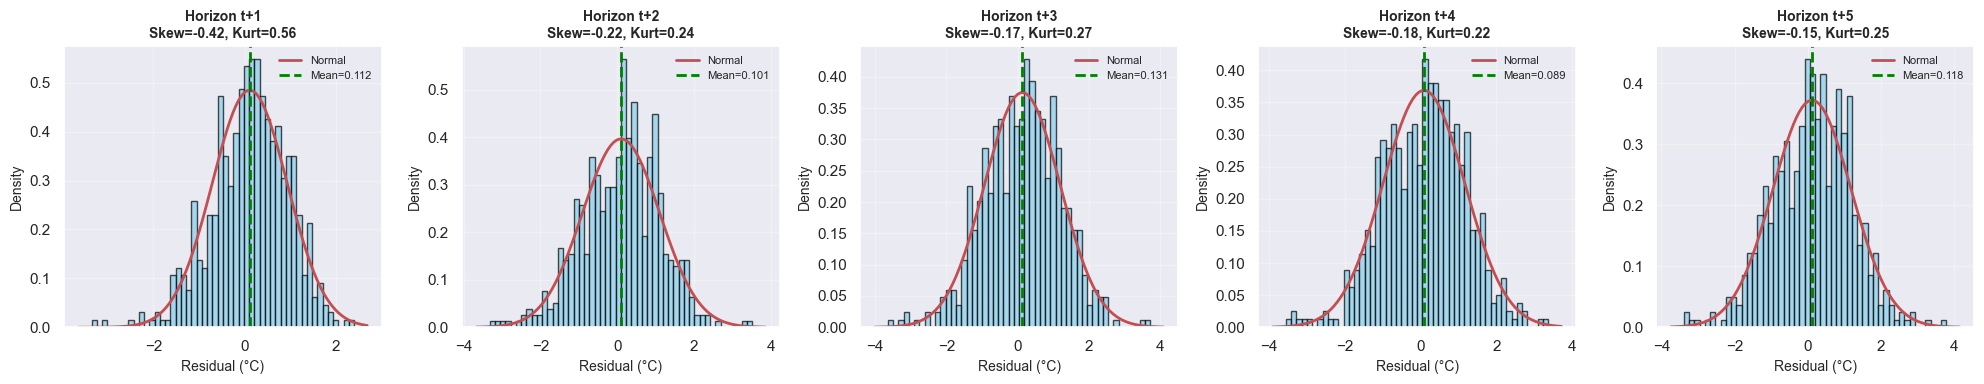


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.689708  0.012608  1.538885           2.503515  1.828040   
1     t+2   1.022207  0.010254  1.108915           2.510182  1.003111   
2     t+3   1.149673  0.017085  1.037792           2.513146  1.486095   
3     t+4   1.177683  0.007969  0.885747           2.513964  0.676681   
4     t+5   1.162461  0.014024  0.896428           2.519957  1.206367   

   Variance %  
0  223.121323  
1  108.482416  
2   90.268381  
3   75.210922  
4   77.114681

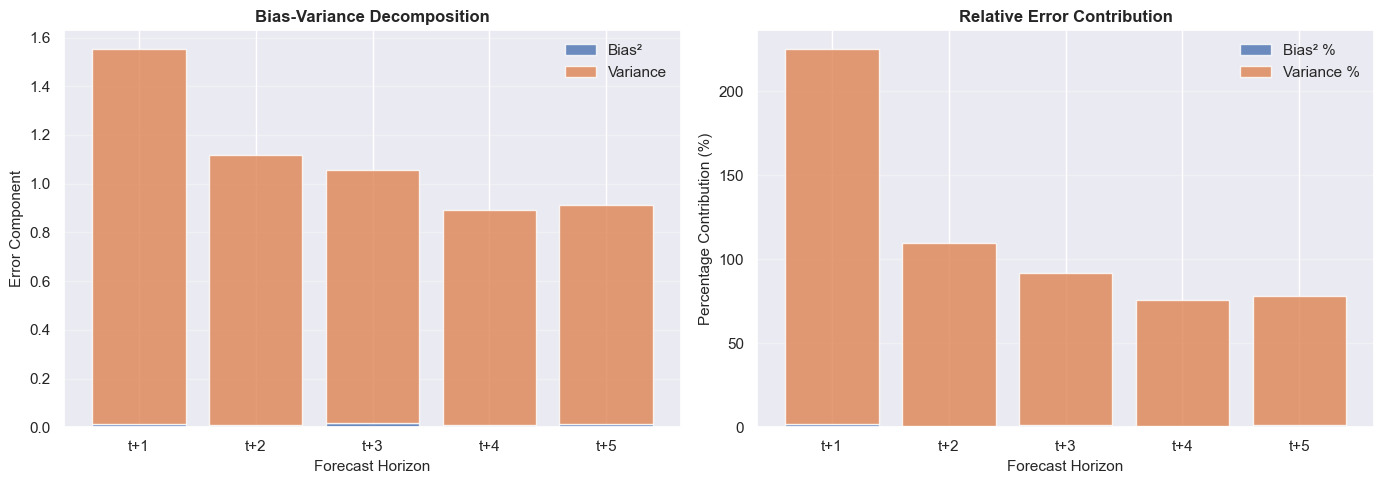


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [18]:
# Analyze RandomForestRegressor model
analyze_model_comprehensive('RandomForestRegressor', model_results, X_train, X_test,
                           y_train, y_test, test_dates, HORIZONS)

In [19]:
# ---(MANUAL TUNE): Random Forest ---

rf_manual_tune_name = 'RandomForest_ManualTune'
print(f"--- Manual Hyperparameter Tuning for: {rf_manual_tune_name} ---")

# 1. Define the grid of hyperparameters to test manually
param_grid = [
    {'n_estimators': 150, 'max_depth': 8,  'min_samples_leaf': 10, 'max_features': 'sqrt'},
    {'n_estimators': 150, 'max_depth': 10, 'min_samples_leaf': 8, 'max_features': 0.7},
    {'n_estimators': 200, 'max_depth': 8,  'min_samples_leaf': 10, 'max_features': 0.8},
    {'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'},
    {'n_estimators': 250, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 0.7},
]

print(f"Testing {len(param_grid)} different hyperparameter combinations...")

manual_tune_results = []

# 2. Loop through each combination, train, and evaluate using cross-validation
for params in tqdm(param_grid, desc="Tuning Progress"):
    model = MultiOutputRegressor(RandomForestRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1))
    pipeline = make_pipeline(model, numeric_cols=numeric_cols,
                             categorical_cols=categorical_cols, text_cols=text_cols)

    cv_metrics_folds = cross_val_evaluate(pipeline, X_train, y_train, cv=tscv,horizons=HORIZONS)
    cv_metrics = aggregate_metrics(cv_metrics_folds)

    manual_tune_results.append({
        'params': params,
        'metrics': cv_metrics
    })
    print(f"\nParams: {params}")
    print(f"CV RMSE: {cv_metrics['RMSE_macro']:.4f}")

# 3. Find the best set of hyperparameters based on the lowest CV RMSE
best_result = min(manual_tune_results, key=lambda x: x['metrics']['RMSE_macro'])
best_params_rf = best_result['params']

print("\n--- Best Hyperparameters Found (Manual Tune) ---")
print(best_params_rf)
print(f"Best CV RMSE: {best_result['metrics']['RMSE_macro']:.4f}")

# 4. Train the final tuned model on the full training data
print(f"\n--- Training final model: {rf_manual_tune_name} ---")
final_rf_model = MultiOutputRegressor(RandomForestRegressor(**best_params_rf, random_state=RANDOM_STATE, n_jobs=-1))
final_rf_pipeline = make_pipeline(final_rf_model, numeric_cols=numeric_cols,
                                 categorical_cols=categorical_cols, text_cols=text_cols)
final_rf_pipeline.fit(X_train, y_train)

# 5. Make predictions and evaluate
print("--- Making predictions ---")
y_pred_train_rf_manual = final_rf_pipeline.predict(X_train)
y_pred_test_rf_manual = final_rf_pipeline.predict(X_test)
cv_metrics_rf_manual_folds = cross_val_evaluate(final_rf_pipeline, X_train, y_train, cv=tscv, horizons=HORIZONS)
cv_metrics_rf_manual = aggregate_metrics(cv_metrics_rf_manual_folds)

# 6. Store the results
print("--- Storing results ---")
model_results[rf_manual_tune_name] = {
    'details': 'Manually-tuned model using Random Forest.',
    'pipeline': final_rf_pipeline,
    'predictions_train': y_pred_train_rf_manual,
    'predictions_test': y_pred_test_rf_manual,
    'train_metrics': compute_metrics(y_train, y_pred_train_rf_manual, HORIZONS),
    'test_metrics': compute_metrics(y_test, y_pred_test_rf_manual, HORIZONS),
    'cv_metrics': cv_metrics_rf_manual
}

print(f"--- Finished training and evaluation for {rf_manual_tune_name} ---")


--- Manual Hyperparameter Tuning for: RandomForest_ManualTune ---
Testing 5 different hyperparameter combinations...


Tuning Progress:  20%|██        | 1/5 [00:05<00:23,  5.86s/it]


Params: {'n_estimators': 150, 'max_depth': 8, 'min_samples_leaf': 10, 'max_features': 'sqrt'}
CV RMSE: 0.9842


Tuning Progress:  40%|████      | 2/5 [00:34<00:57, 19.32s/it]


Params: {'n_estimators': 150, 'max_depth': 10, 'min_samples_leaf': 8, 'max_features': 0.7}
CV RMSE: 0.9931


Tuning Progress:  60%|██████    | 3/5 [01:12<00:55, 27.71s/it]


Params: {'n_estimators': 200, 'max_depth': 8, 'min_samples_leaf': 10, 'max_features': 0.8}
CV RMSE: 0.9916


Tuning Progress:  80%|████████  | 4/5 [01:20<00:20, 20.01s/it]


Params: {'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
CV RMSE: 0.9839


Tuning Progress: 100%|██████████| 5/5 [02:10<00:00, 26.19s/it]


Params: {'n_estimators': 250, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 0.7}
CV RMSE: 0.9955

--- Best Hyperparameters Found (Manual Tune) ---
{'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
Best CV RMSE: 0.9839

--- Training final model: RandomForest_ManualTune ---


--- Making predictions ---
--- Storing results ---
--- Finished training and evaluation for RandomForest_ManualTune ---



COMPREHENSIVE ANALYSIS: RandomForest_ManualTune

## 2. MODEL SPECIFICATION
Model: RandomForest_ManualTune
Details: Manually-tuned model using Random Forest.

Hyperparameters:
  - bootstrap: True
  - ccp_alpha: 0.0
  - criterion: squared_error
  - max_depth: 12
  - max_features: sqrt
  - max_leaf_nodes: None
  - max_samples: None
  - min_impurity_decrease: 0.0
  - min_samples_leaf: 5
  - min_samples_split: 2
  - min_weight_fraction_leaf: 0.0
  - monotonic_cst: None
  - n_estimators: 200
  - n_jobs: -1
  - oob_score: False
  - random_state: 42
  - verbose: 0
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 1.0028

MAE:
  Value: 0.8068

MAPE:
  Value: 2.8058

R2:
  Value: 0.5967


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.833822  0.665574  2.317429  0.722287
1     t+2  0.994968  0.801354  2.786984  0.605621
2     t+3  1.051259  0.848715  2.950826  0.560254
3     t+4  1.068337  0.858889  2.984503  0.545999
4     t+5  1.065746  0.859676  2.989199  0.549272


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.593225  1.002826    0.409602           No
1   MAE_macro  0.454966  0.806842    0.351876           No
2    R2_macro  0.797461  0.596687   -0.200775           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 0.9839
CV MAE (mean): 0.7758
CV R² (mean): 0.3848

[Note: Standard deviation would require storing individual fold results]


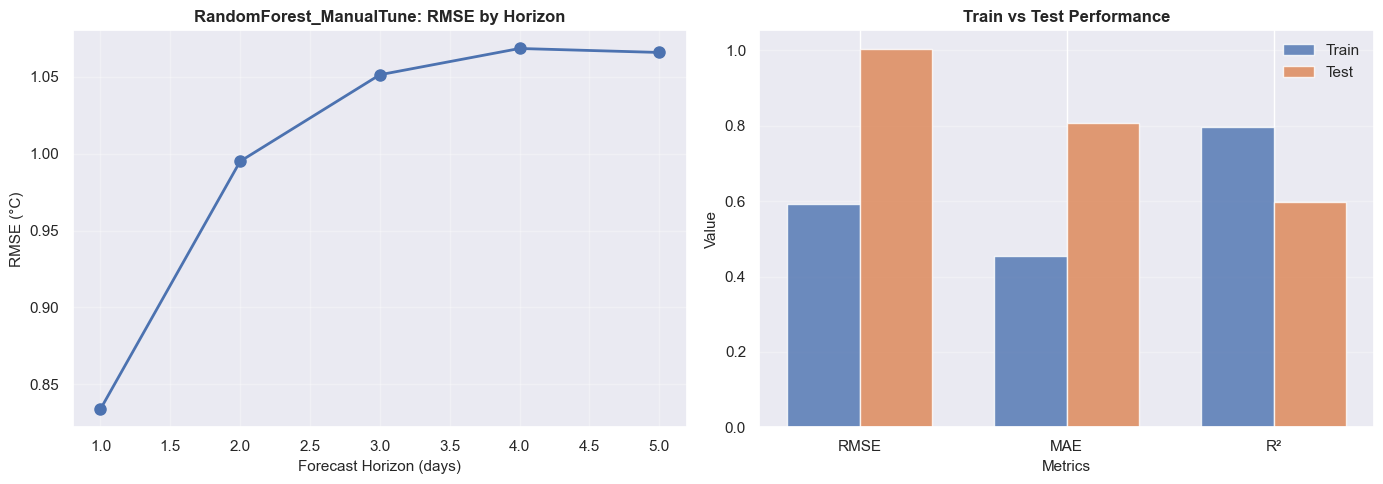


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.282592  0.800753     31
2      0.054850  0.615803     28
3      0.144826  0.560389     57
4      0.369021  0.552567     60
5      0.305670  0.990125     62
6      0.229817  0.915888     60
7      0.164734  0.826469     62
8      0.044262  0.899878     62
9     -0.008295  0.933583     56
10    -0.031057  0.948221     31
11     0.154572  0.624197     30
12    -0.199742  0.816033     31


High Error Periods (top 10% errors > 1.33°C):
Total occurrences: 57
Date range: 2024-04-27 00:00:00 to 2025-09-26 00:00:00


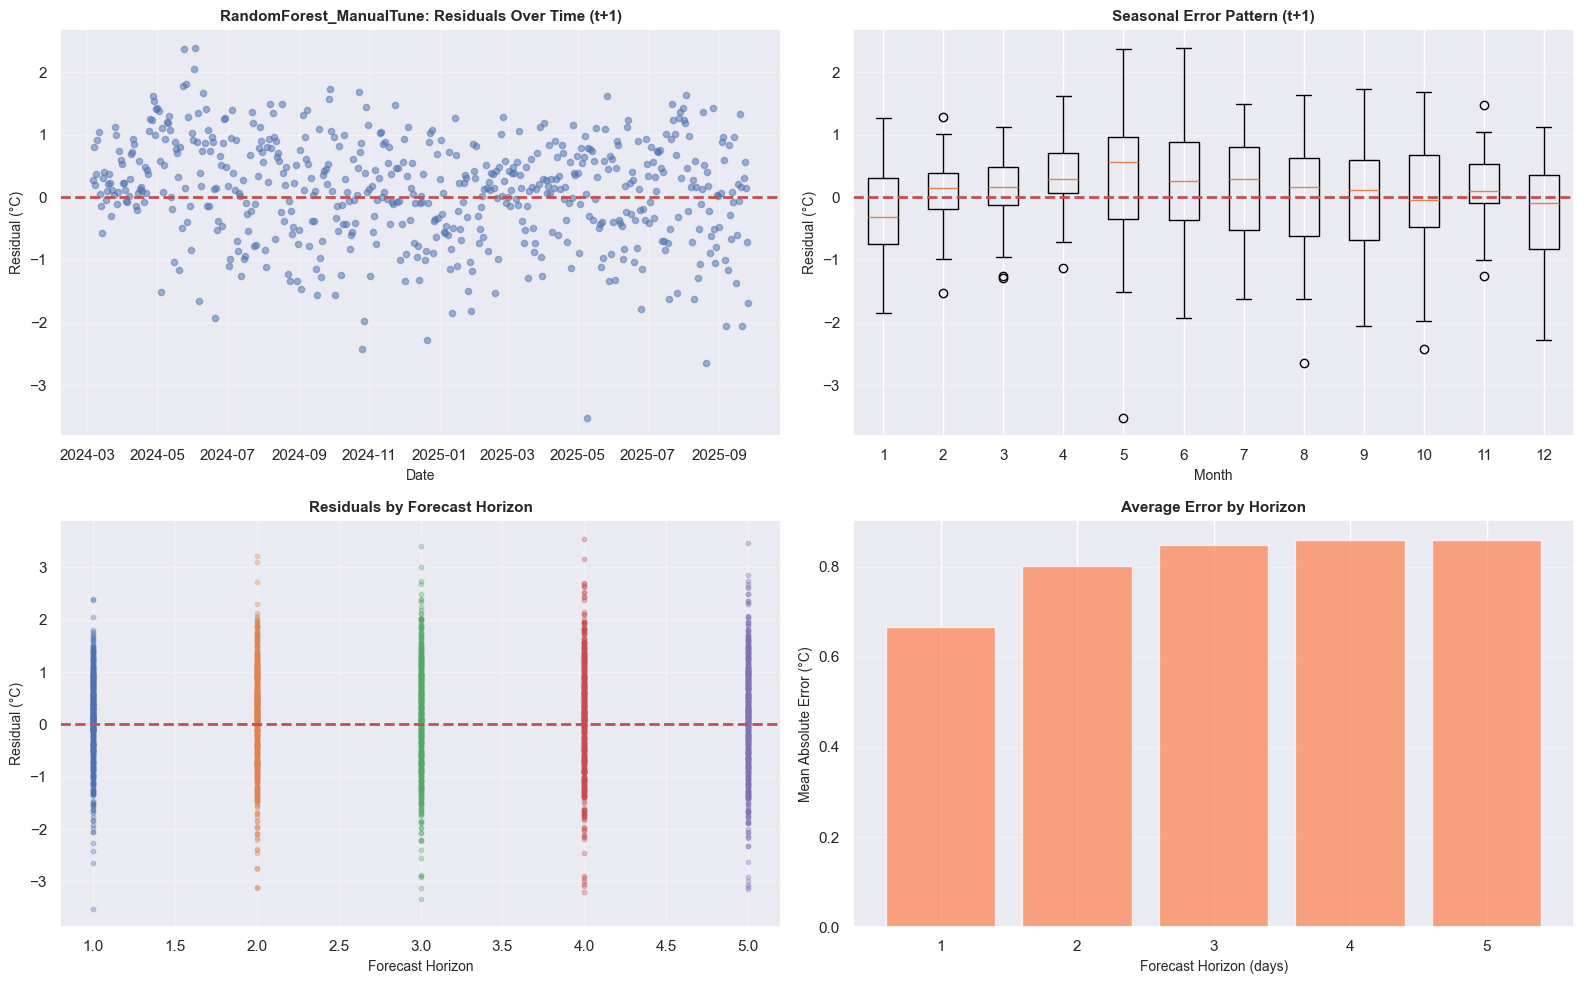


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.1156°C
  Std Dev: 0.8258°C
  Skewness: -0.4527 (left-skewed)
  Kurtosis: 0.4959 (heavy-tailed)
  ~ Moderate bias

Horizon t+2:
  Mean: 0.1505°C
  Std Dev: 0.9835°C
  Skewness: -0.2725 (left-skewed)
  Kurtosis: 0.1677 (heavy-tailed)
  ~ Moderate bias

Horizon t+3:
  Mean: 0.1450°C
  Std Dev: 1.0412°C
  Skewness: -0.2060 (left-skewed)
  Kurtosis: 0.0889 (heavy-tailed)
  ~ Moderate bias

Horizon t+4:
  Mean: 0.1453°C
  Std Dev: 1.0584°C
  Skewness: -0.1616 (left-skewed)
  Kurtosis: 0.1336 (heavy-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: 0.1251°C
  Std Dev: 1.0584°C
  Skewness: -0.1710 (left-skewed)
  Kurtosis: 0.0322 (heavy-tailed)
  ~ Moderate bias


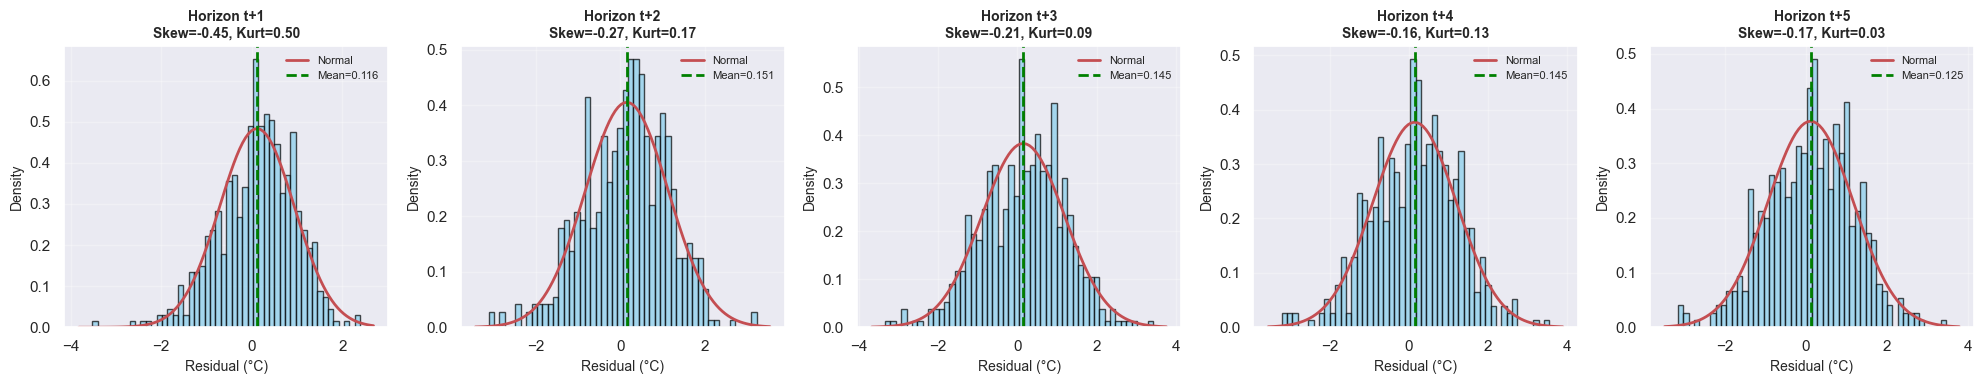


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.695259  0.013362  1.383977           2.503515  1.921834   
1     t+2   0.989962  0.022655  1.112525           2.510182  2.288493   
2     t+3   1.105146  0.021029  0.983076           2.513146  1.902799   
3     t+4   1.141343  0.021107  0.932399           2.513964  1.849337   
4     t+5   1.135815  0.015646  0.879702           2.519957  1.377498   

   Variance %  
0  199.059318  
1  112.380542  
2   88.954410  
3   81.693164  
4   77.451113

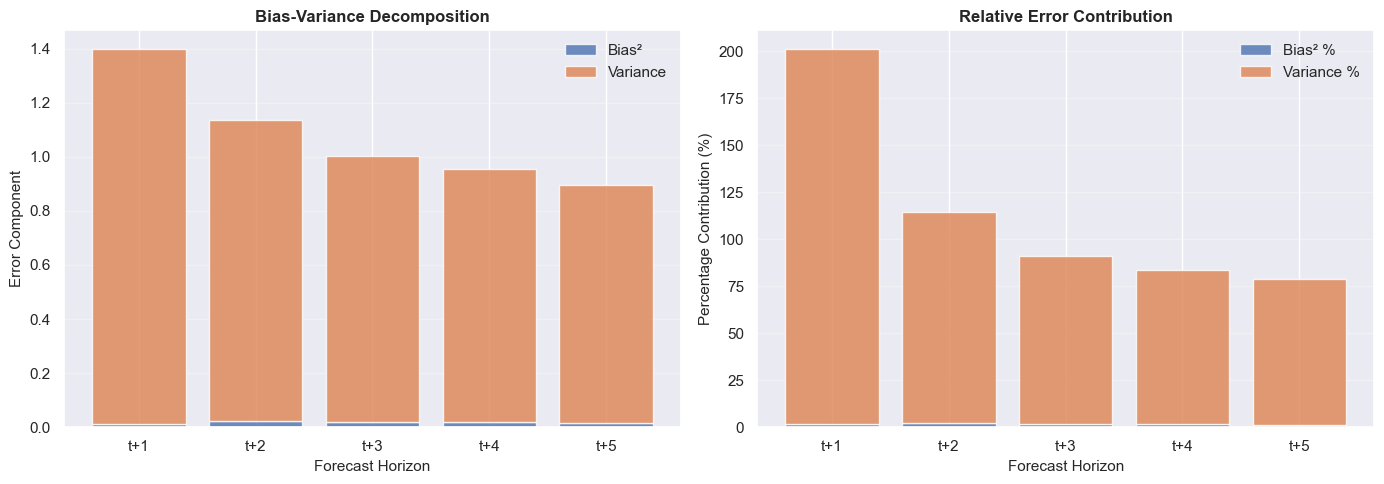


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [20]:
# Analyze the manually tuned Random Forest model
analyze_model_comprehensive(
     'RandomForest_ManualTune',
     model_results,
     X_train,
     X_test,
     y_train,
     y_test,
     test_dates,
     HORIZONS
 )

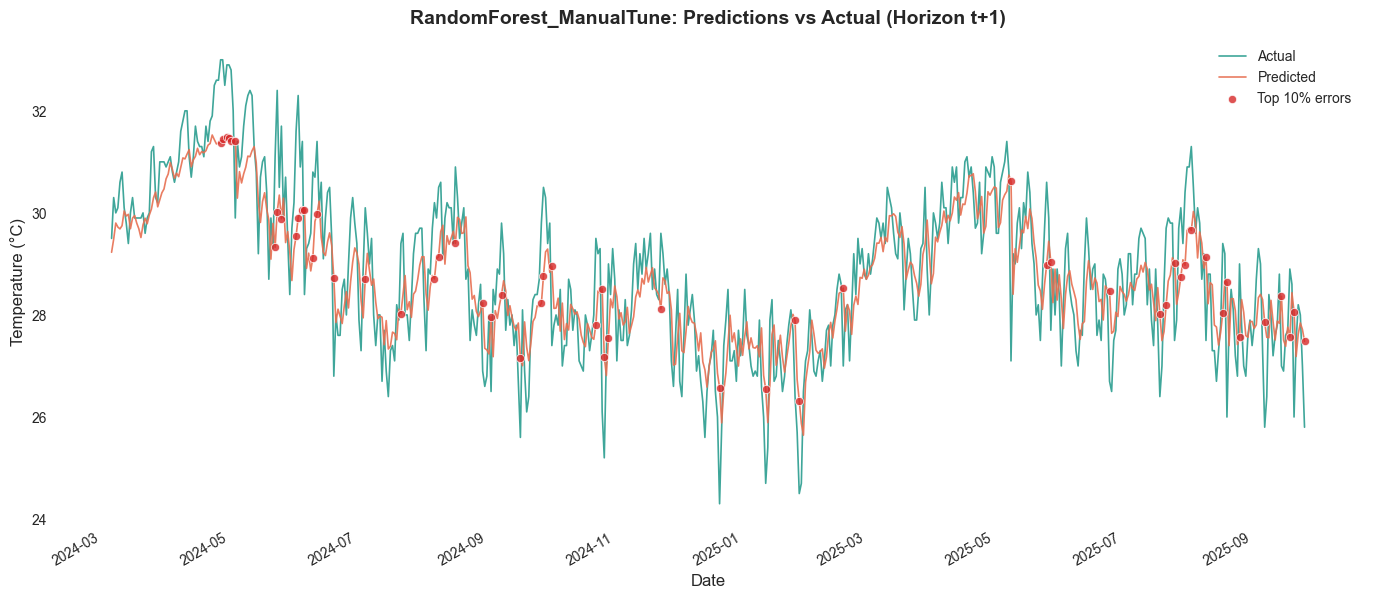

In [21]:
# Actual vs Predicted plot for manually tuned Random Forest
model_name = 'RandomForest_ManualTune'
base_model_plot(model_results, model_name, y_test, test_dates)

### **5.5. HistGradientBoosting**


COMPREHENSIVE ANALYSIS: HistGradientBoosting

## 2. MODEL SPECIFICATION
Model: HistGradientBoosting
Details: Sklearn pipeline with preprocessing.

Hyperparameters:
  - categorical_features: from_dtype
  - early_stopping: auto
  - interaction_cst: None
  - l2_regularization: 0.0
  - learning_rate: 0.1
  - loss: squared_error
  - max_bins: 255
  - max_depth: None
  - max_features: 1.0
  - max_iter: 100
  - max_leaf_nodes: 31
  - min_samples_leaf: 20
  - monotonic_cst: None
  - n_iter_no_change: 10
  - quantile: None
  - random_state: 42
  - scoring: loss
  - tol: 1e-07
  - validation_fraction: 0.1
  - verbose: 0
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 1.0290

MAE:
  Value: 0.8163

MAPE:
  Value: 2.8642

R2:
  Value: 0.5741


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.833782  0.659673  2.303848  0.722314
1     t+2  0.992950  0.793877  2.777628  0.607220
2     t+3  1.096626  0.869046  3.046806  0.521481
3     t+4  1.112222  0.880901  3.110472  0.507934
4     t+5  1.109665  0.878013  3.082209  0.511358


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.357375  1.029049    0.671674          Yes
1   MAE_macro  0.278198  0.816302    0.538104          Yes
2    R2_macro  0.926549  0.574061   -0.352488           No


⚠ Potential overfitting detected (large train-test gap)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.0364
CV MAE (mean): 0.8190
CV R² (mean): 0.3120

[Note: Standard deviation would require storing individual fold results]


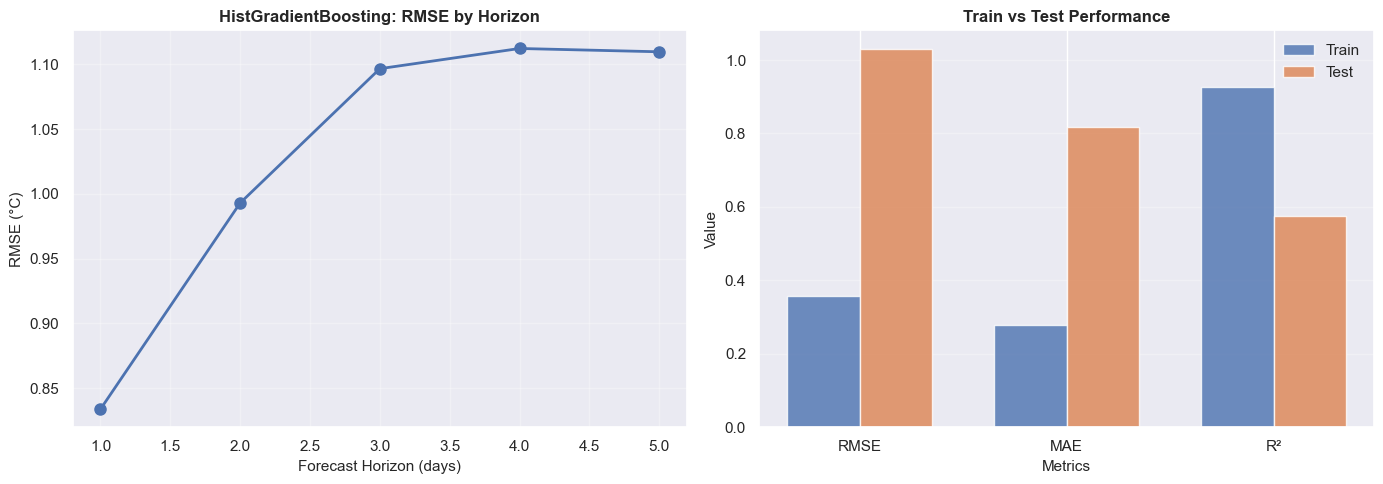


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.354690  0.778386     31
2     -0.105575  0.674255     28
3      0.136637  0.527620     57
4      0.149204  0.632364     60
5      0.179827  0.987897     62
6      0.186658  0.901642     60
7      0.109302  0.851121     62
8      0.015007  0.890952     62
9      0.010035  0.938292     56
10     0.028501  0.977916     31
11     0.148142  0.671034     30
12    -0.259799  0.858395     31


High Error Periods (top 10% errors > 1.36°C):
Total occurrences: 57
Date range: 2024-04-27 00:00:00 to 2025-09-26 00:00:00


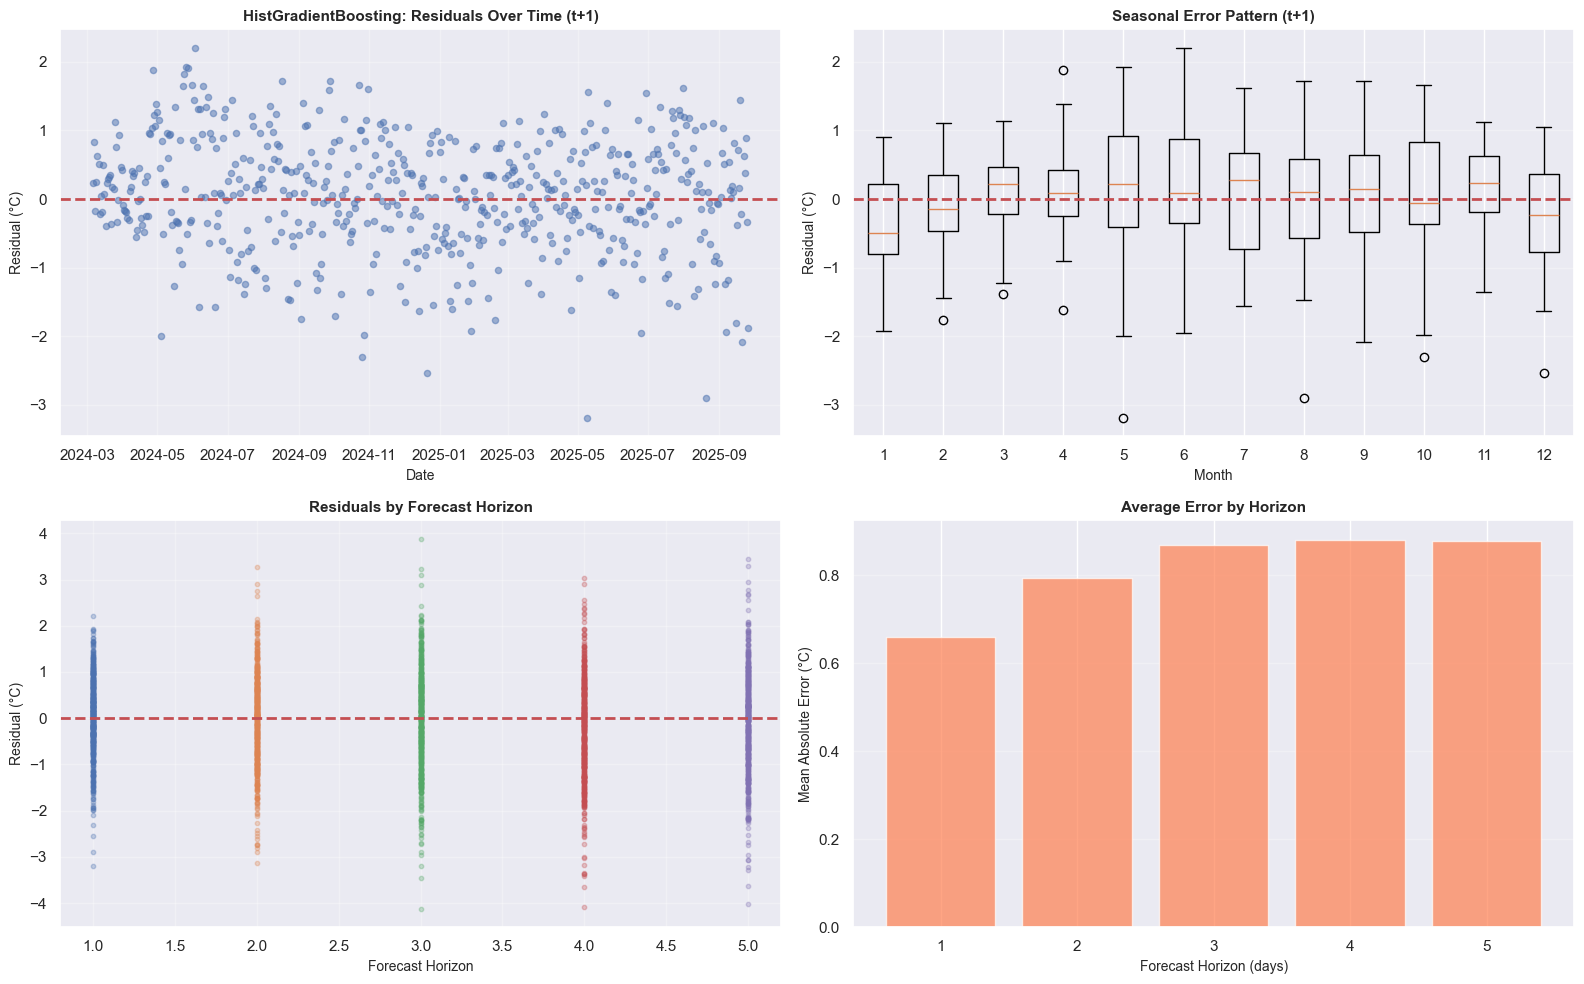


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.0538°C
  Std Dev: 0.8320°C
  Skewness: -0.4045 (left-skewed)
  Kurtosis: 0.3227 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: -0.0207°C
  Std Dev: 0.9927°C
  Skewness: -0.1545 (left-skewed)
  Kurtosis: 0.1512 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+3:
  Mean: -0.0546°C
  Std Dev: 1.0953°C
  Skewness: -0.1517 (left-skewed)
  Kurtosis: 0.3573 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+4:
  Mean: -0.2313°C
  Std Dev: 1.0879°C
  Skewness: -0.1851 (left-skewed)
  Kurtosis: 0.2853 (heavy-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: -0.0845°C
  Std Dev: 1.1064°C
  Skewness: -0.1869 (left-skewed)
  Kurtosis: 0.3080 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)


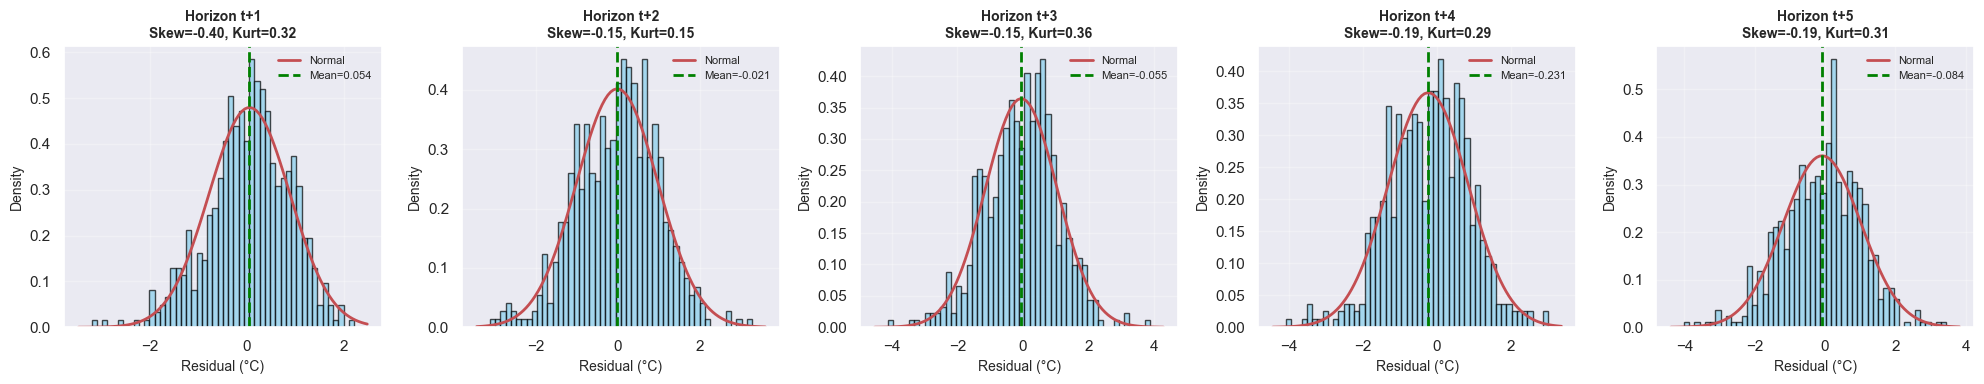


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.695192  0.002897  1.640624           2.503515  0.416758   
1     t+2   0.985950  0.000430  1.114009           2.510182  0.043588   
2     t+3   1.202589  0.002979  1.055072           2.513146  0.247728   
3     t+4   1.237037  0.053481  0.875828           2.513964  4.323309   
4     t+5   1.231355  0.007137  0.885820           2.519957  0.579635   

   Variance %  
0  235.995896  
1  112.988320  
2   87.733386  
3   70.800435  
4   71.938644

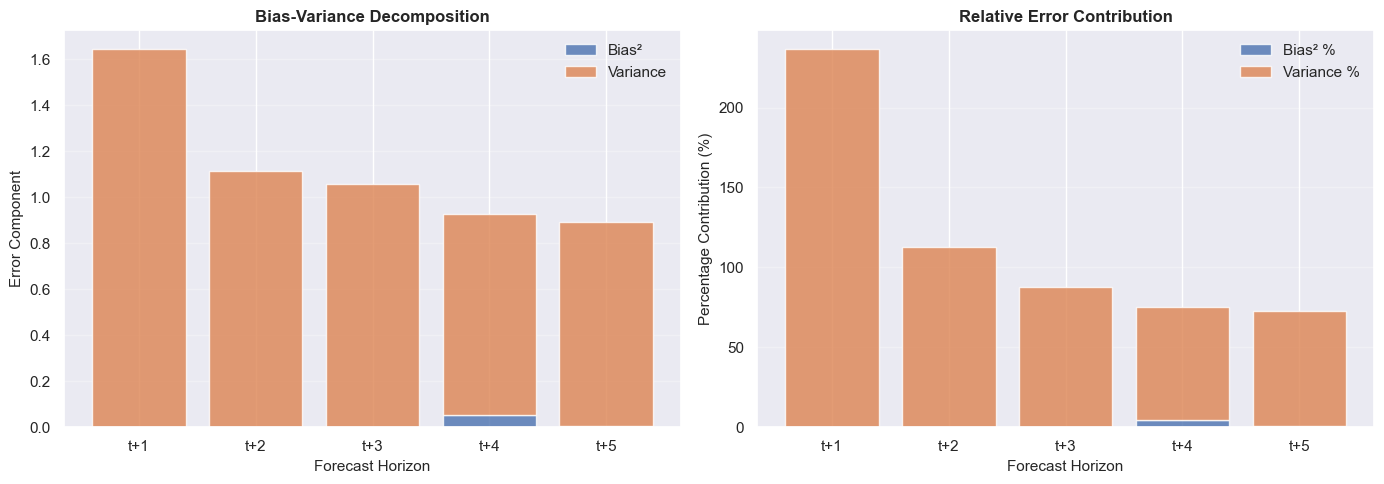


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [22]:
# #Analyse Baseline HGB:
analyze_model_comprehensive(
     'HistGradientBoosting',
     model_results,
     X_train, X_test, y_train, y_test, test_dates
 )

#### **Tuning using optuna**

Optuna was applied to automatically optimize key hyperparameters of the HistGradientBoostingRegressor using a Bayesian optimization approach (TPE sampler). The objective function minimized the average macro RMSE across three time-series cross-validation folds.

The parameters tuned included:

- vlearning_rate (0.01–0.2) – controls gradient step size, balancing learning speed and stability.

- max_depth (3–12) – limits tree complexity to prevent overfitting.

- max_iter (200–700) – number of boosting iterations.

- min_samples_leaf (5–80) – smooths predictions by setting minimum samples per leaf.

- l2_regularization (1e−8–1e−1) – adds penalty to reduce variance.

After 10 optimization trials, the best configuration found was:
learning_rate = 0.0201, max_depth = 3, max_iter = 493, min_samples_leaf = 25, and l2_regularization = 9.85×10⁻⁶, achieving a balanced trade-off between bias and variance.

In [23]:
#Best Optuna params: {'learning_rate': 0.02014148621347681, 'max_depth': 3, 'max_iter': 493,
# 'min_samples_leaf': 25, 'l2_regularization': 9.852173472173725e-06}

In [24]:
best_params = {
    'learning_rate': 0.02014148621347681,
    'max_depth': 3,
    'max_iter': 493,
    'min_samples_leaf': 25,
    'l2_regularization': 9.852173472173725e-06
}

optuna_estimator = MultiOutputRegressor(
    HistGradientBoostingRegressor(random_state=RANDOM_STATE, **best_params)
)
optuna_pipeline = make_pipeline(optuna_estimator, numeric_cols=numeric_cols,
                               categorical_cols=categorical_cols, text_cols=text_cols)

cv_metrics_optuna = aggregate_metrics(cross_val_evaluate(optuna_pipeline, X_train, y_train, tscv, horizons=HORIZONS))
optuna_pipeline.fit(X_train, y_train)

train_pred_optuna = optuna_pipeline.predict(X_train)
test_pred_optuna  = optuna_pipeline.predict(X_test)

model_results['HistGradientBoosting_Optuna'] = {
    'pipeline': optuna_pipeline,
    'cv_metrics': cv_metrics_optuna,
    'train_metrics': compute_metrics(y_train.values, train_pred_optuna, HORIZONS),
    'test_metrics': compute_metrics(y_test.values, test_pred_optuna, HORIZONS),
    'predictions_test': test_pred_optuna,
    'predictions_train': train_pred_optuna,
    'details': f"Optuna-tuned HistGradientBoosting params: {best_params}"
}

# Display metrics as DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['RMSE_macro', 'MAE_macro', 'MAPE_macro', 'R2_macro'],
    'Cross-Validation': [cv_metrics_optuna['RMSE_macro'], cv_metrics_optuna['MAE_macro'],
                         cv_metrics_optuna['MAPE_macro'], cv_metrics_optuna['R2_macro']],
    'Train': [model_results['HistGradientBoosting_Optuna']['train_metrics']['RMSE_macro'],
              model_results['HistGradientBoosting_Optuna']['train_metrics']['MAE_macro'],
              model_results['HistGradientBoosting_Optuna']['train_metrics']['MAPE_macro'],
              model_results['HistGradientBoosting_Optuna']['train_metrics']['R2_macro']],
    'Test': [model_results['HistGradientBoosting_Optuna']['test_metrics']['RMSE_macro'],
             model_results['HistGradientBoosting_Optuna']['test_metrics']['MAE_macro'],
             model_results['HistGradientBoosting_Optuna']['test_metrics']['MAPE_macro'],
             model_results['HistGradientBoosting_Optuna']['test_metrics']['R2_macro']]
})
display(metrics_df.style.set_caption("Optuna-Tuned HistGradientBoostingRegressor"))


COMPREHENSIVE ANALYSIS: HistGradientBoosting_Optuna

## 2. MODEL SPECIFICATION
Model: HistGradientBoosting_Optuna
Details: Optuna-tuned HistGradientBoosting params: {'learning_rate': 0.02014148621347681, 'max_depth': 3, 'max_iter': 493, 'min_samples_leaf': 25, 'l2_regularization': 9.852173472173725e-06}

Hyperparameters:
  - categorical_features: from_dtype
  - early_stopping: auto
  - interaction_cst: None
  - l2_regularization: 9.852173472173725e-06
  - learning_rate: 0.02014148621347681
  - loss: squared_error
  - max_bins: 255
  - max_depth: 3
  - max_features: 1.0
  - max_iter: 493
  - max_leaf_nodes: 31
  - min_samples_leaf: 25
  - monotonic_cst: None
  - n_iter_no_change: 10
  - quantile: None
  - random_state: 42
  - scoring: loss
  - tol: 1e-07
  - validation_fraction: 0.1
  - verbose: 0
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.800919  0.630227  2.203306  0.743772
1     t+2  0.961630  0.760403  2.667974  0.631608
2     t+3  1.033868  0.821062  2.883142  0.574683
3     t+4  1.049166  0.826390  2.906277  0.562146
4     t+5  1.059596  0.835356  2.941957  0.554459


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.754792  0.981036    0.226244           No
1   MAE_macro  0.590144  0.774688    0.184544           No
2    R2_macro  0.671366  0.613334   -0.058032           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.0063
CV MAE (mean): 0.7979
CV R² (mean): 0.3517

[Note: Standard deviation would require storing individual fold results]


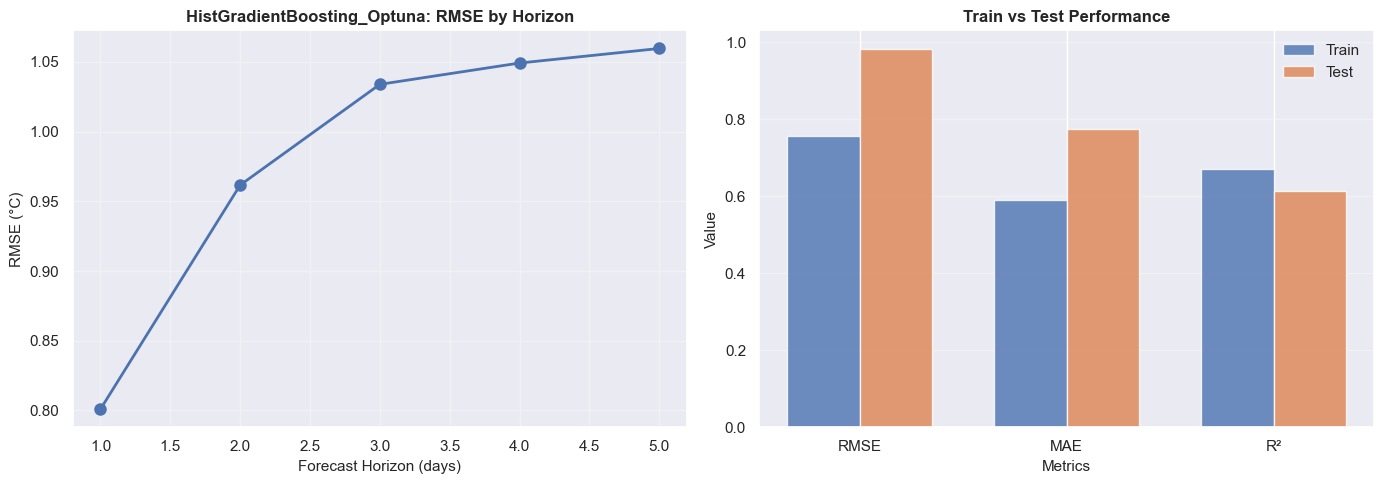


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.295103  0.750388     31
2     -0.094665  0.673066     28
3      0.033673  0.533394     57
4      0.193522  0.580413     60
5      0.099885  0.939621     62
6      0.134950  0.892197     60
7      0.127615  0.797788     62
8     -0.048734  0.871536     62
9      0.008752  0.904402     56
10     0.038023  0.977463     31
11     0.138485  0.626326     30
12    -0.231081  0.801874     31


High Error Periods (top 10% errors > 1.30°C):
Total occurrences: 57
Date range: 2024-04-27 00:00:00 to 2025-09-26 00:00:00


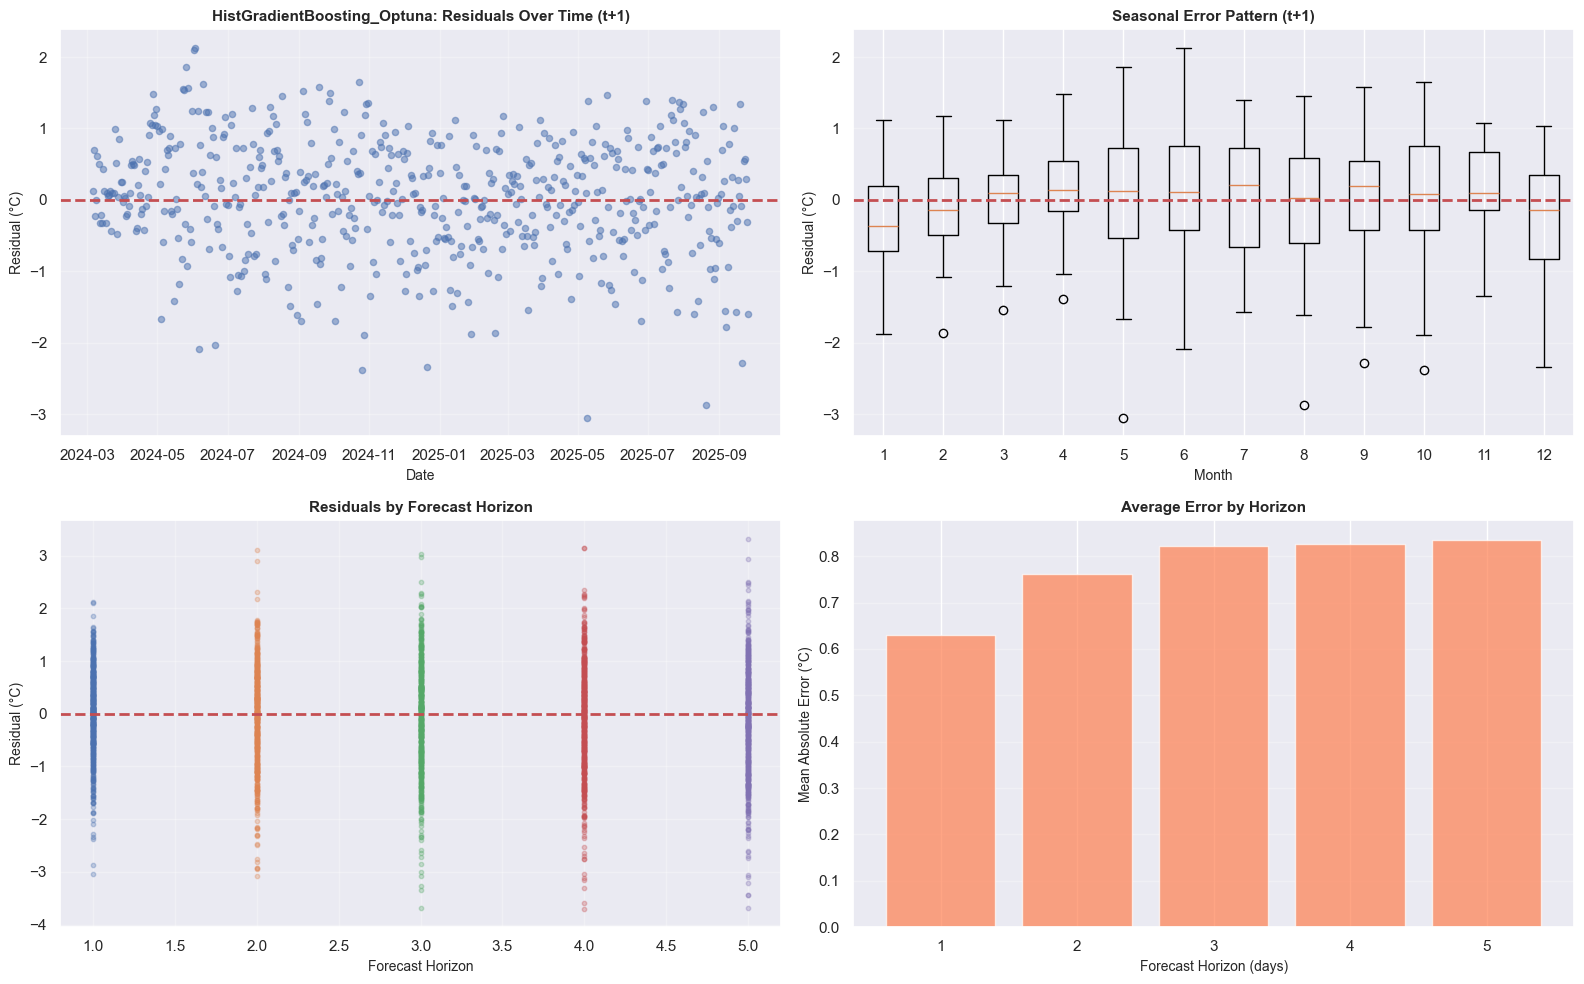


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.0343°C
  Std Dev: 0.8002°C
  Skewness: -0.4279 (left-skewed)
  Kurtosis: 0.3770 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: -0.0390°C
  Std Dev: 0.9608°C
  Skewness: -0.3166 (left-skewed)
  Kurtosis: 0.2093 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+3:
  Mean: -0.0785°C
  Std Dev: 1.0309°C
  Skewness: -0.2189 (left-skewed)
  Kurtosis: 0.2303 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+4:
  Mean: -0.1062°C
  Std Dev: 1.0438°C
  Skewness: -0.2440 (left-skewed)
  Kurtosis: 0.3321 (heavy-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: -0.1444°C
  Std Dev: 1.0497°C
  Skewness: -0.1717 (left-skewed)
  Kurtosis: 0.2735 (heavy-tailed)
  ~ Moderate bias


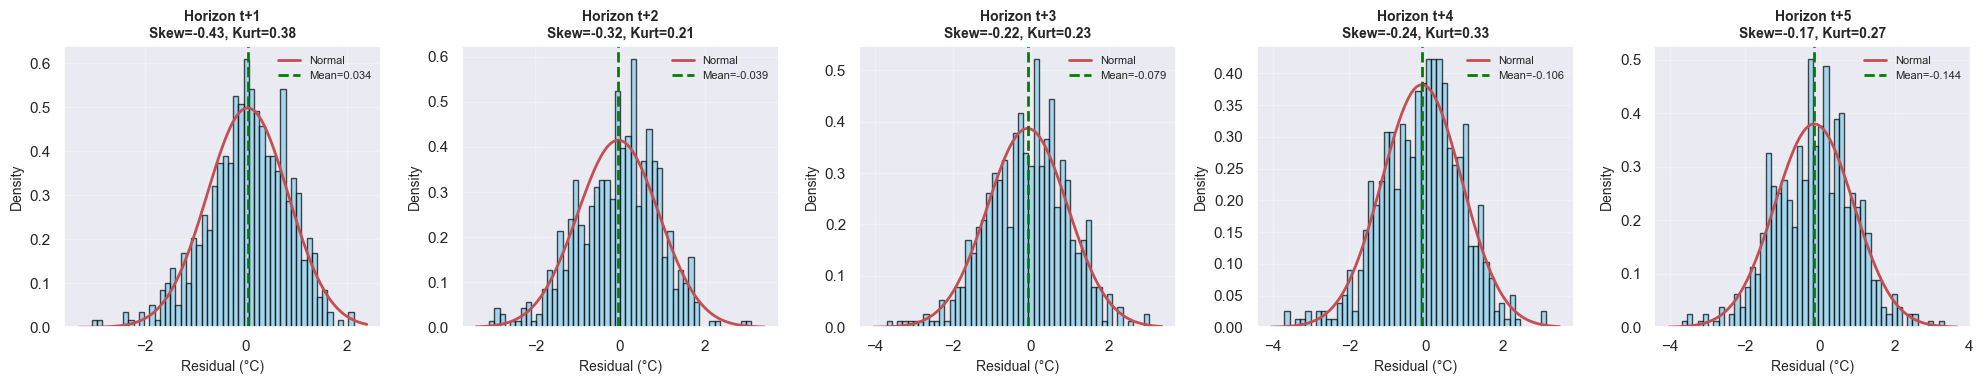


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.641471  0.001179  1.689130           2.503515  0.183804   
1     t+2   0.924731  0.001521  1.208299           2.510182  0.164504   
2     t+3   1.068883  0.006167  1.030042           2.513146  0.576953   
3     t+4   1.100750  0.011273  0.993716           2.513964  1.024081   
4     t+5   1.122743  0.020838  0.938886           2.519957  1.855994   

   Variance %  
0  263.321513  
1  130.664851  
2   96.366177  
3   90.276208  
4   83.624331

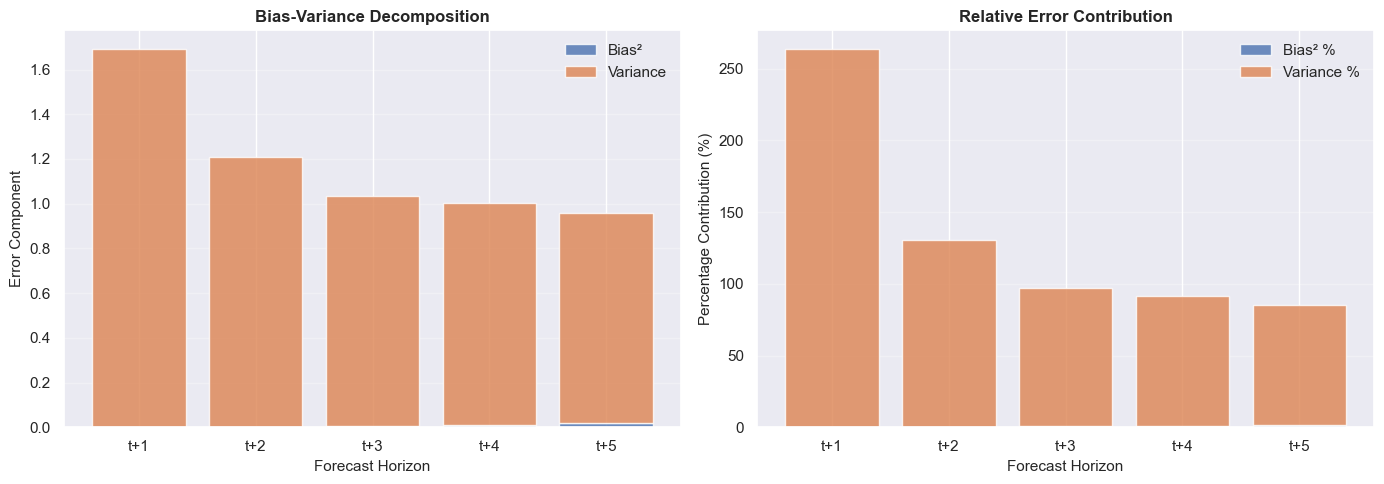


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [25]:
# Analyze the Optuna-tuned HistGradientBoosting model:
analyze_model_comprehensive(
     'HistGradientBoosting_Optuna',
     model_results,
     X_train, X_test, y_train, y_test, test_dates
 )

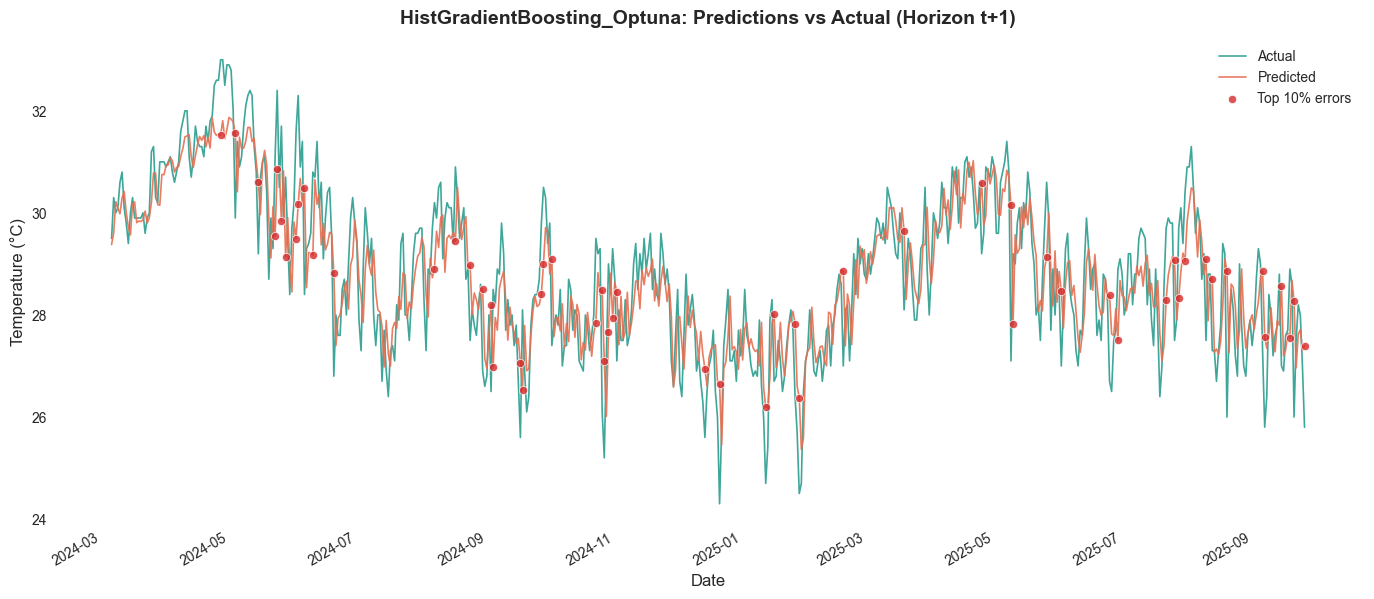

In [26]:
# Actual vs Predicted plot for Optuna-tuned HGB
model_name = 'HistGradientBoosting_Optuna'  
base_model_plot(model_results, model_name, y_test, test_dates)

### **5.6. Huber Regression**


COMPREHENSIVE ANALYSIS: HuberRegressor

## 2. MODEL SPECIFICATION
Model: HuberRegressor
Details: Sklearn pipeline with preprocessing.

Hyperparameters:
  - alpha: 0.0001
  - epsilon: 1.35
  - fit_intercept: True
  - max_iter: 100
  - tol: 1e-05
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 1.0385

MAE:
  Value: 0.8199

MAPE:
  Value: 2.8883

R2:
  Value: 0.5667


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.847404  0.664329  2.333477  0.713166
1     t+2  1.022707  0.798449  2.816393  0.583325
2     t+3  1.087088  0.863778  3.042393  0.529769
3     t+4  1.120900  0.881019  3.105954  0.500225
4     t+5  1.114623  0.891954  3.143384  0.506982


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.928989  1.038544    0.109555           No
1   MAE_macro  0.704144  0.819906    0.115761           No
2    R2_macro  0.503106  0.566693    0.063587           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.1192
CV MAE (mean): 0.8704
CV R² (mean): 0.1916

[Note: Standard deviation would require storing individual fold results]


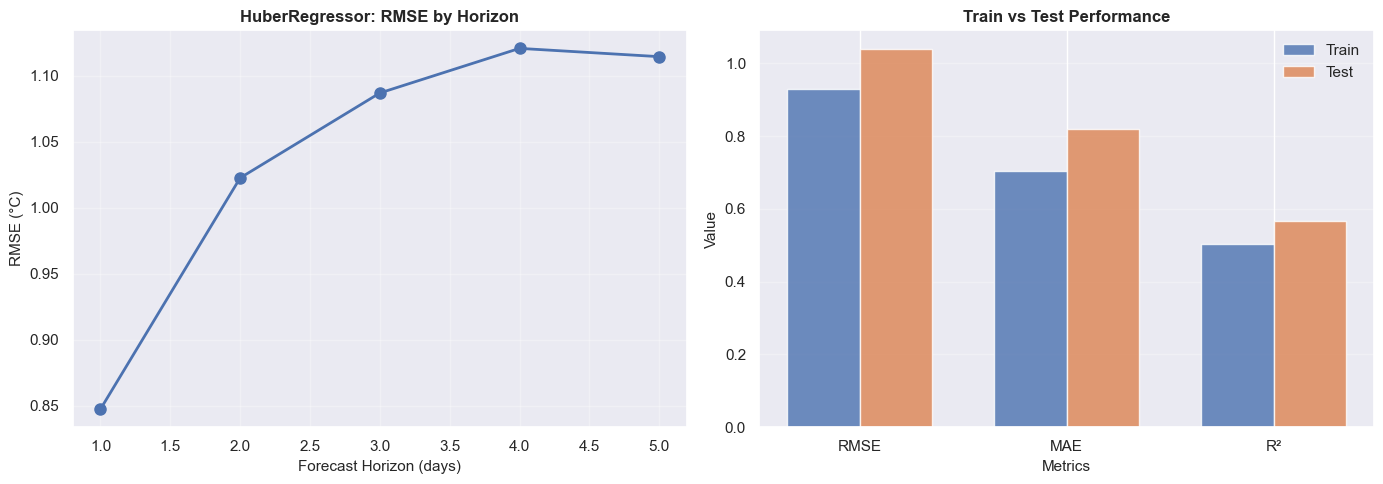


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.256043  0.860015     31
2      0.075656  0.660817     28
3     -0.004328  0.595770     57
4      0.213231  0.487459     60
5     -0.059775  1.027849     62
6     -0.047917  0.943132     60
7     -0.081472  0.849501     62
8     -0.077544  0.830321     62
9     -0.089940  0.899006     56
10    -0.267144  1.117904     31
11    -0.078567  0.681184     30
12    -0.340776  1.008656     31


High Error Periods (top 10% errors > 1.42°C):
Total occurrences: 57
Date range: 2024-05-04 00:00:00 to 2025-09-26 00:00:00


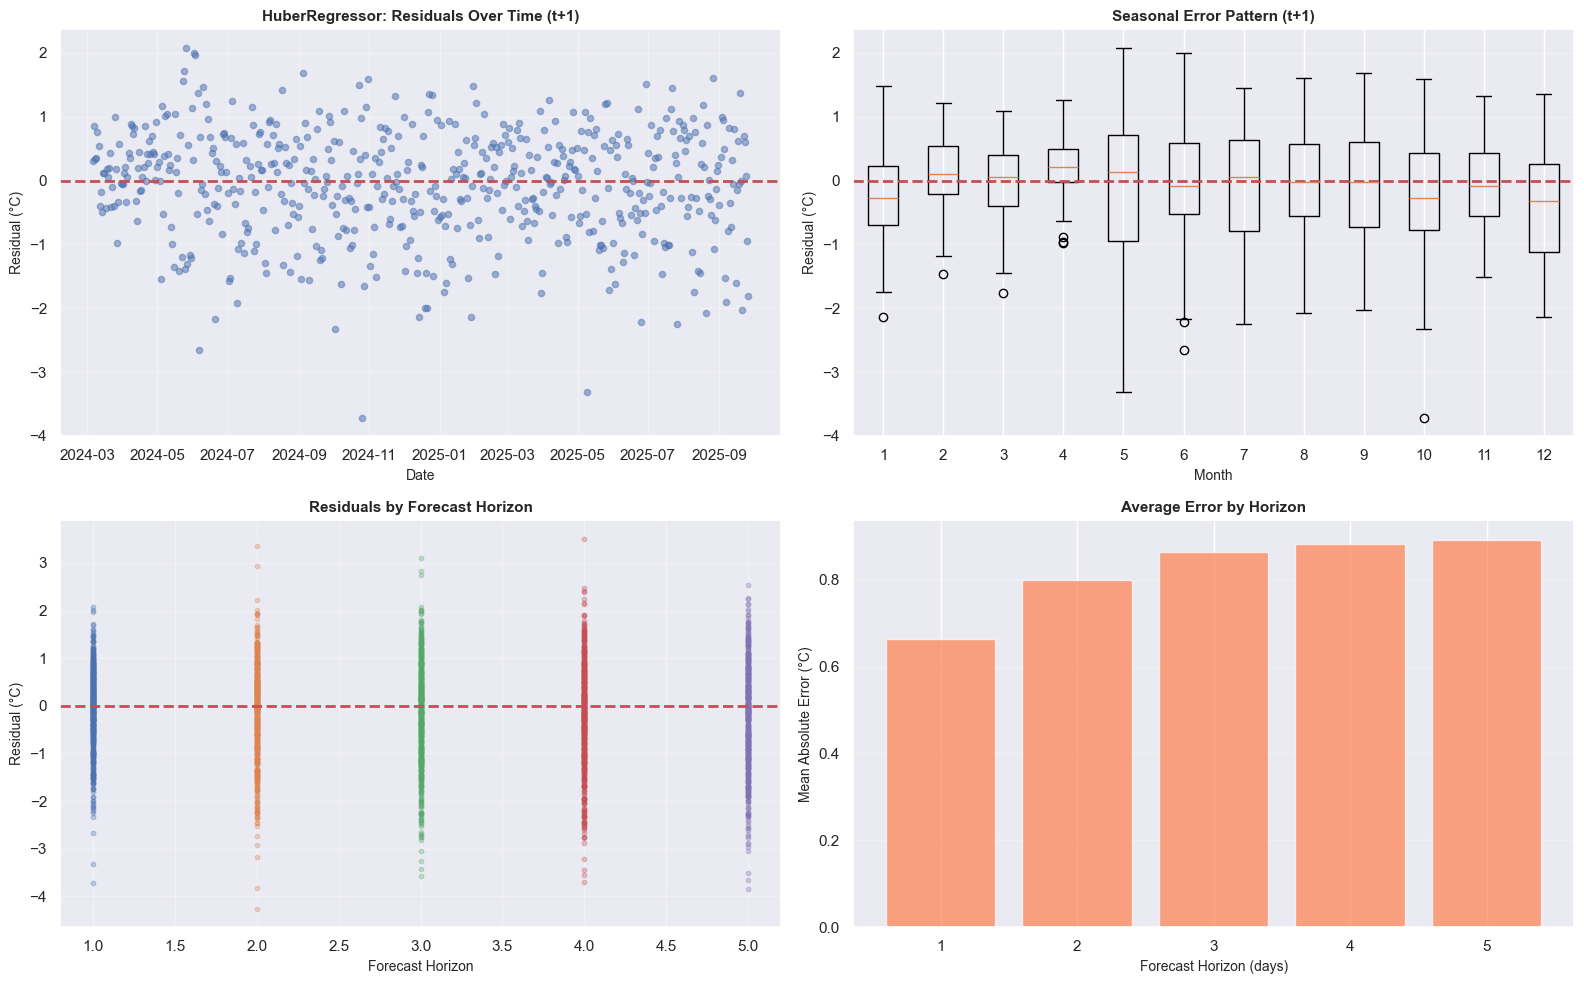


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: -0.0631°C
  Std Dev: 0.8451°C
  Skewness: -0.5390 (left-skewed)
  Kurtosis: 0.5723 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: -0.1351°C
  Std Dev: 1.0137°C
  Skewness: -0.3931 (left-skewed)
  Kurtosis: 0.4683 (heavy-tailed)
  ~ Moderate bias

Horizon t+3:
  Mean: -0.1896°C
  Std Dev: 1.0704°C
  Skewness: -0.2258 (left-skewed)
  Kurtosis: -0.0340 (light-tailed)
  ~ Moderate bias

Horizon t+4:
  Mean: -0.2386°C
  Std Dev: 1.0952°C
  Skewness: -0.2175 (left-skewed)
  Kurtosis: 0.0555 (heavy-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: -0.2361°C
  Std Dev: 1.0893°C
  Skewness: -0.2578 (left-skewed)
  Kurtosis: -0.1680 (light-tailed)
  ~ Moderate bias


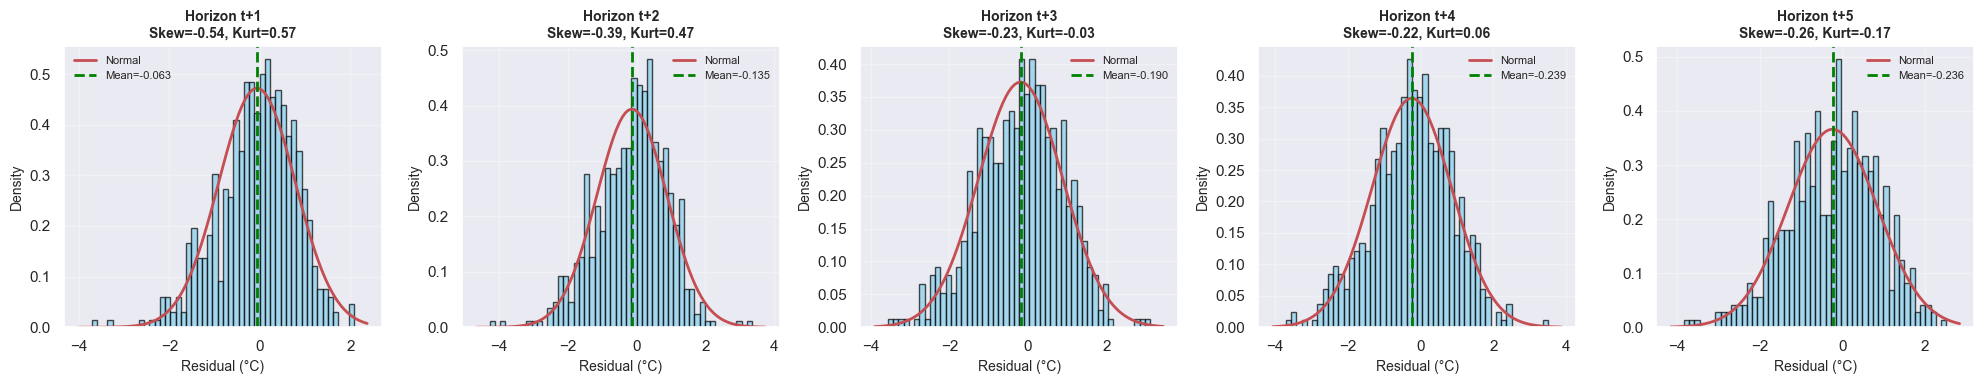


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.718094  0.003978  1.857962           2.503515  0.553978   
1     t+2   1.045929  0.018241  1.575724           2.510182  1.743999   
2     t+3   1.181760  0.035937  1.396129           2.513146  3.040957   
3     t+4   1.256417  0.056908  1.268655           2.513964  4.529402   
4     t+5   1.242385  0.055760  1.145154           2.519957  4.488124   

   Variance %  
0  258.735337  
1  150.652977  
2  118.139823  
3  100.974030  
4   92.173865

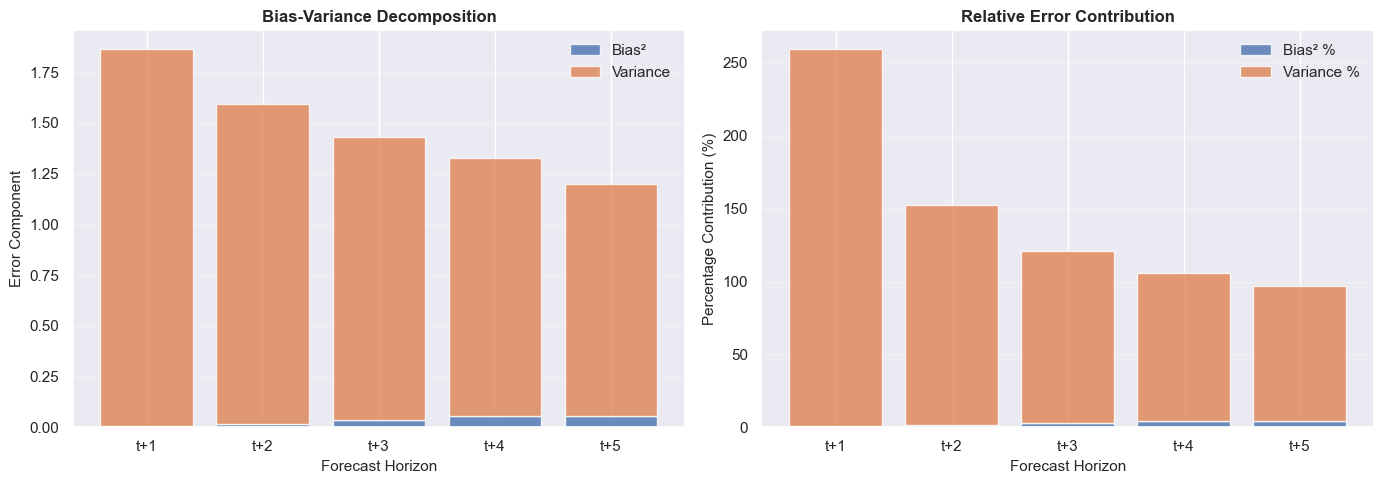


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [27]:
# Analyse Huber Regressor model
analyze_model_comprehensive(
     'HuberRegressor',
     model_results,
     X_train, X_test, y_train, y_test, test_dates
 )

In [28]:
# def huber_optuna_objective(trial):
#     params = {
#         'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True),
#         'epsilon': trial.suggest_float('epsilon', 1.1, 2.0)
#     }

#     estimator = MultiOutputRegressor(HuberRegressor(max_iter=1000, **params))
#     pipeline = make_pipeline(estimator)

#     fold_metrics = cross_val_evaluate(pipeline, X_train, y_train, tscv)
#     return float(np.mean([fold['RMSE_macro'] for fold in fold_metrics]))


# study_huber = optuna.create_study(direction='minimize', study_name='huber_hyperopt')
# study_huber.optimize(huber_optuna_objective, n_trials=20, timeout=600)

# print("Optimization finished!")
# print(f"Best CV Score (RMSE): {study_huber.best_value:.4f}")
# print("Best Hyperparameters found:")
# for key, value in study_huber.best_trial.params.items():
#     print(f"  - {key}: {value}")

best_huber_params = {
    'alpha': 0.6258952607607242,
    'epsilon': 1.5599425526665442
}

   - HuberRegressor_Optuna test RMSE_macro: 1.0088

OPTUNA HYPERPARAMETER TUNING COMPARISON


Metric  Base Model  Optuna Tuned  Improvement (%)
0  RMSE_macro    1.038544      1.008795         2.864517
1   MAE_macro    0.819906      0.800717         2.340348
2  MAPE_macro    2.888320      2.816834         2.475028
3    R2_macro    0.566693      0.591022        -4.293133


Per-Horizon RMSE Comparison:


Horizon  Base RMSE  Optuna RMSE  Improvement (%)
0     t+1   0.847404     0.820415         3.184949
1     t+2   1.022707     0.990255         3.173179
2     t+3   1.087088     1.060004         2.491396
3     t+4   1.120900     1.088728         2.870180
4     t+5   1.114623     1.084574         2.695907

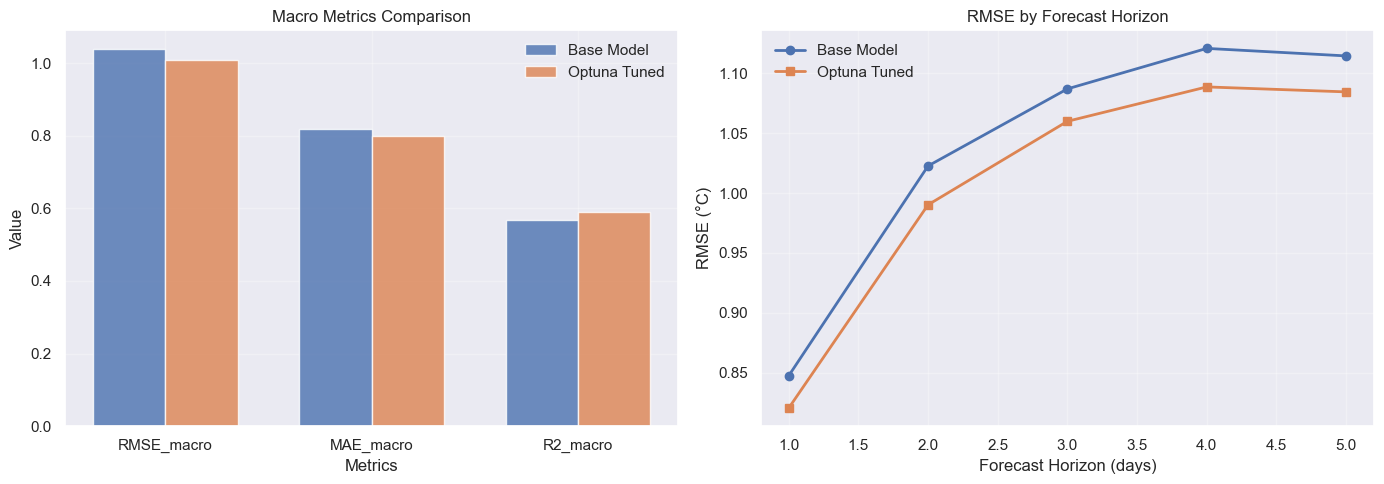


RECOMMENDATION:
~ Consider Optuna tuning (Marginal improvement: 0.85%)



In [29]:
tuned_huber_estimator = MultiOutputRegressor(
     HuberRegressor(max_iter=1000, **best_huber_params)
 )

tuned_huber_pipeline = make_pipeline(tuned_huber_estimator, numeric_cols=numeric_cols,
                                    categorical_cols=categorical_cols, text_cols=text_cols)
cv_fold_metrics = cross_val_evaluate(tuned_huber_pipeline, X_train, y_train, tscv, horizons=HORIZONS)
full_cv_metrics = aggregate_metrics(cv_fold_metrics)
tuned_huber_pipeline.fit(X_train, y_train)

model_name = 'HuberRegressor_Optuna'
train_pred = tuned_huber_pipeline.predict(X_train)
test_pred = tuned_huber_pipeline.predict(X_test)

model_results[model_name] = {
     'pipeline': tuned_huber_pipeline,
     'cv_metrics': full_cv_metrics,
     'train_metrics': compute_metrics(y_train.values, train_pred, HORIZONS),
     'test_metrics': compute_metrics(y_test.values, test_pred, HORIZONS),
     'predictions_test': test_pred,
     'predictions_train': train_pred,
     'details': f'Huber tuned with Optuna. Best params: {best_huber_params}'
 }
print(f"   - {model_name} test RMSE_macro: {model_results[model_name]['test_metrics']['RMSE_macro']:.4f}")

compare_optuna_performance(
     base_model_name='HuberRegressor',
     optuna_model_name='HuberRegressor_Optuna',
     model_results=model_results,
     horizons=HORIZONS
 )


COMPREHENSIVE ANALYSIS: HuberRegressor_Optuna

## 2. MODEL SPECIFICATION
Model: HuberRegressor_Optuna
Details: Huber tuned with Optuna. Best params: {'alpha': 0.6258952607607242, 'epsilon': 1.5599425526665442}

Hyperparameters:
  - alpha: 0.6258952607607242
  - epsilon: 1.5599425526665442
  - fit_intercept: True
  - max_iter: 1000
  - tol: 1e-05
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 1.0088

MAE:
  Value: 0.8007

MAPE:
  Value: 2.8168

R2:
  Value: 0.5910


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.820415  0.646964  2.268340  0.731146
1     t+2  0.990255  0.780256  2.744711  0.609349
2     t+3  1.060004  0.845940  2.974310  0.552907
3     t+4  1.088728  0.858667  3.025315  0.528502
4     t+5  1.084574  0.871758  3.071493  0.533206


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.882141  1.008795    0.126654           No
1   MAE_macro  0.682239  0.800717    0.118478           No
2    R2_macro  0.550127  0.591022    0.040895           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.0698
CV MAE (mean): 0.8370
CV R² (mean): 0.2624

[Note: Standard deviation would require storing individual fold results]


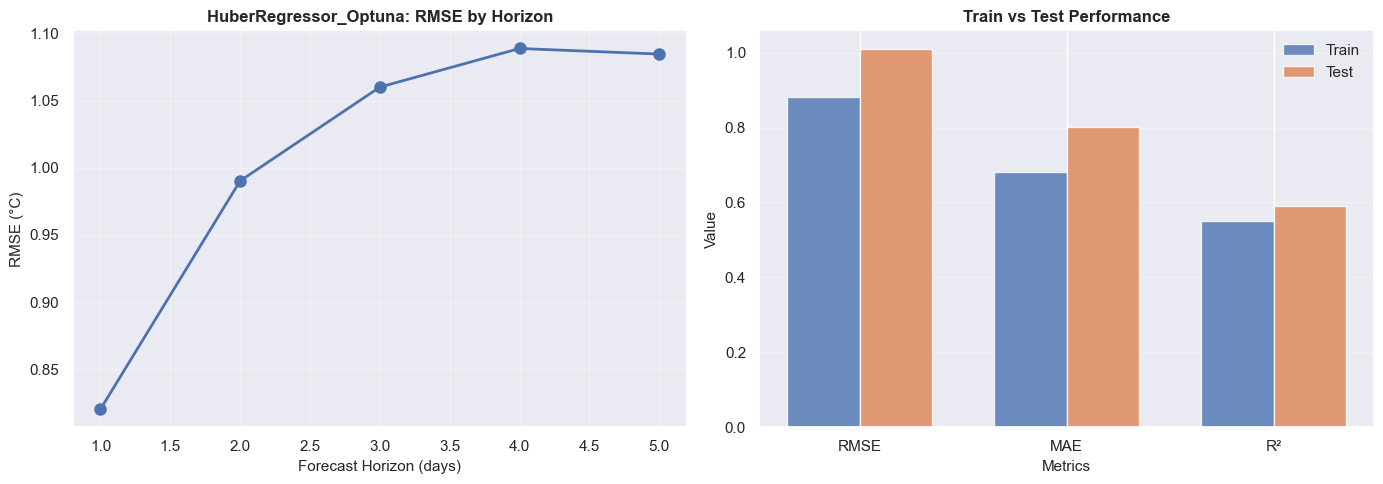


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.121669  0.822593     31
2      0.106251  0.647656     28
3      0.023433  0.585917     57
4      0.169647  0.522946     60
5     -0.068389  1.022941     62
6     -0.038782  0.940331     60
7     -0.040494  0.824041     62
8     -0.022628  0.847396     62
9     -0.093726  0.884282     56
10    -0.109594  0.971486     31
11     0.047490  0.682219     30
12    -0.158897  0.928559     31


High Error Periods (top 10% errors > 1.33°C):
Total occurrences: 57
Date range: 2024-05-04 00:00:00 to 2025-09-26 00:00:00


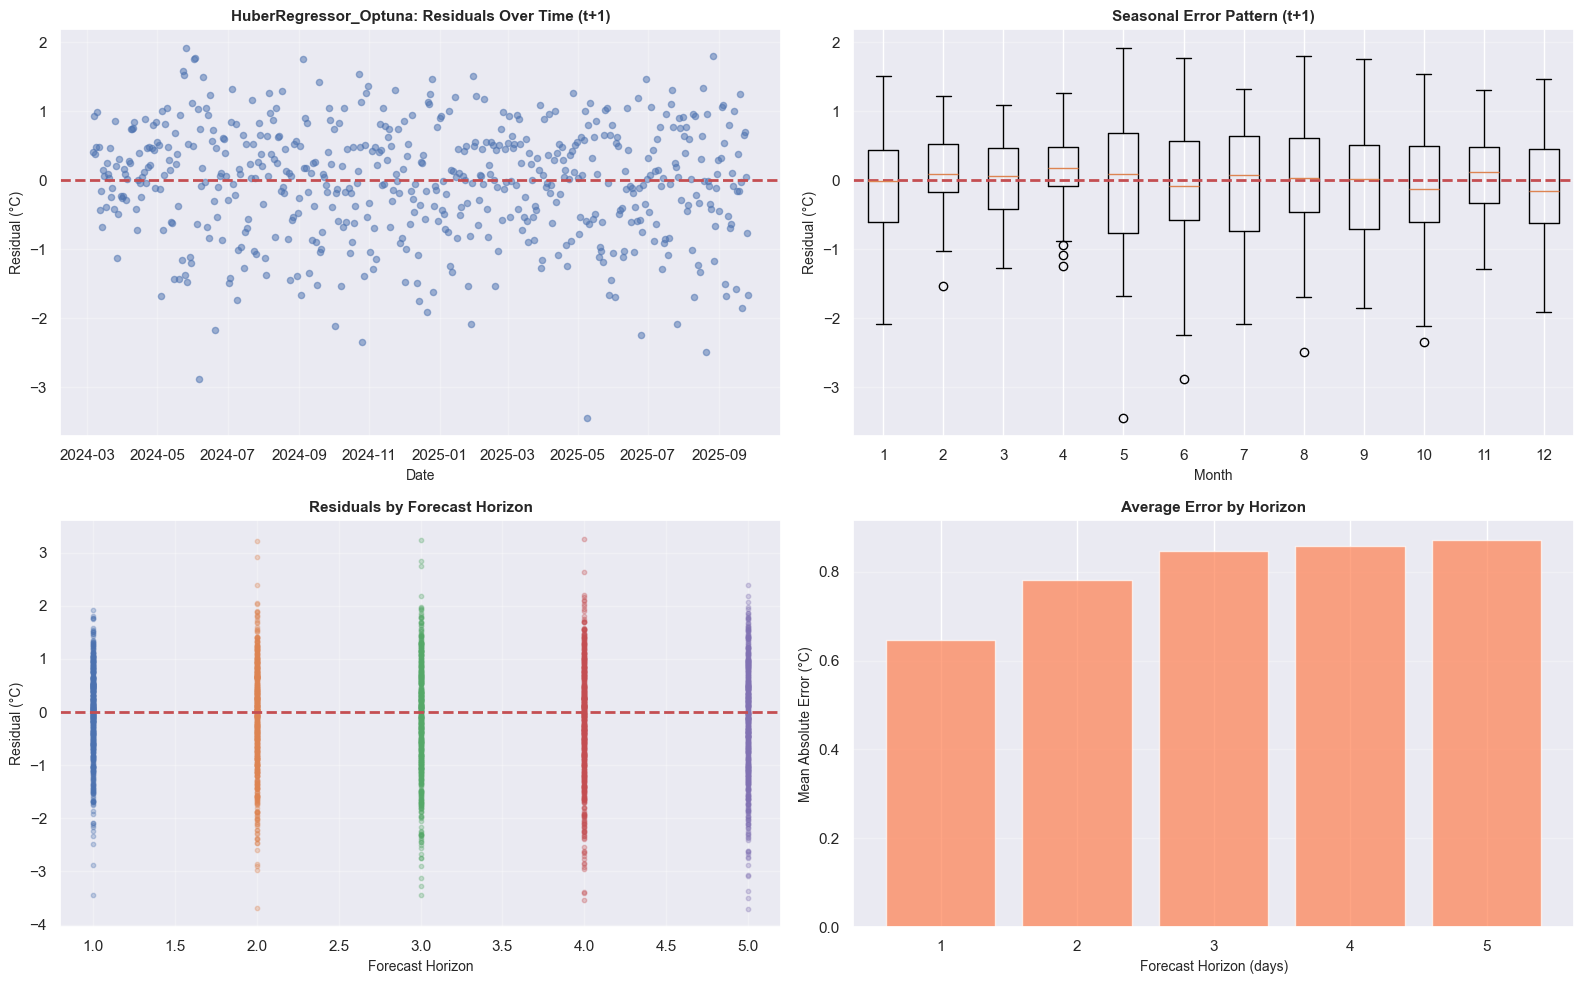


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: -0.0209°C
  Std Dev: 0.8201°C
  Skewness: -0.5035 (left-skewed)
  Kurtosis: 0.3441 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: -0.0852°C
  Std Dev: 0.9866°C
  Skewness: -0.3230 (left-skewed)
  Kurtosis: 0.1952 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+3:
  Mean: -0.1303°C
  Std Dev: 1.0520°C
  Skewness: -0.2184 (left-skewed)
  Kurtosis: -0.0466 (light-tailed)
  ~ Moderate bias

Horizon t+4:
  Mean: -0.1857°C
  Std Dev: 1.0728°C
  Skewness: -0.2671 (left-skewed)
  Kurtosis: -0.0062 (light-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: -0.1917°C
  Std Dev: 1.0675°C
  Skewness: -0.3093 (left-skewed)
  Kurtosis: -0.1864 (light-tailed)
  ~ Moderate bias


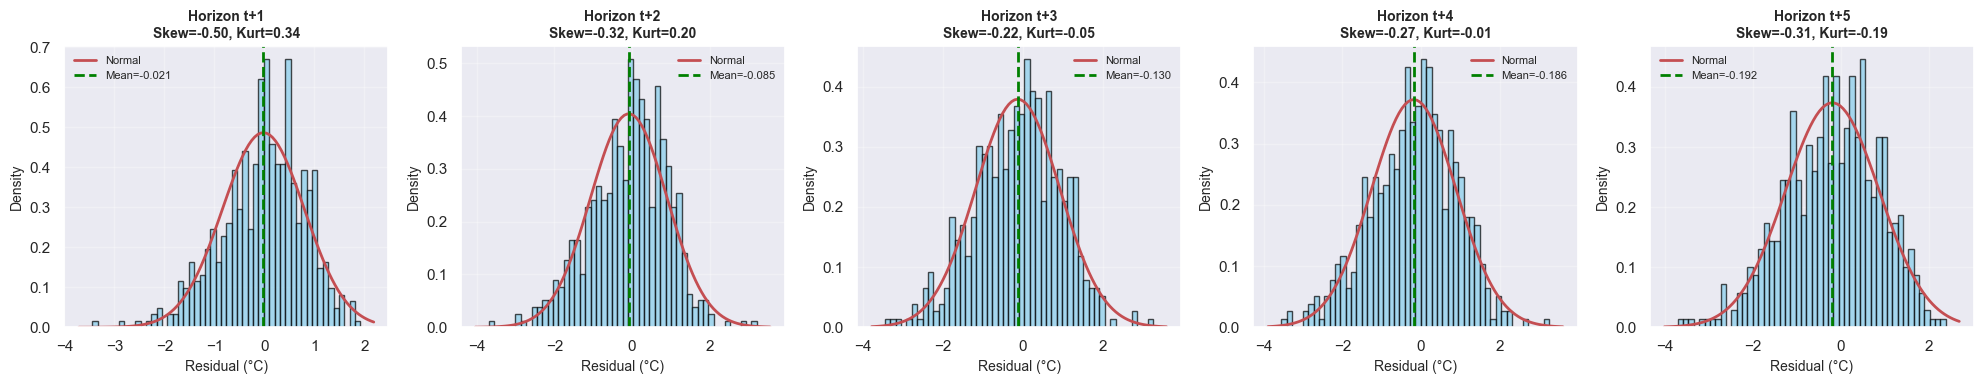


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.673080  0.000437  1.935477           2.503515  0.064864   
1     t+2   0.980604  0.007259  1.545364           2.510182  0.740260   
2     t+3   1.123609  0.016974  1.372354           2.513146  1.510703   
3     t+4   1.185329  0.034482  1.245630           2.513964  2.909047   
4     t+5   1.176301  0.036748  1.154605           2.519957  3.124072   

   Variance %  
0  287.555258  
1  157.593063  
2  122.138073  
3  105.087249  
4   98.155607

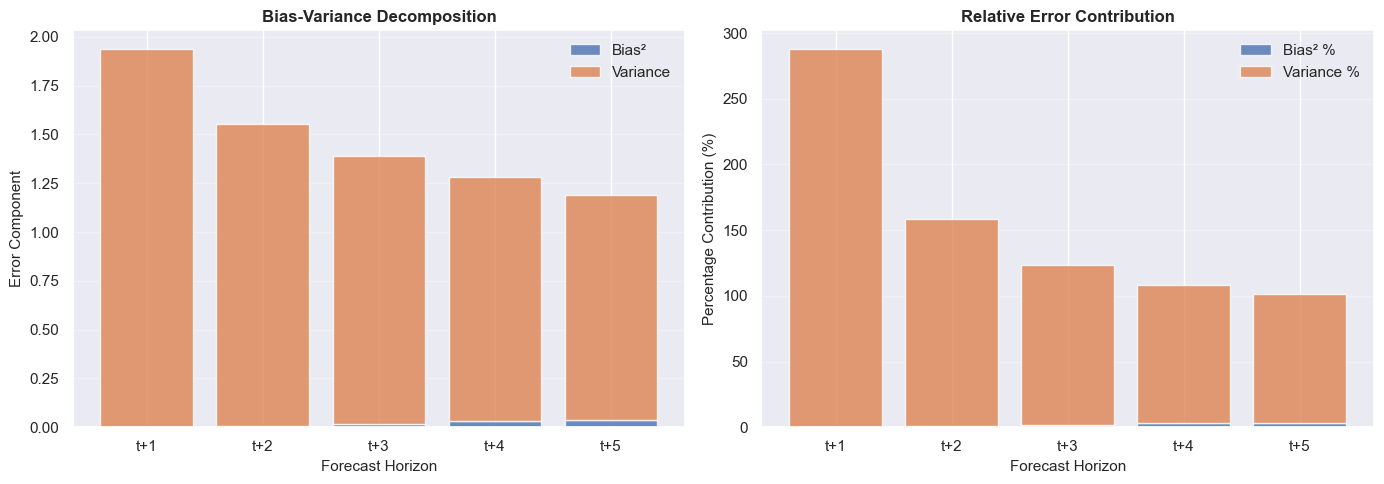


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [30]:
# Analyze the Optuna-tuned Huber Regressor model
analyze_model_comprehensive('HuberRegressor_Optuna', model_results, X_train, X_test, y_train, y_test, test_dates)

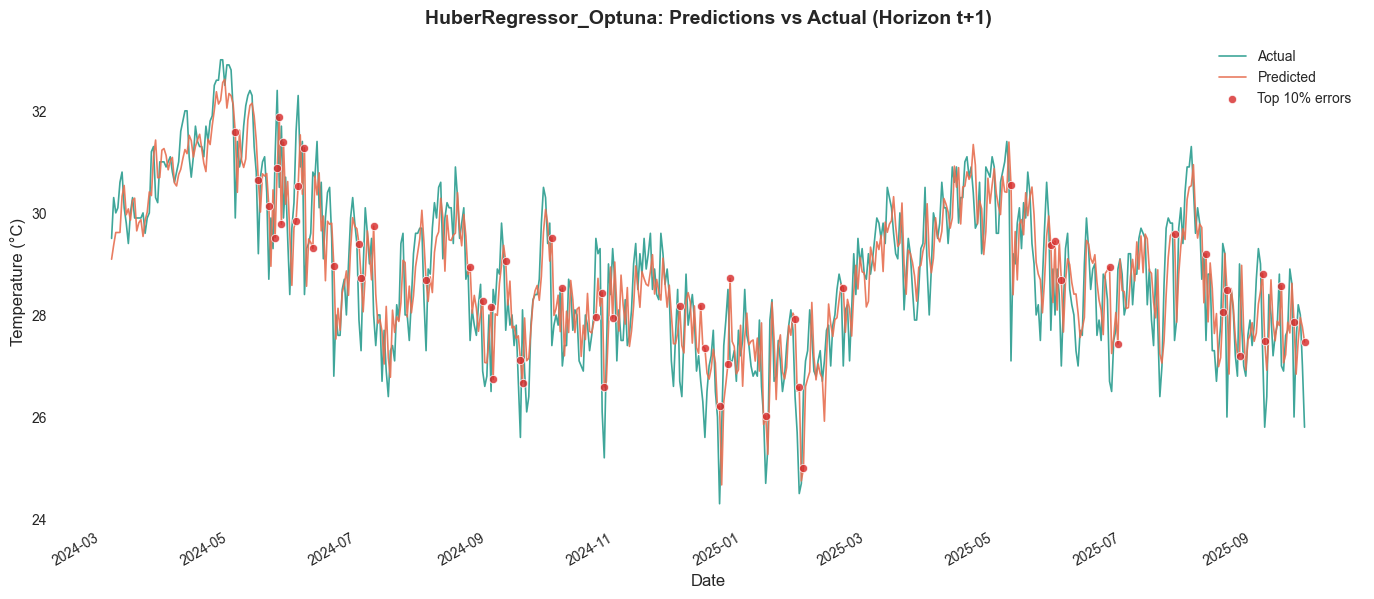

In [31]:
# Actual vs Predicted plot for Optuna-tuned Huber Regressor
model_name = 'HuberRegressor_Optuna'  # đổi theo model bạn muốn
base_model_plot(model_results, model_name, y_test, test_dates)

### **5.7. BayesianRidge**


COMPREHENSIVE ANALYSIS: BayesianRidge

## 2. MODEL SPECIFICATION
Model: BayesianRidge
Details: Sklearn pipeline with preprocessing.

Hyperparameters:
  - alpha_1: 1e-06
  - alpha_2: 1e-06
  - alpha_init: None
  - compute_score: False
  - copy_X: True
  - fit_intercept: True
  - lambda_1: 1e-06
  - lambda_2: 1e-06
  - lambda_init: None
  - max_iter: 300
  - tol: 0.001
  - verbose: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 0.9862

MAE:
  Value: 0.7893

MAPE:
  Value: 2.7672

R2:
  Value: 0.6095


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.807599  0.640272  2.242167  0.739480
1     t+2  0.974808  0.776160  2.721159  0.621442
2     t+3  1.040089  0.836248  2.929683  0.569549
3     t+4  1.056896  0.844580  2.961522  0.555670
4     t+5  1.051392  0.849375  2.981270  0.561332


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.893464  0.986157    0.092693           No
1   MAE_macro  0.701517  0.789327    0.087810           No
2    R2_macro  0.538452  0.609495    0.071042           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 0.9883
CV MAE (mean): 0.7745
CV R² (mean): 0.3804

[Note: Standard deviation would require storing individual fold results]


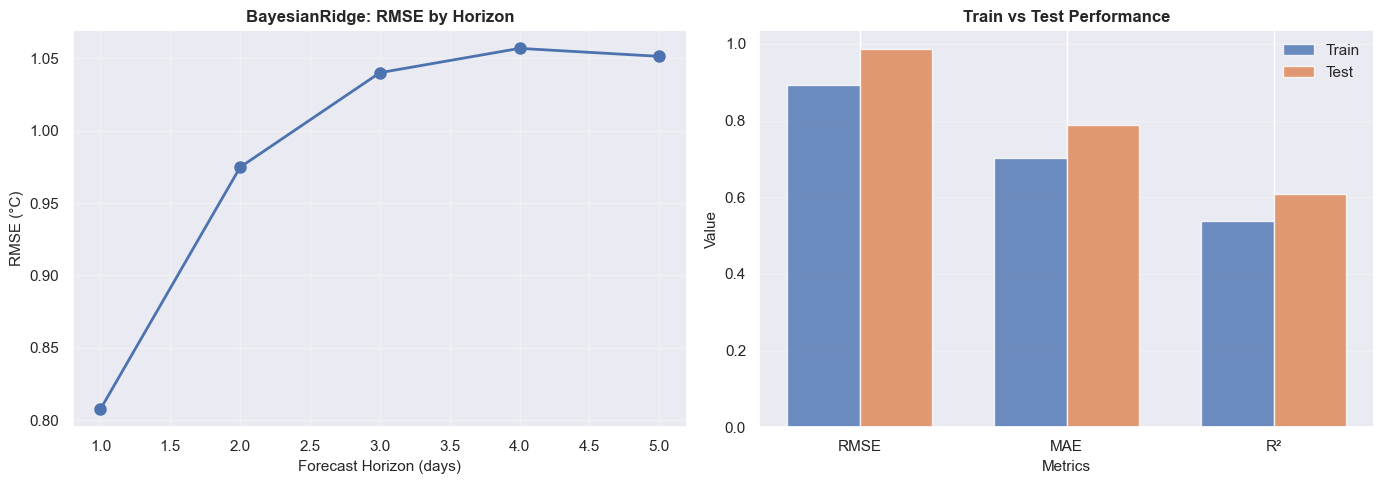


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.149523  0.798319     31
2      0.118328  0.634492     28
3      0.064570  0.545430     57
4      0.289096  0.499565     60
5     -0.014854  1.010546     62
6     -0.028462  0.920927     60
7      0.012640  0.813273     62
8      0.032020  0.823811     62
9     -0.027430  0.887347     56
10    -0.086985  0.978159     31
11     0.086895  0.643795     30
12    -0.135089  0.908152     31


High Error Periods (top 10% errors > 1.31°C):
Total occurrences: 57
Date range: 2024-05-04 00:00:00 to 2025-09-26 00:00:00


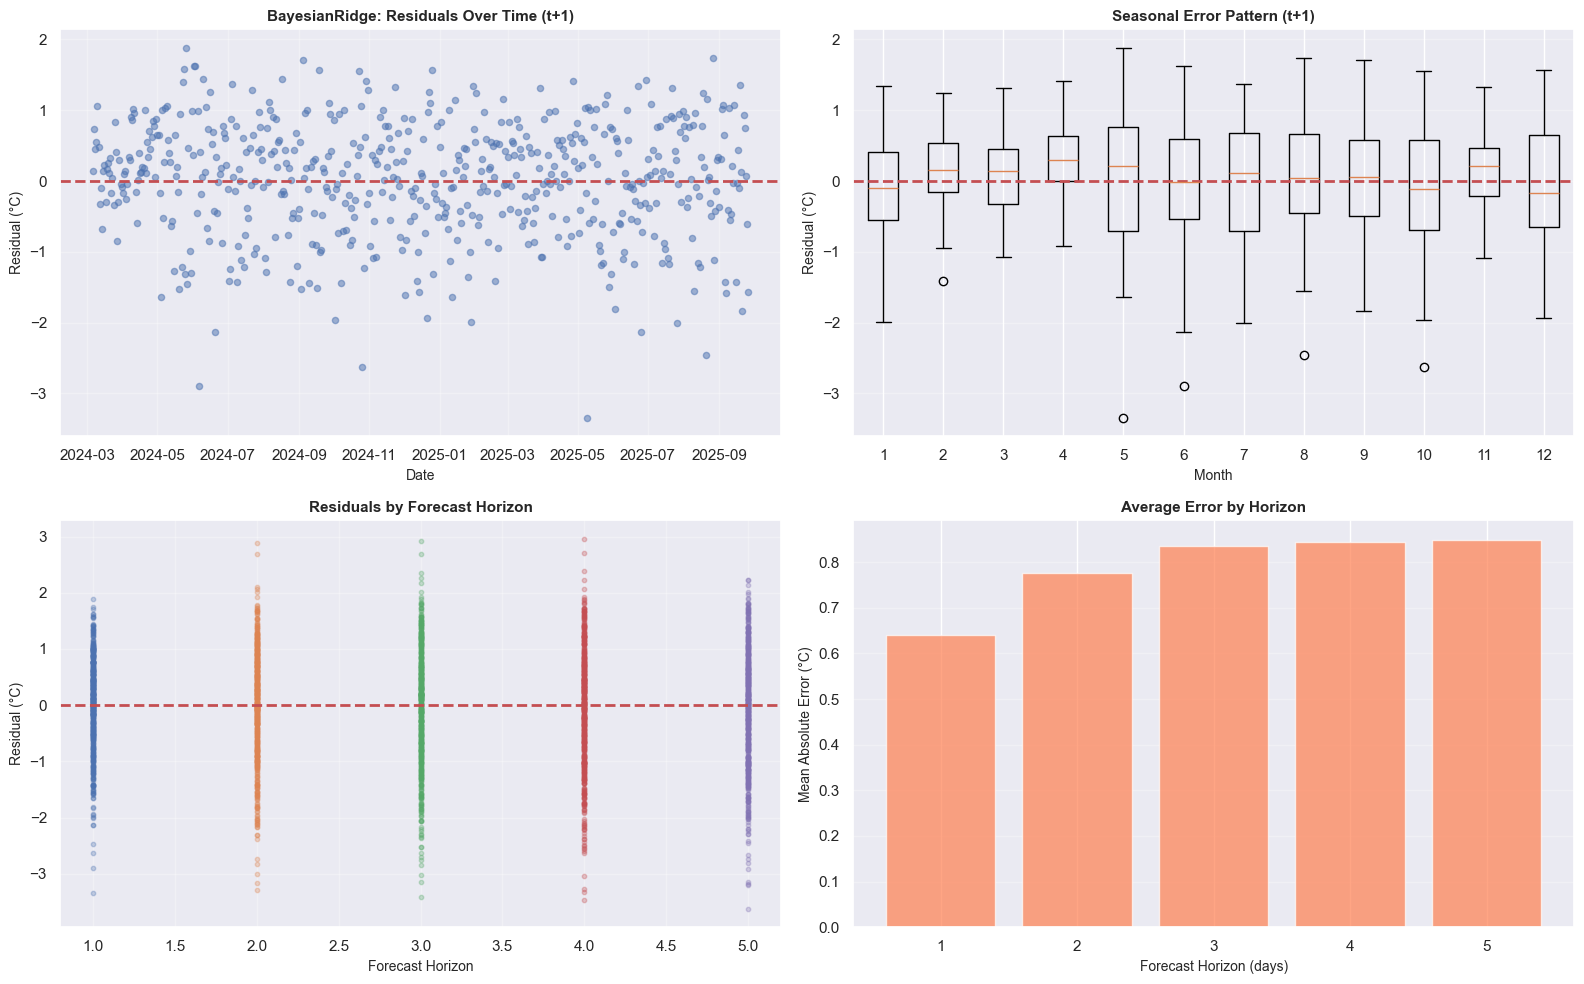


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.0246°C
  Std Dev: 0.8072°C
  Skewness: -0.5546 (left-skewed)
  Kurtosis: 0.4368 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: 0.0067°C
  Std Dev: 0.9748°C
  Skewness: -0.4213 (left-skewed)
  Kurtosis: 0.0961 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+3:
  Mean: -0.0297°C
  Std Dev: 1.0397°C
  Skewness: -0.3018 (left-skewed)
  Kurtosis: -0.1038 (light-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+4:
  Mean: -0.0651°C
  Std Dev: 1.0549°C
  Skewness: -0.3067 (left-skewed)
  Kurtosis: -0.0769 (light-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+5:
  Mean: -0.0972°C
  Std Dev: 1.0469°C
  Skewness: -0.3038 (left-skewed)
  Kurtosis: -0.2173 (light-tailed)
  ✓ Low bias (|mean| < 0.1°C)


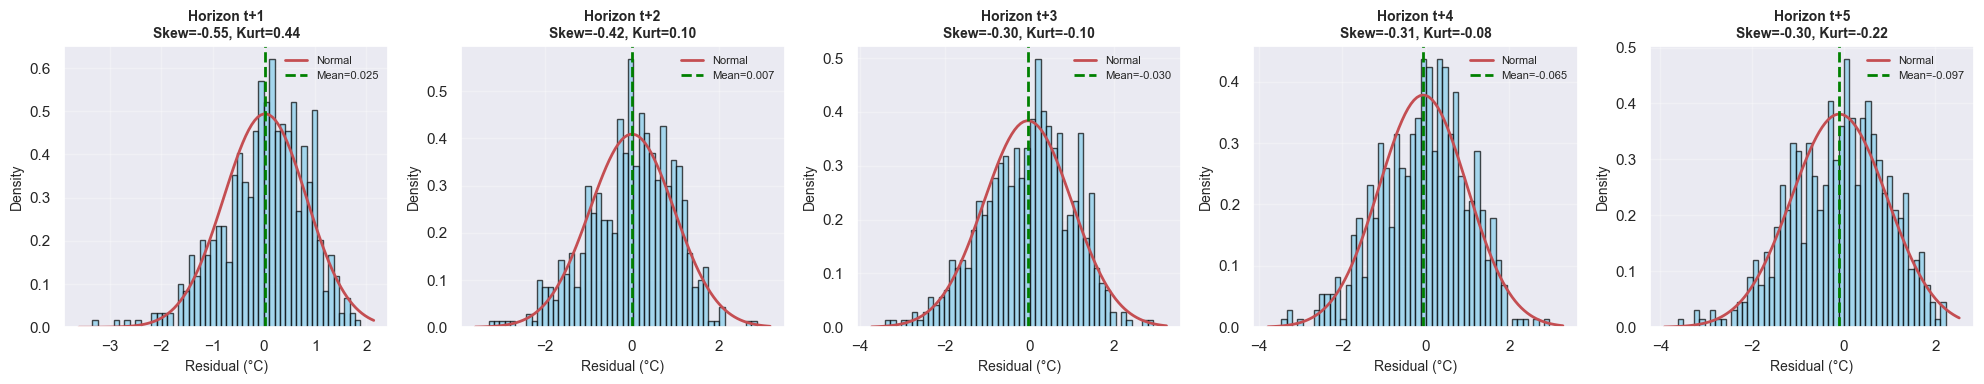


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.652216  0.000606  1.834478           2.503515  0.092904   
1     t+2   0.950250  0.000045  1.418257           2.510182  0.004735   
2     t+3   1.081785  0.000883  1.252976           2.513146  0.081633   
3     t+4   1.117030  0.004238  1.148276           2.513964  0.379382   
4     t+5   1.105425  0.009456  1.074280           2.519957  0.855415   

   Variance %  
0  281.268252  
1  149.250896  
2  115.824874  
3  102.797239  
4   97.182538

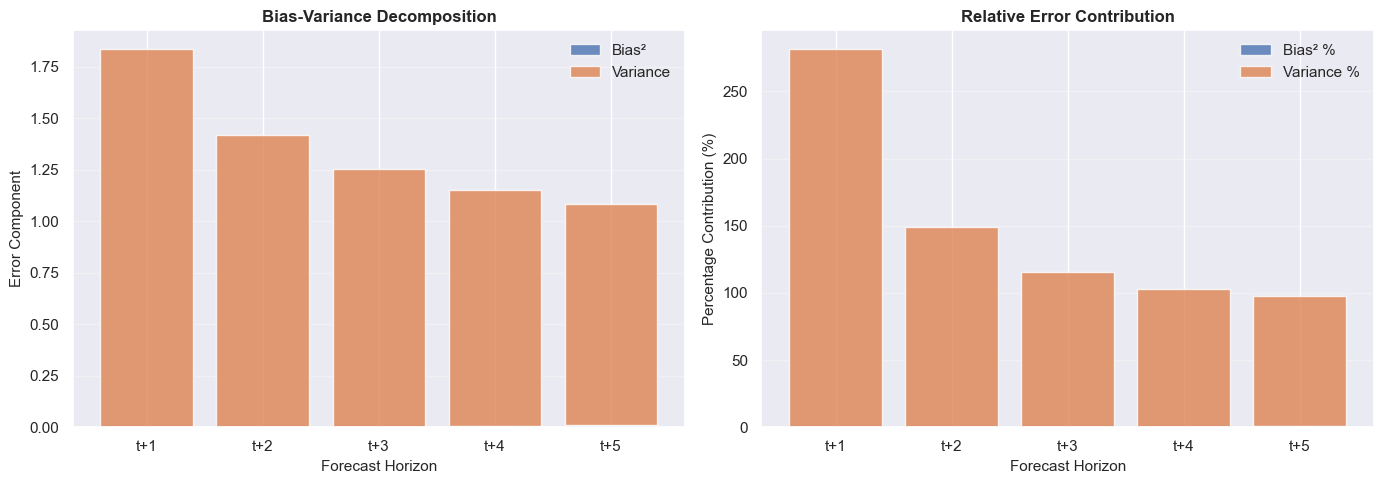


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [32]:
# Analyze Bayesian Ridge model
analyze_model_comprehensive('BayesianRidge', model_results, X_train, X_test,
                             y_train, y_test, test_dates, HORIZONS)


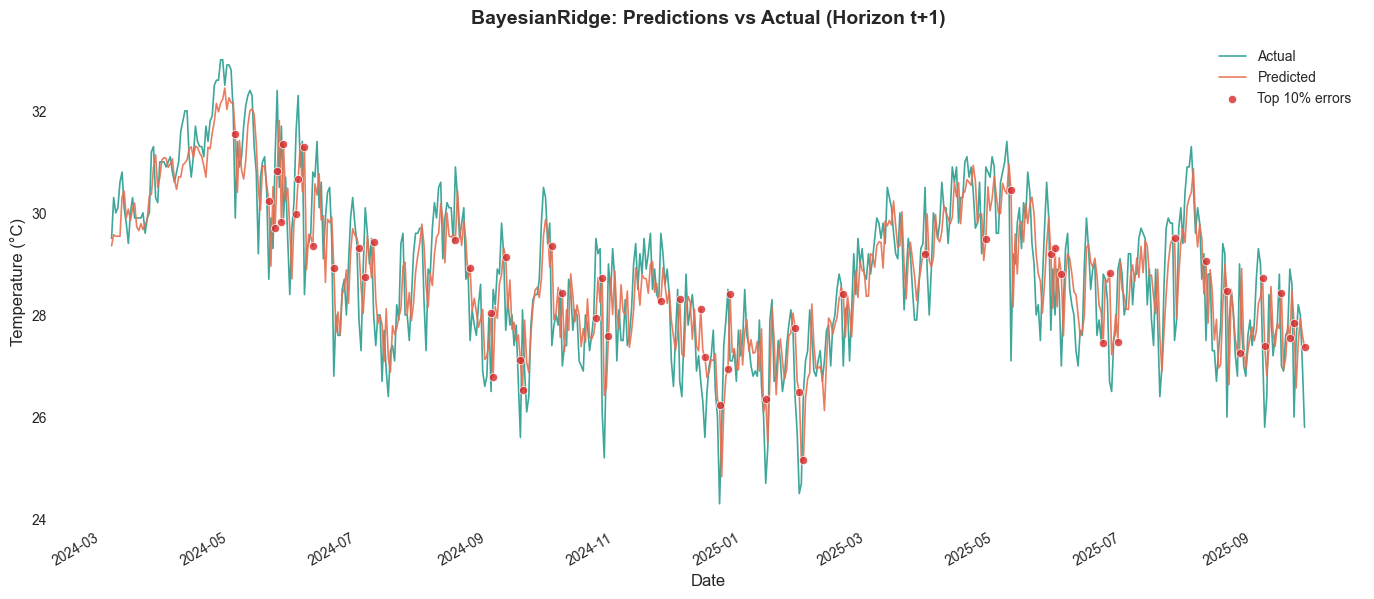

In [33]:
# Actual vs Predicted plot for Bayesian Ridge
model_name = 'BayesianRidge'  
base_model_plot(model_results, model_name, y_test, test_dates)

### **5.8. Feature Selection with MultiTaskLasso & Weighted Importance**

#### Why Feature Selection Matters

When building forecasting models, not all features contribute equally to prediction accuracy. Some features may:
- Add noise rather than signal
- Cause overfitting on training data
- Increase computational cost without improving performance
- Create multicollinearity issues

Feature selection helps us identify and keep only the **most predictive features**, leading to simpler, faster, and often more accurate models.

---

#### Our Approach: MultiTaskLasso with Weighted Selection

We use a specialized technique that combines three powerful concepts:

##### 1. **MultiTaskLasso** (Exploits Output Correlation)
- Standard Lasso works on single outputs (one target variable)
- **MultiTaskLasso** is designed for **multi-output regression** (predicting 5 horizons simultaneously)
- It finds features that are important **across all forecast horizons** by sharing information between tasks
- This is perfect for weather forecasting where Day 1, Day 2, ..., Day 5 temperatures are highly correlated

##### 2. **Nested Cross-Validation** (Prevents Data Leakage)
- We perform feature selection **inside each CV fold** rather than once on the full dataset
- This ensures features are selected based only on training data, preventing information leakage
- More reliable estimate of model performance on unseen data

##### 3. **Weighted Feature Importance** (Prioritizes Stable Targets)
- Not all forecast horizons are equally predictable
- Day 1 forecasts are typically more stable than Day 5 forecasts
- We weight each horizon's coefficient by its **inverse variance**:
  - More stable targets (low variance) → higher weight
  - More volatile targets (high variance) → lower weight
- This prevents noisy long-term horizons from dominating feature selection

---


In [34]:
from sklearn.linear_model import ElasticNetCV, MultiTaskLassoCV, BayesianRidge, HuberRegressor
from sklearn.preprocessing import StandardScaler

# Preprocess features once
preprocessor = build_preprocessor(numeric_cols=numeric_cols,
                                  categorical_cols=categorical_cols,
                                  text_cols=text_cols)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
if hasattr(X_train_processed, 'toarray'):
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

# Standardize targets (important for consistent alpha values)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values)
y_test_scaled = y_scaler.transform(y_test.values)

# --- 1. Baseline models ---
baseline_results = []
for model_name in ['LinearRegression', 'BayesianRidge', 'HuberRegressor']:
    baseline_results.append({
        'Model': model_name,
        'CV_RMSE': model_results[model_name]['cv_metrics']['RMSE_macro'],
        'Test_RMSE': model_results[model_name]['test_metrics']['RMSE_macro'],
        'Features': 'All',
        'Method': 'Baseline'
    })

# --- 2. Feature selection with nested CV ---
print("\n1. Feature Selection with MultiTaskLassoCV (exploits output correlation)")

n_select = 75
alphas = np.logspace(-4, 1, 30)
inner_cv = ModTimeSeriesSplit(n_splits=3, buffer=LEAKAGE_BUFFER)

linear_models = {
    'LinearRegression_Lasso': ElasticNetCV(l1_ratio=[0.5, 0.7, 0.9], alphas=alphas, 
                                           cv=inner_cv, max_iter=5000, n_jobs=-1),
    'BayesianRidge_Lasso': BayesianRidge(),
    'HuberRegressor_Lasso': HuberRegressor()
}

lasso_results = []

for model_name, base_estimator in linear_models.items():
    print(f"   Training {model_name}...")
    
    cv_scores = []
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_train_processed)):
        X_tr, X_val = X_train_processed[train_idx], X_train_processed[val_idx]
        y_tr, y_val = y_train_scaled[train_idx], y_train_scaled[val_idx]
        
        # Use MultiTaskLassoCV for better multi-output feature selection
        mtl_cv = MultiTaskLassoCV(alphas=alphas, cv=inner_cv, n_jobs=-1, max_iter=5000)
        mtl_cv.fit(X_tr, y_tr)
        
        # Get coefficients and compute weighted importance
        coefs = mtl_cv.coef_  # shape: (n_outputs, n_features)
        
        # Weight by inverse variance of each target (more stable targets get higher weight)
        target_vars = np.var(y_tr, axis=0) + 1e-6
        weights = 1.0 / target_vars
        weights = weights / weights.sum()  # normalize
        
        # Weighted average of absolute coefficients
        avg_abs_coef = np.average(np.abs(coefs), axis=0, weights=weights)
        
        # Select top features
        top_indices = np.argsort(avg_abs_coef)[-n_select:]
        selected_mask = np.zeros(len(avg_abs_coef), dtype=bool)
        selected_mask[top_indices] = True
        
        # Train model with selected features
        X_tr_selected = X_tr[:, selected_mask]
        X_val_selected = X_val[:, selected_mask]
        
        if 'ElasticNet' in str(type(base_estimator)):
            estimator = MultiOutputRegressor(base_estimator)
            estimator.fit(X_tr_selected, y_tr)
        else:
            estimator = MultiOutputRegressor(base_estimator)
            estimator.fit(X_tr_selected, y_tr)
        
        val_pred_scaled = estimator.predict(X_val_selected)
        
        # Convert back to original scale for evaluation
        val_pred = y_scaler.inverse_transform(val_pred_scaled)
        y_val_original = y_scaler.inverse_transform(y_val)
        
        cv_scores.append(compute_metrics(y_val_original, val_pred, HORIZONS)['RMSE_macro'])
    
    cv_rmse = np.mean(cv_scores)
    
    # Final model: feature selection on full training set
    mtl_final = MultiTaskLassoCV(alphas=alphas, cv=inner_cv, n_jobs=-1, max_iter=5000)
    mtl_final.fit(X_train_processed, y_train_scaled)
    
    coefs_final = mtl_final.coef_
    target_vars_final = np.var(y_train_scaled, axis=0) + 1e-6
    weights_final = 1.0 / target_vars_final
    weights_final = weights_final / weights_final.sum()
    
    avg_abs_coef_final = np.average(np.abs(coefs_final), axis=0, weights=weights_final)
    
    top_indices_final = np.argsort(avg_abs_coef_final)[-n_select:]
    selected_mask_final = np.zeros(len(avg_abs_coef_final), dtype=bool)
    selected_mask_final[top_indices_final] = True
    
    X_train_selected = X_train_processed[:, selected_mask_final]
    X_test_selected = X_test_processed[:, selected_mask_final]
    
    # Train final model
    if 'ElasticNet' in str(type(base_estimator)):
        final_estimator = MultiOutputRegressor(base_estimator)
    else:
        final_estimator = MultiOutputRegressor(base_estimator)
    
    final_estimator.fit(X_train_selected, y_train_scaled)
    
    test_pred_scaled = final_estimator.predict(X_test_selected)
    train_pred_scaled = final_estimator.predict(X_train_selected)
    
    # Convert back to original scale
    test_pred = y_scaler.inverse_transform(test_pred_scaled)
    train_pred = y_scaler.inverse_transform(train_pred_scaled)
    
    model_results[model_name] = {
        'cv_metrics': {'RMSE_macro': cv_rmse},
        'train_metrics': compute_metrics(y_train.values, train_pred, HORIZONS),
        'test_metrics': compute_metrics(y_test.values, test_pred, HORIZONS),
        'predictions_test': test_pred,
        'predictions_train': train_pred,
        'details': f'MultiTaskLasso + top {n_select} features (weighted)'
    }
    
    test_rmse = model_results[model_name]['test_metrics']['RMSE_macro']
    lasso_results.append({
        'Model': model_name,
        'CV_RMSE': cv_rmse,
        'Test_RMSE': test_rmse,
        'Features': n_select,
        'Method': 'MultiTask+Weighted'
    })

# --- 3. Display comparison ---
all_results = baseline_results + lasso_results
comparison_df = pd.DataFrame(all_results)
print(comparison_df.to_string(index=False))


1. Feature Selection with MultiTaskLassoCV (exploits output correlation)
   Training LinearRegression_Lasso...
   Training BayesianRidge_Lasso...
   Training HuberRegressor_Lasso...
                 Model  CV_RMSE  Test_RMSE Features             Method
      LinearRegression 1.245348   0.999279      All           Baseline
         BayesianRidge 0.988254   0.986157      All           Baseline
        HuberRegressor 1.119155   1.038544      All           Baseline
LinearRegression_Lasso 0.965374   0.989010       75 MultiTask+Weighted
   BayesianRidge_Lasso 0.972958   0.985129       75 MultiTask+Weighted
  HuberRegressor_Lasso 0.998570   0.993703       75 MultiTask+Weighted


TOP 10 MOST IMPORTANT FEATURES (MultiTaskLasso + Weighted Selection)

✅ Filtered out 103 potentially leaking features
✅ Remaining safe features: 138

✅ VALID FEATURES (No Data Leakage - All Historical)

                Feature              Type  Importance
       temp_rollmean_14    🌡️ Temp (Roll)    0.076247
sealevelpressure_lag_14  🌤️ Weather (Lag)    0.067701
  windspeed_rollmean_14 🌤️ Weather (Roll)    0.047975
        humidity_lag_14  🌤️ Weather (Lag)    0.039509
             temp_lag_2     🌡️ Temp (Lag)    0.027800
     feelslikemin_lag_2           📊 Other    0.025610
   humidity_rollmean_14 🌤️ Weather (Roll)    0.025333
     feelslikemin_lag_1           📊 Other    0.023507
    windspeedmean_lag_1  🌤️ Weather (Lag)    0.023272
    windspeedmean_lag_7  🌤️ Weather (Lag)    0.023145


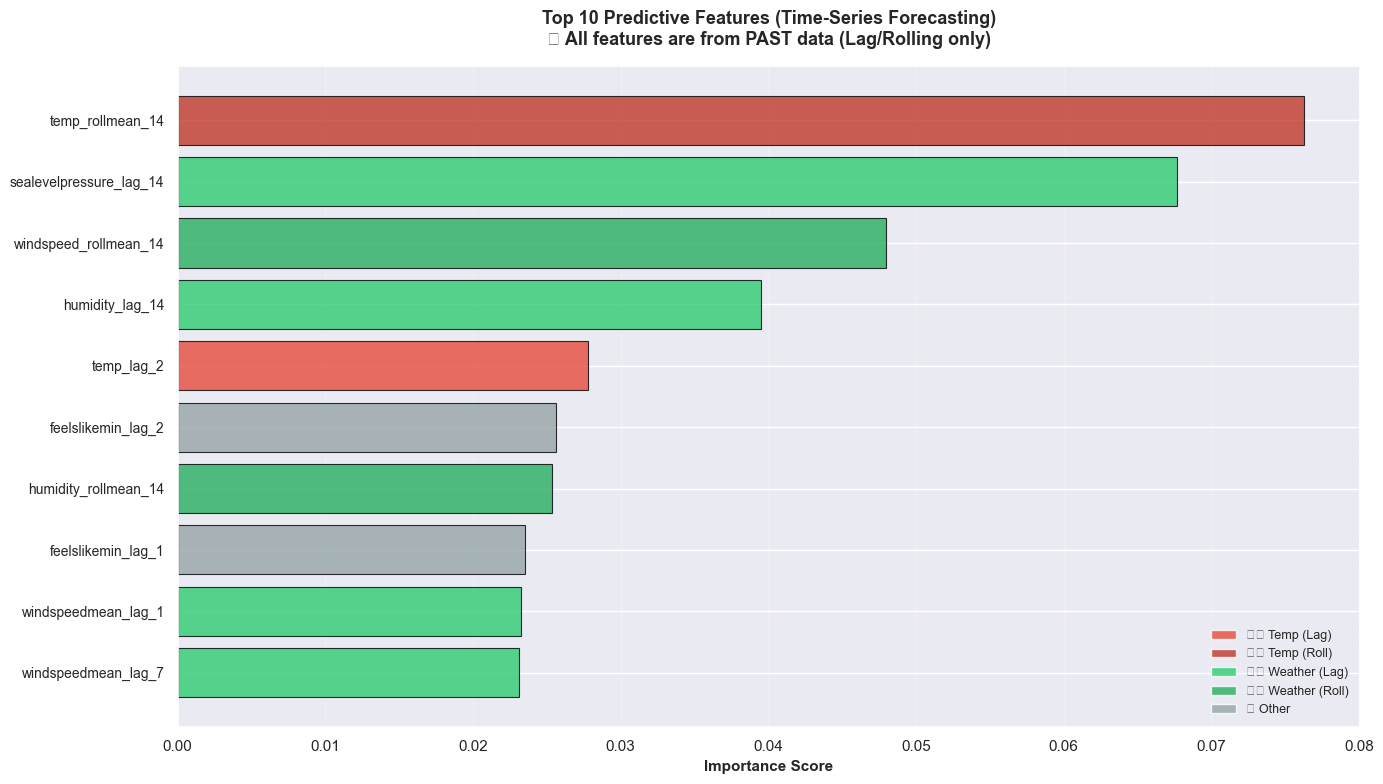

In [35]:
# Display Top 10 Features with Proper Context - FIXED VERSION

print("="*80)
print("TOP 10 MOST IMPORTANT FEATURES (MultiTaskLasso + Weighted Selection)")
print("="*80)

model_name = 'LinearRegression_Lasso'

if model_name in model_results:
    preprocessor = build_preprocessor(numeric_cols=numeric_cols,
                                       categorical_cols=categorical_cols,
                                       text_cols=text_cols)
    X_train_processed = preprocessor.fit_transform(X_train)
    if hasattr(X_train_processed, 'toarray'):
        X_train_processed = X_train_processed.toarray()
    
    # Get feature names
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            try:
                cat_features = transformer.named_steps['onehot'].get_feature_names_out(cols)
                feature_names.extend(cat_features)
            except:
                feature_names.extend(cols)
        elif name == 'text':
            try:
                text_features = transformer.named_steps['tfidf'].get_feature_names_out()
                feature_names.extend([f"text_{f}" for f in text_features])
            except:
                feature_names.extend([f"text_{i}" for i in range(len(cols))])
    
    # FIX: Ensure feature_names matches the actual number of features
    if len(feature_names) != X_train_processed.shape[1]:
        print(f"⚠ Warning: Feature count mismatch. Expected {X_train_processed.shape[1]}, got {len(feature_names)}")
        if len(feature_names) < X_train_processed.shape[1]:
            feature_names.extend([f'feature_{i}' for i in range(len(feature_names), X_train_processed.shape[1])])
        else:
            feature_names = feature_names[:X_train_processed.shape[1]]
    
    # Run feature selection
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values)
    
    alphas = np.logspace(-4, 1, 30)
    inner_cv = ModTimeSeriesSplit(n_splits=3, buffer=LEAKAGE_BUFFER)
    
    mtl_cv = MultiTaskLassoCV(alphas=alphas, cv=inner_cv, n_jobs=-1, max_iter=5000)
    mtl_cv.fit(X_train_processed, y_train_scaled)
    
    coefs = mtl_cv.coef_
    target_vars = np.var(y_train_scaled, axis=0) + 1e-6
    weights = 1.0 / target_vars
    weights = weights / weights.sum()
    
    avg_abs_coef = np.average(np.abs(coefs), axis=0, weights=weights)
    
    n_features = min(len(feature_names), len(avg_abs_coef))
    
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names[:n_features],
        'Importance': avg_abs_coef[:n_features]
    }).sort_values('Importance', ascending=False)

    
    # Keep only features that are explicitly lag or rolling features
    safe_feature_importance = feature_importance[
        feature_importance['Feature'].str.contains('lag_|roll', case=False, regex=True)
    ].copy()
    
    print(f"\n✅ Filtered out {len(feature_importance) - len(safe_feature_importance)} potentially leaking features")
    print(f"✅ Remaining safe features: {len(safe_feature_importance)}")
    
    # Categorize features
    top_10 = safe_feature_importance.head(10).copy()
    top_10['Type'] = top_10['Feature'].apply(lambda x: 
        '🌡️ Temp (Lag)' if 'temp' in x.lower() and 'lag' in x else
        '🌡️ Temp (Roll)' if 'temp' in x.lower() and 'roll' in x else
        '📅 Time/Seasonal' if any(t in x for t in ['sin_', 'cos_', 'sunrise', 'month', 'day']) else
        '🌤️ Weather (Lag)' if 'lag' in x and any(w in x for w in ['humidity', 'pressure', 'wind', 'cloud']) else
        '🌤️ Weather (Roll)' if 'roll' in x and any(w in x for w in ['humidity', 'pressure', 'wind', 'cloud']) else
        '💧 Precipitation' if 'precip' in x else
        '🔆 Solar' if 'solar' in x or 'uv' in x else
        '📊 Other'
    )
    
    print("\n✅ VALID FEATURES (No Data Leakage - All Historical)\n")
    print(top_10[['Feature', 'Type', 'Importance']].to_string(index=False))
    
    # Visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    
    colors = {
        '🌡️ Temp (Lag)': '#e74c3c',
        '🌡️ Temp (Roll)': '#c0392b',
        '📅 Time/Seasonal': '#3498db', 
        '🌤️ Weather (Lag)': '#2ecc71',
        '🌤️ Weather (Roll)': '#27ae60',
        '💧 Precipitation': '#9b59b6',
        '🔆 Solar': '#f39c12',
        '📊 Other': '#95a5a6'
    }
    
    bar_colors = [colors.get(t, '#95a5a6') for t in top_10['Type']]
    
    bars = ax.barh(range(10), top_10['Importance'].values[::-1], 
                   color=bar_colors[::-1], alpha=0.8, edgecolor='black', linewidth=0.8)
    
    ax.set_yticks(range(10))
    ax.set_yticklabels(top_10['Feature'].values[::-1], fontsize=10)
    ax.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
    ax.set_title('Top 10 Predictive Features (Time-Series Forecasting)\n✅ All features are from PAST data (Lag/Rolling only)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=label, alpha=0.8) 
                      for label, color in colors.items() if label in top_10['Type'].values]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9, framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Model '{model_name}' not found.")

### **5.9. Ensemble model**
- For our ensemble model,  for simplicity we will  use   the base model with full set of features

#### **a. Ensemble of BayesianRidge and HGB**

In [36]:
# --- Ensemble of BayesianRidge and HistGradientBoosting_Optuna ---

ensemble_sources = ['BayesianRidge', 'HistGradientBoosting_Optuna']
available_ensemble = [name for name in ensemble_sources if name in model_results]

if len(available_ensemble) == 2:
    ensemble_test_preds = np.mean([model_results[name]['predictions_test'] for name in available_ensemble], axis=0)
    ensemble_train_preds = np.mean([model_results[name]['predictions_train'] for name in available_ensemble], axis=0)
    model_results['BayesianRidge_HGB_Ensemble'] = {
        'train_metrics': compute_metrics(y_train.values, ensemble_train_preds, HORIZONS),
        'test_metrics': compute_metrics(y_test.values, ensemble_test_preds, HORIZONS),
        'cv_metrics': None,
        'predictions_train': ensemble_train_preds,
        'predictions_test': ensemble_test_preds,
        'details': f'Simple average ensemble of: {available_ensemble}'
    }
    print(f"BayesianRidge + HistGradientBoosting_Optuna ensemble test RMSE_macro: {model_results['BayesianRidge_HGB_Ensemble']['test_metrics']}")
else:
    print('Ensemble skipped: required models missing.')

BayesianRidge + HistGradientBoosting_Optuna ensemble test RMSE_macro: {'RMSE_h1': 0.7894331877262016, 'MAE_h1': 0.6253257290684683, 'MAPE_h1': 2.1887680363418474, 'R2_h1': 0.7510680879128807, 'RMSE_h2': 0.9511491979334595, 'MAE_h2': 0.7584694658139409, 'MAPE_h2': 2.6609951112802324, 'R2_h2': 0.6395939776543937, 'RMSE_h3': 1.0188843967168955, 'MAE_h3': 0.8143221752627399, 'MAPE_h3': 2.8565469915517463, 'R2_h3': 0.5869219410274054, 'RMSE_h4': 1.0375767471528483, 'MAE_h4': 0.8264198109446582, 'MAPE_h4': 2.902868824178266, 'R2_h4': 0.5717657094293174, 'RMSE_h5': 1.0371703474318097, 'MAE_h5': 0.8306065968603353, 'MAPE_h5': 2.9208546139227964, 'R2_h5': 0.5731187029715081, 'RMSE_macro': 0.966842775392243, 'MAE_macro': 0.7710287555900285, 'MAPE_macro': 2.706006715454978, 'R2_macro': 0.6244936837991011}


#### **b. Apply variance-corrected**
**Problem:** Ensemble predictions often have **underestimated variance** compared to actual target values, leading to overly confident (narrow) predictions.

**Solution:** Apply adaptive variance correction to match the prediction spread to the true data distribution.

---

##### **Mathematical Formulation**

For each forecast horizon $h$, we apply:

$$
\hat{y}_{\text{corrected}}^{(h)} = \mu_{\text{pred}}^{(h)} + \alpha^{(h)} \cdot \left(\hat{y}_{\text{ensemble}}^{(h)} - \mu_{\text{pred}}^{(h)}\right)
$$

where:
- $\mu_{\text{pred}}^{(h)} = \frac{1}{N}\sum_{i=1}^{N} \hat{y}_i^{(h)}$ = mean of ensemble predictions for horizon $h$
- $\alpha^{(h)}$ = scaling factor for horizon $h$

---

##### **Two Correction Methods**

**1. Linear Variance Correction** (simpler, uniform scaling):

$$
\alpha^{(h)} = \sqrt{\frac{\sigma_{\text{train}}^2}{\sigma_{\text{pred}}^2}}
$$

where:
- $\sigma_{\text{train}}^2 = \text{Var}(y_{\text{train}}^{(h)})$ = variance of training targets
- $\sigma_{\text{pred}}^2 = \text{Var}(\hat{y}_{\text{ensemble}}^{(h)})$ = variance of predictions

**Effect:** Uniformly scales all predictions to match training variance.

---

**2. Adaptive Variance Correction** (distance-weighted, used in our model):

$$
\alpha_i^{(h)} = 1 + \left(\frac{\sigma_{\text{train}}}{\sigma_{\text{pred}}} - 1\right) \cdot \left(1 - \frac{d_i^{(h)}}{d_{\max}^{(h)}}\right) \cdot 0.8
$$

where:
- $d_i^{(h)} = \left|\hat{y}_i^{(h)} - \mu_{\text{pred}}^{(h)}\right|$ = distance of prediction $i$ from mean
- $d_{\max}^{(h)} = \max_i d_i^{(h)}$ = maximum distance in the prediction set
- $0.8$ = damping factor (prevents over-correction)

**Intuition:**
- Predictions **close to the mean** → stronger correction (higher $\alpha$)
- Predictions **far from the mean** → weaker correction (closer to 1)
- This preserves the model's ability to predict extreme values while tightening the central distribution

---

##### **Why This Works**

1. **Prevents underconfidence:** Models often produce too-narrow prediction ranges
2. **Horizon-specific:** Each forecast horizon gets its own correction (longer horizons typically need more correction)
3. **Training-based:** Uses only training statistics → no data leakage
4. **Adaptive:** Respects the model's extreme value predictions while correcting central tendency


In [37]:
# --- Variance-corrected Ensemble of BayesianRidge and HistGradientBoosting_Optuna ---

ensemble_sources = ['BayesianRidge', 'HistGradientBoosting_Optuna']
available_ensemble = [name for name in ensemble_sources if name in model_results]

def apply_variance_correction(predictions, actual_train, method='linear'):
    """
    Apply variance correction to predictions using ONLY training set statistics.

    Parameters:
    -----------
    predictions : array-like
        Predictions to correct (train or test)
    actual_train : array-like
        Training set actuals (for computing target variance)
    method : str
        'linear' or 'adaptive'
    """
    corrected_preds = predictions.copy()
    for horizon_idx in range(predictions.shape[1]):
        train_var = np.var(actual_train[:, horizon_idx])
        pred_var = np.var(predictions[:, horizon_idx])

        if pred_var > 0:
            if method == 'linear':
                scale_factor = np.sqrt(train_var / pred_var)
                pred_mean = np.mean(predictions[:, horizon_idx])
                corrected_preds[:, horizon_idx] = pred_mean + scale_factor * (predictions[:, horizon_idx] - pred_mean)
            elif method == 'adaptive':
                pred_std = np.std(predictions[:, horizon_idx])
                actual_std = np.std(actual_train[:, horizon_idx])
                pred_mean = np.mean(predictions[:, horizon_idx])
                distances = np.abs(predictions[:, horizon_idx] - pred_mean)
                max_distance = np.max(distances) if np.max(distances) > 0 else 1
                scale_factors = 1 + (actual_std / pred_std - 1) * (1 - distances / max_distance) * 0.8
                corrected_preds[:, horizon_idx] = pred_mean + scale_factors * (predictions[:, horizon_idx] - pred_mean)
    return corrected_preds


In [38]:
if len(available_ensemble) == 2:
    ensemble_test_preds = np.mean([model_results[name]['predictions_test'] for name in available_ensemble], axis=0)
    ensemble_train_preds = np.mean([model_results[name]['predictions_train'] for name in available_ensemble], axis=0)

    # Apply variance correction using ONLY training statistics
    ensemble_test_preds_corr = apply_variance_correction(
        ensemble_test_preds, y_train.values, method='adaptive'
    )
    ensemble_train_preds_corr = apply_variance_correction(
        ensemble_train_preds, y_train.values, method='adaptive'
    )

    model_results['BayesianRidge_HGB_Ensemble_VarCorr'] = {
        'train_metrics': compute_metrics(y_train.values, ensemble_train_preds_corr, HORIZONS),
        'test_metrics': compute_metrics(y_test.values, ensemble_test_preds_corr, HORIZONS),
        'cv_metrics': None,
        'predictions_train': ensemble_train_preds_corr,
        'predictions_test': ensemble_test_preds_corr,
        'details': f'Variance-corrected average ensemble of: {available_ensemble}'
    }
    print(f"Variance-corrected ensemble test RMSE_macro: {model_results['BayesianRidge_HGB_Ensemble_VarCorr']['test_metrics']}")
else:
    print('Ensemble skipped: required models missing.')

Variance-corrected ensemble test RMSE_macro: {'RMSE_h1': 0.7893400352640745, 'MAE_h1': 0.625241771643997, 'MAPE_h1': 2.1884823738034687, 'R2_h1': 0.7511268319655869, 'RMSE_h2': 0.9433758515006639, 'MAE_h2': 0.7486982170448362, 'MAPE_h2': 2.6263783560176437, 'R2_h2': 0.6454608024992765, 'RMSE_h3': 1.0058045741881891, 'MAE_h3': 0.8023875045045589, 'MAPE_h3': 2.8127998435832717, 'R2_h3': 0.5974595595691634, 'RMSE_h4': 1.0223748940906636, 'MAE_h4': 0.8108537225584642, 'MAPE_h4': 2.84604633721523, 'R2_h4': 0.5842221664843004, 'RMSE_h5': 1.014571653319178, 'MAE_h5': 0.8116906796525485, 'MAPE_h5': 2.8517200219155763, 'R2_h5': 0.5915185001751406, 'RMSE_macro': 0.9550934016725539, 'MAE_macro': 0.7597743790808809, 'MAPE_macro': 2.6650853865070383, 'R2_macro': 0.6339575721386936}


#### **c. Residual Booster**
**Motivation:** Even after ensemble averaging and variance correction, there may be **systematic errors** (residuals) that a simple model can learn to correct.

---

##### **Mathematical Framework**

**Step 1: Compute Residuals**

For each training sample $i$ and horizon $h$:

$$
r_i^{(h)} = y_i^{(h)} - \hat{y}_{\text{ensemble}, i}^{(h)}
$$

where:
- $r_i^{(h)}$ = residual error for sample $i$, horizon $h$
- $y_i^{(h)}$ = actual target value
- $\hat{y}_{\text{ensemble}, i}^{(h)}$ = ensemble prediction

**These residuals capture systematic prediction errors** that the base models missed.

---

**Step 2: Train Residual Predictors**

For each horizon $h$, we train a **small gradient boosting model** to predict the residuals:

$$
\hat{r}^{(h)} = f_h(X) \quad \text{where } f_h \sim \text{HistGradientBoosting}(\text{max\_depth}=3, \text{max\_iter}=100)
$$

**Key hyperparameters:**
- `max_depth=3` → shallow trees (prevents overfitting to noise)
- `max_iter=100` → limited boosting rounds (avoids memorization)
- `learning_rate=0.05` → conservative updates (stability)

---

**Step 3: Apply Residual Correction**

Final predictions combine the ensemble with learned residuals:

$$
\hat{y}_{\text{final}}^{(h)} = \hat{y}_{\text{ensemble}}^{(h)} + \hat{r}^{(h)}
$$

**Complete pipeline:**

$$
\boxed{\hat{y}_{\text{final}}^{(h)} = \hat{y}_{\text{ensemble}}^{(h)} + f_h(X)}
$$

where $f_h(X)$ is the residual booster for horizon $h$.

---

##### **Why Residual Boosting Helps**

1. **Corrects systematic bias:** If the ensemble consistently over/under-predicts in certain conditions, the booster learns this pattern
2. **Horizon-specific correction:** Each forecast horizon gets its own residual model (Day 1 errors ≠ Day 5 errors)
3. **Feature-aware:** Uses all input features $X$ to predict when/where the ensemble will fail
4. **Regularized:** Shallow trees + few iterations prevent overfitting


In [39]:
# Residual booster

def fit_residual_booster(X_train, y_train, y_pred_train):
    """Fit a small HGB regressor on residuals per horizon using preprocessed features."""
    y_train = np.asarray(y_train)
    y_pred_train = np.asarray(y_pred_train)
    n_samples, n_horizons = y_pred_train.shape
    boosters = []
    res_train = y_train - y_pred_train

    # FIX: Use the preprocessor to transform X_train first
    preprocessor = build_preprocessor(numeric_cols=numeric_cols,
                                      categorical_cols=categorical_cols,
                                      text_cols=text_cols)
    X_train_transformed = preprocessor.fit_transform(X_train)
    # Convert to dense array if sparse
    if hasattr(X_train_transformed, 'toarray'):
        X_train_transformed = X_train_transformed.toarray()

    for h in range(n_horizons):
        booster = HistGradientBoostingRegressor(max_depth=3, max_iter=100, learning_rate=0.05)
        booster.fit(X_train_transformed, res_train[:, h])
        boosters.append(booster)
    return boosters, preprocessor

def apply_residual_booster(X_test, y_pred_test, boosters, preprocessor):
    """Apply residual booster to test predictions using preprocessed features."""
    y_pred_test = np.asarray(y_pred_test)
    n_samples, n_horizons = y_pred_test.shape
    y_final = y_pred_test.copy()

    # FIX: Transform X_test using the same preprocessor
    X_test_transformed = preprocessor.transform(X_test)
    # Convert to dense array if sparse
    if hasattr(X_test_transformed, 'toarray'):
        X_test_transformed = X_test_transformed.toarray()

    for h in range(n_horizons):
        res_hat_test = boosters[h].predict(X_test_transformed)
        y_final[:, h] += res_hat_test
    return y_final

# still use the bayesian + hgb ensemble as base
if len(available_ensemble) == 2:
    best_predictions = np.mean([model_results[name]['predictions_test'] for name in available_ensemble], axis=0)
    best_train_predictions = np.mean([model_results[name]['predictions_train'] for name in available_ensemble], axis=0)
else:
    raise ValueError("Required ensemble models not found.")

boosters, booster_preprocessor = fit_residual_booster(X_train, y_train.values, best_train_predictions)

residual_boosted_preds = apply_residual_booster(X_test, best_predictions, boosters, booster_preprocessor)


model_results['ResidualBooster_Ensemble'] = {
    'test_metrics': compute_metrics(y_test.values, residual_boosted_preds, HORIZONS),
    'predictions_test': residual_boosted_preds,
    'details': 'Residual booster (HGB) per horizon'
}

print(f"Residual Booster Ensemble test RMSE_macro: {model_results['ResidualBooster_Ensemble']['test_metrics']}")

Residual Booster Ensemble test RMSE_macro: {'RMSE_h1': 0.7828575528510306, 'MAE_h1': 0.6170053471075498, 'MAPE_h1': 2.1611018787606158, 'R2_h1': 0.7551978055803803, 'RMSE_h2': 0.9509793053888672, 'MAE_h2': 0.7556537226294854, 'MAPE_h2': 2.6511365529506348, 'R2_h2': 0.6397227162958885, 'RMSE_h3': 1.0363179098264814, 'MAE_h3': 0.8236456133971923, 'MAPE_h3': 2.8984027671748165, 'R2_h3': 0.5726651496009811, 'RMSE_h4': 1.0634267804785098, 'MAE_h4': 0.837494220068164, 'MAPE_h4': 2.9582408610228437, 'R2_h4': 0.5501619730848077, 'RMSE_h5': 1.074797155304543, 'MAE_h5': 0.848468987628353, 'MAPE_h5': 3.003511653019284, 'R2_h5': 0.5415837962332488, 'RMSE_macro': 0.9816757407698864, 'MAE_macro': 0.776453578166149, 'MAPE_macro': 2.7344787425856394, 'R2_macro': 0.6118662881590613}


#### **d. Final Model**

In [40]:
#best model horizon 1: 'ResidualBooster_Ensemble', horizon 2-5: 'BayesianRidge_HGB_Ensemble_VarCorr'
# Final combined predictions
final_test_preds = residual_boosted_preds.copy()
best_varcorr_preds = model_results['BayesianRidge_HGB_Ensemble_VarCorr']['predictions_test']
final_test_preds[:, 1:] = best_varcorr_preds[:, 1:]
final_test_metrics = compute_metrics(y_test.values, final_test_preds, HORIZONS)
model_results['Final_Combined_Model'] = {
    'test_metrics': final_test_metrics,
    'predictions_test': final_test_preds,
    'details': 'Horizon 1 from ResidualBooster_Ensemble, Horizons 2-5 from BayesianRidge_HGB_Ensemble_VarCorr'
}
print(f"Final combined model test RMSE_macro: {model_results['Final_Combined_Model']['test_metrics']}")

Final combined model test RMSE_macro: {'RMSE_h1': 0.7828575528510306, 'MAE_h1': 0.6170053471075498, 'MAPE_h1': 2.1611018787606158, 'R2_h1': 0.7551978055803803, 'RMSE_h2': 0.9433758515006639, 'MAE_h2': 0.7486982170448362, 'MAPE_h2': 2.6263783560176437, 'R2_h2': 0.6454608024992765, 'RMSE_h3': 1.0058045741881891, 'MAE_h3': 0.8023875045045589, 'MAPE_h3': 2.8127998435832717, 'R2_h3': 0.5974595595691634, 'RMSE_h4': 1.0223748940906636, 'MAE_h4': 0.8108537225584642, 'MAPE_h4': 2.84604633721523, 'R2_h4': 0.5842221664843004, 'RMSE_h5': 1.014571653319178, 'MAE_h5': 0.8116906796525485, 'MAPE_h5': 2.8517200219155763, 'R2_h5': 0.5915185001751406, 'RMSE_macro': 0.9537969051899452, 'MAE_macro': 0.7581270941735915, 'MAPE_macro': 2.659609287498468, 'R2_macro': 0.6347717668616523}


### Final Results

Model  RMSE_macro  MAE_macro  MAPE_macro  \
15                Final_Combined_Model    0.953797   0.758127    2.659609   
13  BayesianRidge_HGB_Ensemble_VarCorr    0.955093   0.759774    2.665085   
12          BayesianRidge_HGB_Ensemble    0.966843   0.771029    2.706007   
7          HistGradientBoosting_Optuna    0.981036   0.774688    2.720531   
14            ResidualBooster_Ensemble    0.981676   0.776454    2.734479   
10                 BayesianRidge_Lasso    0.985129   0.789550    2.767271   
5                        BayesianRidge    0.986157   0.789327    2.767160   
9               LinearRegression_Lasso    0.989010   0.797141    2.787157   
11                HuberRegressor_Lasso    0.993703   0.788527    2.774011   
1                     LinearRegression    0.999279   0.799406    2.805669   
6              RandomForest_ManualTune    1.002826   0.806842    2.805788   
8                HuberRegressor_Optuna    1.008795   0.800717    2.816834   
2                RandomForestRegressor    1.015429   0.813251    2.830774   
3                 HistGradientBoosting    1.029049   0.816302    2.864193   
4                       HuberRegressor    1.038544   0.819906    2.888320   
0                     NaivePersistence    1.209535   0.956175    3.352939   

    R2_macro  
15  0.634772  
13  0.633958  
12  0.624494  
7   0.613334  
14  0.611866  
10  0.610227  
5   0.609495  
9   0.606923  
11  0.603320  
1   0.598908  
6   0.596687  
8   0.591022  
2   0.586011  
3   0.574061  
4   0.566693  
0   0.406474

RMSE_h1   RMSE_h2   RMSE_h3   RMSE_h4  \
Model                                                                        
Final_Combined_Model                0.782858  0.943376  1.005805  1.022375   
BayesianRidge_HGB_Ensemble_VarCorr  0.789340  0.943376  1.005805  1.022375   
BayesianRidge_HGB_Ensemble          0.789433  0.951149  1.018884  1.037577   
HistGradientBoosting_Optuna         0.800919  0.961630  1.033868  1.049166   
ResidualBooster_Ensemble            0.782858  0.950979  1.036318  1.063427   
BayesianRidge_Lasso                 0.805749  0.971352  1.035716  1.061085   
BayesianRidge                       0.807599  0.974808  1.040089  1.056896   
LinearRegression_Lasso              0.804478  0.972725  1.036250  1.071030   
HuberRegressor_Lasso                0.810089  0.981045  1.047565  1.073781   
LinearRegression                    0.817106  0.982618  1.049982  1.073343   
RandomForest_ManualTune             0.833822  0.994968  1.051259  1.068337   
HuberRegressor_Optuna               0.820415  0.990255  1.060004  1.088728   
RandomForestRegressor               0.830487  1.011043  1.072228  1.085211   
HistGradientBoosting                0.833782  0.992950  1.096626  1.112222   
HuberRegressor                      0.847404  1.022707  1.087088  1.120900   
NaivePersistence                    0.892523  1.176532  1.296114  1.349386   

                                     RMSE_h5  
Model                                         
Final_Combined_Model                1.014572  
BayesianRidge_HGB_Ensemble_VarCorr  1.014572  
BayesianRidge_HGB_Ensemble          1.037170  
HistGradientBoosting_Optuna         1.059596  
ResidualBooster_Ensemble            1.074797  
BayesianRidge_Lasso                 1.051744  
BayesianRidge                       1.051392  
LinearRegression_Lasso              1.060569  
HuberRegressor_Lasso                1.056038  
LinearRegression                    1.073345  
RandomForest_ManualTune             1.065746  
HuberRegressor_Optuna               1.084574  
RandomForestRegressor               1.078175  
HistGradientBoosting                1.109665  
HuberRegressor                      1.114623  
NaivePersistence                    1.333121

Best model on test: Final_Combined_Model


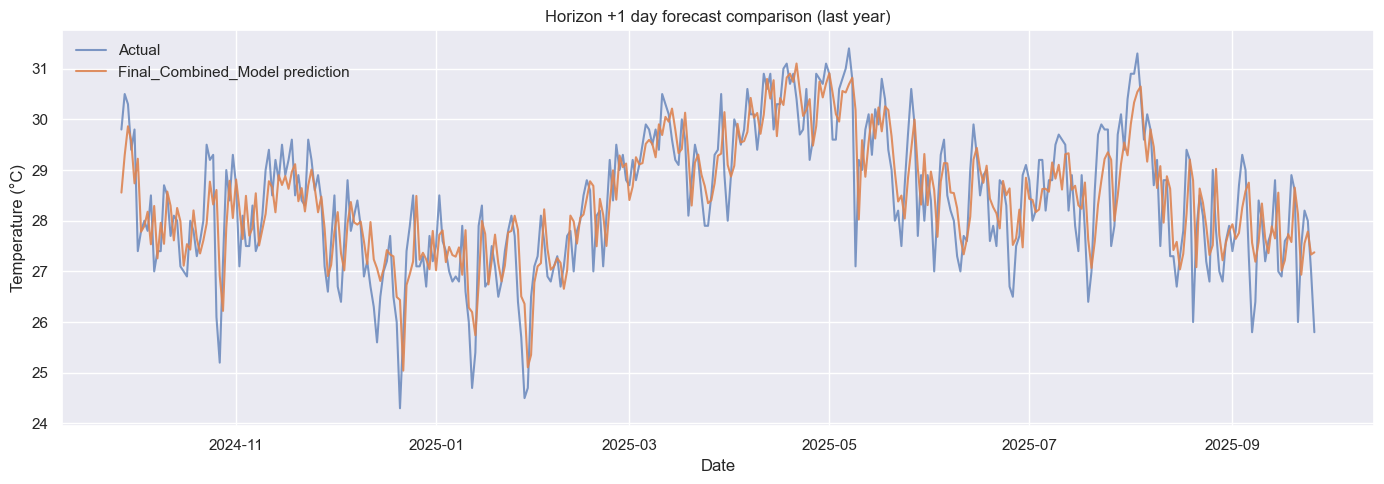

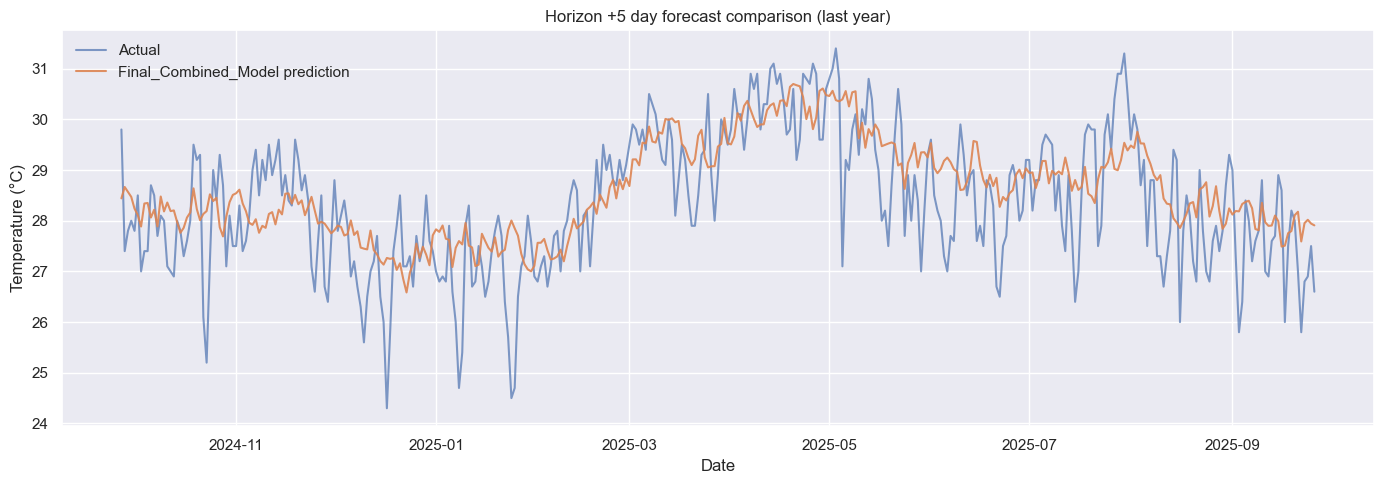

In [41]:
final_summary(model_results, y_test, test_dates, HORIZONS)

## <span style='color:blue'> Step 6 · Streamlit  Demo


## <span style='color:blue'> Step 7 · Retraining Model


## <span style='color:blue'> Step 8 · Hourly Data


### 8.1. Load and Preprocess Hourly Data


In [42]:
print("=== Loading Hourly Weather Data ===")
DATA_PATH_HOURLY = "data/weather_hcm_hourly.csv"
df_raw_hourly = pd.read_csv(DATA_PATH_HOURLY)

print("--- Basic Info (before processing) ---")
print(f"Dataset shape: {df_raw_hourly.shape}")
print(f"Sampling period: {df_raw_hourly['datetime'].min()} to {df_raw_hourly['datetime'].max()}")
print(f"Total hours: {df_raw_hourly.shape[0]}")

# Convert datetime and sort
df_raw_hourly['datetime'] = pd.to_datetime(df_raw_hourly['datetime'])
df_raw_hourly = df_raw_hourly.sort_values('datetime').reset_index(drop=True)

# Check for missing timestamps
full_time_range = pd.date_range(
    start=df_raw_hourly['datetime'].min(),
    end=df_raw_hourly['datetime'].max(),
    freq='h'
)

missing_timestamps = full_time_range.difference(df_raw_hourly['datetime'])
if len(missing_timestamps) > 0:
    print(f"\nFound {len(missing_timestamps)} missing hourly timestamps!")
    print("First 10 missing timestamps:", missing_timestamps[:10])
else:
    print("\nData is continuous, no missing hours found.")

display(df_raw_hourly.head())


=== Loading Hourly Weather Data ===
--- Basic Info (before processing) ---
Dataset shape: (94248, 26)
Sampling period: 2015-01-01 00:00:00 to 2025-10-01 23:00:00
Total hours: 94248

Data is continuous, no missing hours found.


name           address        resolvedAddress  latitude  \
0  Hồ Chí Minh, Việt Nam  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
1  Hồ Chí Minh, Việt Nam  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
2  Hồ Chí Minh, Việt Nam  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
3  Hồ Chí Minh, Việt Nam  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
4  Hồ Chí Minh, Việt Nam  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   

   longitude            datetime  temp  feelslike   dew  humidity  precip  \
0    106.701 2015-01-01 00:00:00  24.6       24.6  19.0     71.06     0.0   
1    106.701 2015-01-01 01:00:00  24.5       24.5  20.2     77.06     0.0   
2    106.701 2015-01-01 02:00:00  24.0       24.0  20.0     78.35     0.0   
3    106.701 2015-01-01 03:00:00  24.0       24.0  20.0     78.35     0.0   
4    106.701 2015-01-01 04:00:00  24.0       24.0  20.7     81.94     0.0   

   precipprob preciptype  windgust  windspeed  winddir  sealevelpressure  \
0         0.0        NaN       9.4        3.6    240.0            1012.0   
1         0.0        NaN       9.0        3.6    294.0            1012.2   
2         0.0        NaN       6.5        4.7    324.0            1012.0   
3         0.0        NaN       6.8        7.0    334.0            1012.0   
4         0.0        NaN       9.0        6.7    336.0            1012.1   

   cloudcover  visibility  solarradiation  solarenergy  uvindex  severerisk  \
0        50.0         7.0             0.0          0.0      0.0         NaN   
1        53.7         8.2             0.0          0.0      0.0         NaN   
2        50.0         7.0             0.0          0.0      0.0         NaN   
3        50.0         6.0             0.0          0.0      0.0         NaN   
4        53.7         7.3             0.0          0.0      0.0         NaN   

         conditions                 icon source  
0  Partially cloudy  partly-cloudy-night    obs  
1  Partially cloudy  partly-cloudy-night    obs  
2  Partially cloudy  partly-cloudy-night    obs  
3  Partially cloudy  partly-cloudy-night    obs  
4  Partially cloudy  partly-cloudy-night    obs

=== Exploratory Data Analysis ===


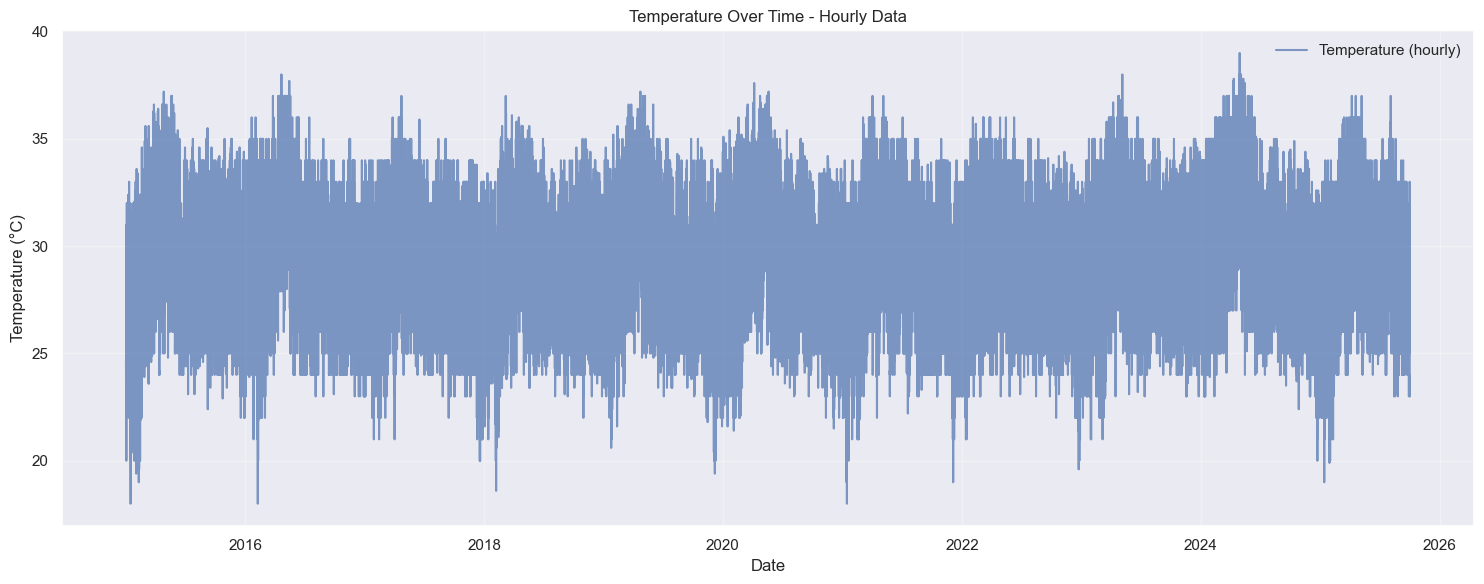

Analyzing 24-hour temperature cycle...


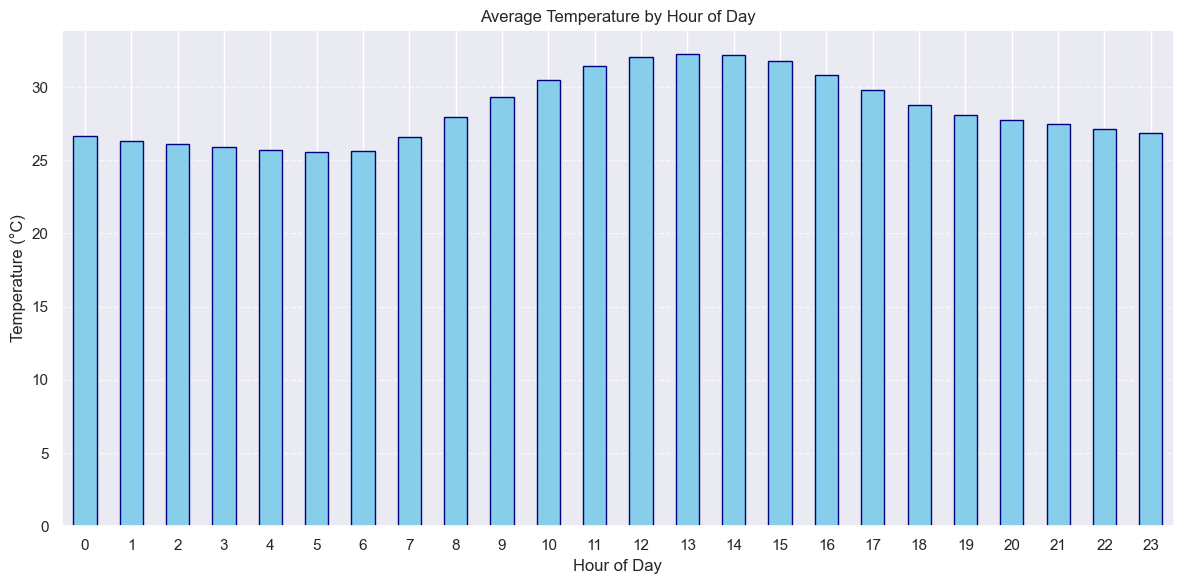

Analyzing variable distributions...


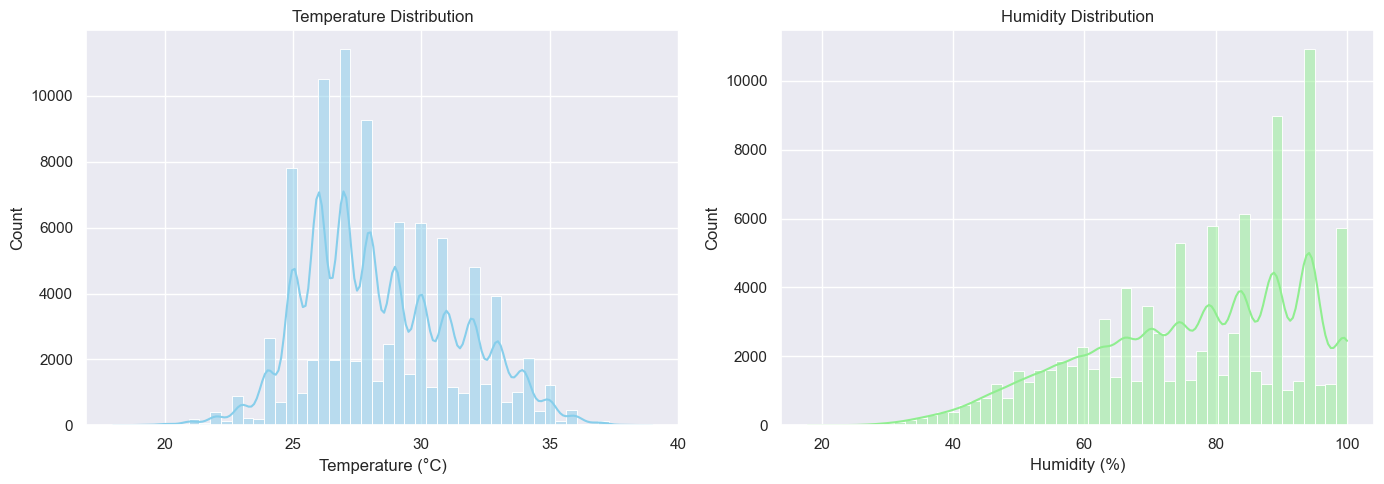

In [43]:
print("=== Exploratory Data Analysis ===")

# Plot temperature over time
plt.figure(figsize=(15, 6))
plt.plot(df_raw_hourly['datetime'], df_raw_hourly['temp'], label='Temperature (hourly)', alpha=0.7)
plt.title('Temperature Over Time - Hourly Data')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze 24-hour cycle 
print("Analyzing 24-hour temperature cycle...")
df_raw_hourly['hour'] = df_raw_hourly['datetime'].dt.hour
hourly_avg = df_raw_hourly.groupby('hour')['temp'].mean()

plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='bar', color='skyblue', edgecolor='navy')
plt.title('Average Temperature by Hour of Day')
plt.ylabel('Temperature (°C)')
plt.xlabel('Hour of Day')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Distribution analysis
print("Analyzing variable distributions...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_raw_hourly['temp'], kde=True, ax=axes[0], bins=50, color='skyblue')
axes[0].set_title('Temperature Distribution')
axes[0].set_xlabel('Temperature (°C)')

sns.histplot(df_raw_hourly['humidity'], kde=True, ax=axes[1], bins=50, color='lightgreen')
axes[1].set_title('Humidity Distribution')
axes[1].set_xlabel('Humidity (%)')

plt.tight_layout()
plt.show()

                    count                 mean                  min  \
latitude          94248.0               10.776               10.776   
longitude         94248.0              106.701              106.701   
datetime            94248  2020-05-17 11:30:00  2015-01-01 00:00:00   
temp              94248.0            28.443794                 18.0   
feelslike         94248.0            31.669485                 18.0   
dew               94248.0            23.502198                  6.6   
humidity          94248.0            76.570977                 17.9   
precip            94209.0             0.217274                  0.0   
precipprob        94248.0            10.347169                  0.0   
windgust          94199.0            18.153898                  1.4   
windspeed         94248.0            10.028387                  0.0   
winddir           94238.0           185.676691                  0.0   
sealevelpressure  94248.0          1009.112779                999.0   
cloudc

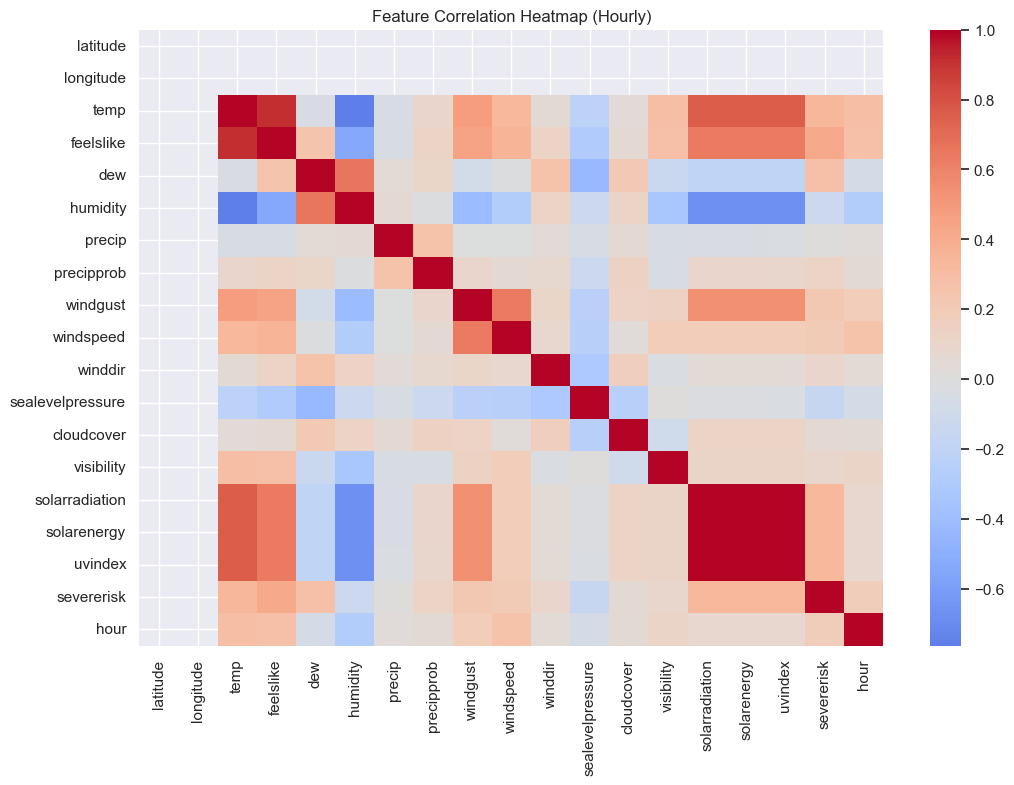

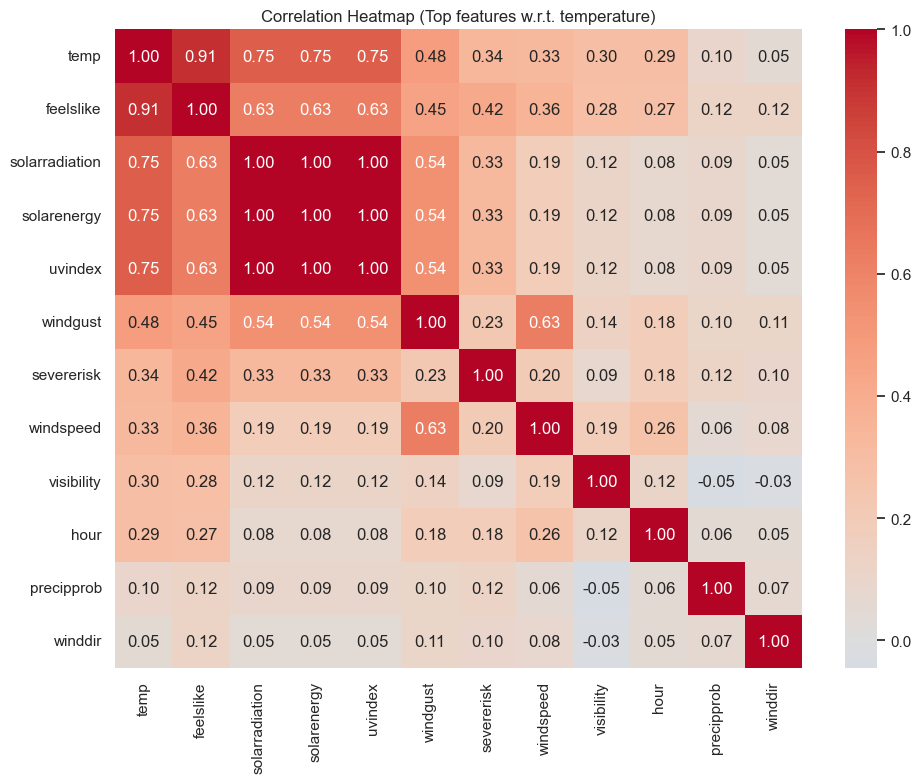

Correlation_with_temp
temp                         1.000000
feelslike                    0.911625
solarradiation               0.753818
solarenergy                  0.753590
uvindex                      0.753254
windgust                     0.478550
severerisk                   0.341084
windspeed                    0.328380
visibility                   0.295847
hour                         0.293892
precipprob                   0.099725
winddir                      0.054258
cloudcover                   0.032066
dew                         -0.038343
precip                      -0.046613

In [44]:
print(df_raw_hourly.describe().T)

# --- Full correlation heatmap ---
plt.figure(figsize=(12, 8))
sns.heatmap(df_raw_hourly.corr(numeric_only=True), cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Heatmap (Hourly)")
plt.show()

# --- Correlation with target (temperature) ---
numeric_cols = df_raw_hourly.select_dtypes(include=np.number).columns.tolist()
corr_matrix = df_raw_hourly[numeric_cols].corr()

corr_target = corr_matrix['temp'].sort_values(ascending=False)
top_features = corr_target.index[:12].tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Top features w.r.t. temperature)')
plt.tight_layout()
plt.show()

corr_target_df = corr_target.to_frame(name='Correlation_with_temp')
display(corr_target_df.head(15))


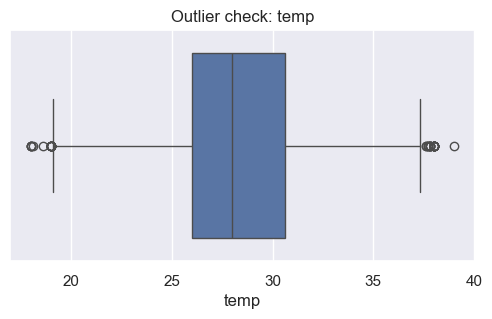

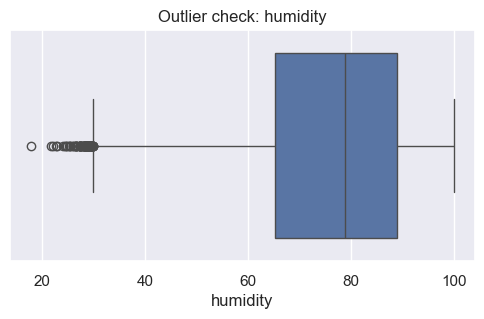

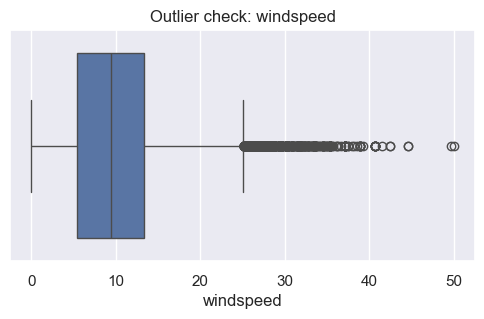

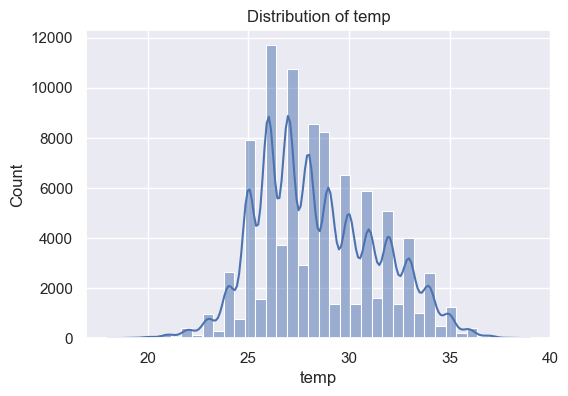

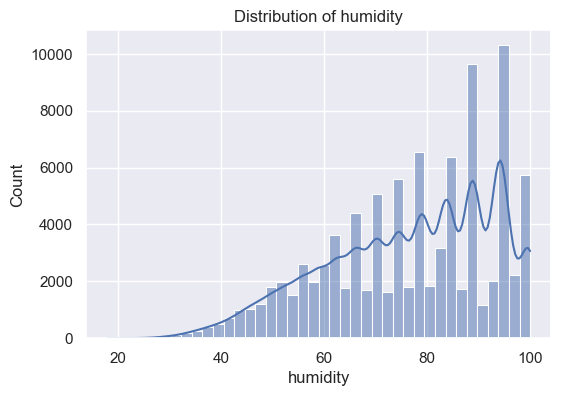

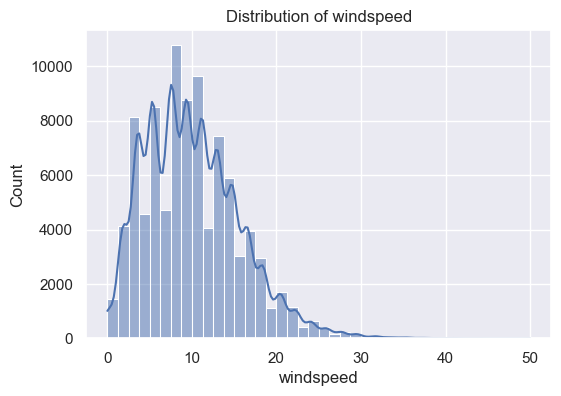

In [45]:

for col in ['temp', 'humidity', 'windspeed']:
    if col in df_raw_hourly.columns:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=df_raw_hourly[col])
        plt.title(f"Outlier check: {col}")
        plt.show()


# Distribution plot
for col in ['temp', 'humidity', 'windspeed']:
    if col in df_raw_hourly.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df_raw_hourly[col], kde=True, bins=40)
        plt.title(f"Distribution of {col}")
        plt.show()


In [46]:
duplicates = df_raw_hourly[df_raw_hourly['datetime'].duplicated()]
if len(duplicates) > 0:
    print(f"Found {len(duplicates)} duplicate rows. Keeping first occurrence.")
    df_raw_hourly = df_raw_hourly.drop_duplicates(subset=['datetime'])

In [47]:
# # === Data Cleaning ===
# print("=== Data Cleaning ===")

# duplicates = df_raw_hourly[df_raw_hourly['datetime'].duplicated()]
# if len(duplicates) > 0:
#     print(f"Found {len(duplicates)} duplicate rows. Removing duplicates...")
#     df_raw_hourly = df_raw_hourly.drop_duplicates(subset=['datetime'])
# else:
#     print("No duplicate timestamps found.")

# for col in ['temp', 'humidity', 'windspeed']:
#     if col in df_raw_hourly.columns:
#         Q1 = df_raw_hourly[col].quantile(0.25)
#         Q3 = df_raw_hourly[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower = Q1 - 1.5 * IQR
#         upper = Q3 + 1.5 * IQR
#         outliers = df_raw_hourly[(df_raw_hourly[col] < lower) | (df_raw_hourly[col] > upper)]
#         if len(outliers) > 0:
#             print(f"Detected {len(outliers)} outliers in {col}. Clipping to IQR range.")
#             df_raw_hourly[col] = np.clip(df_raw_hourly[col], lower, upper)


In [48]:
print("=== Handling Missing Values ===")

# Check missing values in key numeric columns
numeric_cols = ['temp', 'humidity', 'windspeed', 'precip']
print("--- Missing Data (Before) ---")
missing_before = df_raw_hourly[numeric_cols].isna().sum()
print(missing_before)

# Process missing values
df_processed_hourly = df_raw_hourly.copy()
df_processed_hourly = df_processed_hourly.set_index('datetime')

# Interpolate missing values using time-based interpolation
df_processed_hourly[numeric_cols] = df_processed_hourly[numeric_cols].interpolate(method='time')
df_processed_hourly[numeric_cols] = df_processed_hourly[numeric_cols].ffill().bfill()
df_processed_hourly = df_processed_hourly.reset_index()

print("\n--- Missing Data (After) ---")
missing_after = df_processed_hourly[numeric_cols].isna().sum()
print(missing_after)

print(f"\nMissing values handled: {missing_before.sum()} -> {missing_after.sum()}")

=== Handling Missing Values ===
--- Missing Data (Before) ---
temp          0
humidity      0
windspeed     0
precip       39
dtype: int64

--- Missing Data (After) ---
temp         0
humidity     0
windspeed    0
precip       0
dtype: int64

Missing values handled: 39 -> 0


### 8.2. Feature Engineering for Hourly Data


In [49]:
print("=== Feature Engineering for Hourly Data ===")

# Hourly-specific configurations
DEFAULT_HOURLY_HORIZONS = [1, 2, 3, 6, 12, 18, 24, 48, 72, 96, 120]  
DEFAULT_HOURLY_LAGS = [1, 2, 3, 6, 12, 18, 24, 48, 96, 120, 144]  
DEFAULT_HOURLY_ROLLING = [3, 6, 12, 18, 24, 48, 72, 96, 120, 144]  

# Note: prepare_features_hourly is imported from src/feature_engineering.py
# No need to redefine it here - using the production version!
print("✓ Using prepare_features_hourly from src/feature_engineering.py")

=== Feature Engineering for Hourly Data ===
✓ Using prepare_features_hourly from src/feature_engineering.py


In [50]:
print("=== Applying Feature Engineering ===")

feature_df_hourly, target_df_hourly, target_cols_hourly = prepare_features_hourly(
    df_processed_hourly, 
    horizons=DEFAULT_HOURLY_HORIZONS,
    lag_values=DEFAULT_HOURLY_LAGS,
    rolling_windows=DEFAULT_HOURLY_ROLLING
)
print(f"✓ Feature Engineering completed")
print(f"- Feature DataFrame shape: {feature_df_hourly.shape}")
print(f"- Target DataFrame shape: {target_df_hourly.shape}")
print(f"- Target columns: {target_cols_hourly}")


=== Applying Feature Engineering ===
Starting Feature Engineering: 94248 rows
Lags: [1, 2, 3, 6, 12, 18, 24, 48, 96, 120, 144], Rolling windows: [3, 6, 12, 18, 24, 48, 72, 96, 120, 144], Horizons: [1, 2, 3, 6, 12, 18, 24, 48, 72, 96, 120]
    - Dropping unnecessary columns: ['name', 'address', 'resolvedAddress', 'latitude', 'longitude', 'source']
Final data size for modeling: 93984 rows
    - Removed leakage columns: ['temp']
    - Feature columns: 257
    - Target columns (Avg only): 5
✓ Feature Engineering completed
- Feature DataFrame shape: (93984, 257)
- Target DataFrame shape: (93984, 16)
- Target columns: ['target_avg_day_1', 'target_avg_day_2', 'target_avg_day_3', 'target_avg_day_4', 'target_avg_day_5']


In [51]:
feature_df_hourly.head(5)

datetime  feelslike   dew  humidity  precip  precipprob  \
144 2015-01-07 00:00:00       24.4  22.0     86.46     0.0         0.0   
145 2015-01-07 01:00:00       24.9  22.1     84.64     0.0         0.0   
146 2015-01-07 02:00:00       24.6  21.6     83.41     0.0         0.0   
147 2015-01-07 03:00:00       24.4  21.6     84.34     0.0         0.0   
148 2015-01-07 04:00:00       24.9  21.2     80.08     0.0         0.0   

    preciptype  windgust  windspeed  winddir  sealevelpressure  cloudcover  \
144       none       7.6        7.6    242.0            1010.0        50.0   
145       none       7.2        5.4    220.0            1009.3        50.9   
146       none       8.3        4.7    228.0            1009.0        50.0   
147       none       8.6        3.6    160.0            1009.0        50.0   
148       none       9.0        3.9    160.0            1009.1        50.9   

     visibility  solarradiation  solarenergy  uvindex  severerisk  \
144        10.0             0.0          0.0      0.0         0.0   
145        10.9             0.0          0.0      0.0         0.0   
146        10.0             0.0          0.0      0.0         0.0   
147        10.0             0.0          0.0      0.0         0.0   
148        10.9             0.0          0.0      0.0         0.0   

           conditions                 icon  hour  day_of_year  month  year  \
144  Partially cloudy  partly-cloudy-night     0            7      1  2015   
145  Partially cloudy  partly-cloudy-night     1            7      1  2015   
146  Partially cloudy  partly-cloudy-night     2            7      1  2015   
147  Partially cloudy  partly-cloudy-night     3            7      1  2015   
148  Partially cloudy  partly-cloudy-night     4            7      1  2015   

     day_of_week  is_weekend  sin_day_of_year  cos_day_of_year  sin_month  \
144            2           0         0.119881         0.992788        0.5   
145            2           0         0.119881         0.992788        0.5   
146            2           0         0.119881         0.992788        0.5   
147            2           0         0.119881         0.992788        0.5   
148            2           0         0.119881         0.992788        0.5   

     cos_month  sin_hour  cos_hour  feelslike_lag_1  humidity_lag_1  \
144   0.866025  0.000000  1.000000             24.4           86.46   
145   0.866025  0.258819  0.965926             24.4           86.46   
146   0.866025  0.500000  0.866025             24.9           84.64   
147   0.866025  0.707107  0.707107             24.6           83.41   
148   0.866025  0.866025  0.500000             24.4           84.34   

     dew_lag_1  precip_lag_1  precipprob_lag_1  windgust_lag_1  \
144       22.0           0.0               0.0             7.6   
145       22.0           0.0               0.0             7.6   
146       22.1           0.0               0.0             7.2   
147       21.6           0.0               0.0             8.3   
148       21.6           0.0               0.0             8.6   

     windspeed_lag_1  winddir_lag_1  sealevelpressure_lag_1  cloudcover_lag_1  \
144              7.6          272.0                  1010.0              50.0   
145              7.6          242.0                  1010.0              50.0   
146              5.4          220.0                  1009.3              50.9   
147              4.7          228.0                  1009.0              50.0   
148              3.6          160.0                  1009.0              50.0   

     visibility_lag_1  solarradiation_lag_1  solarenergy_lag_1  uvindex_lag_1  \
144              10.0                   0.0                0.0            0.0   
145              10.0                   0.0                0.0            0.0   
146              10.9                   0.0                0.0            0.0   
147              10.0                   0.0                0.0            0.0   
148              10.0                 

In [52]:
target_df_hourly.head(5)

row_id  target_daily_max_day_1  target_daily_min_day_1  target_avg_day_1  \
144     144                    32.0                    23.9             27.95   
145     145                    32.0                    23.9             27.95   
146     146                    32.0                    23.9             27.95   
147     147                    32.0                    23.9             27.95   
148     148                    32.0                    23.9             27.95   

     target_daily_max_day_2  target_daily_min_day_2  target_avg_day_2  \
144                    32.4                    23.6             28.00   
145                    32.4                    23.6             28.00   
146                    32.4                    23.6             28.00   
147                    32.4                    23.6             28.00   
148                    32.4                    22.9             27.65   

     target_daily_max_day_3  target_daily_min_day_3  target_avg_day_3  \
144                    32.4                    22.0              27.2   
145                    32.4                    22.0              27.2   
146                    32.4                    22.0              27.2   
147                    32.4                    22.0              27.2   
148                    32.4                    22.0              27.2   

     target_daily_max_day_4  target_daily_min_day_4  target_avg_day_4  \
144                    33.0                    23.9             28.45   
145                    33.0                    23.9             28.45   
146                    33.0                    23.9             28.45   
147                    33.0                    23.9             28.45   
148                    33.0                    24.0             28.50   

     target_daily_max_day_5  target_daily_min_day_5  target_avg_day_5  
144                    30.4                    24.0             27.20  
145                    30.4                    24.0             27.20  
146                    30.4                    24.0             27.20  
147                    30.4                    24.0             27.20  
148                    30.4                    23.9             27.15

### 8.3. Data Splitting and Preprocessing Setup

In [53]:
print("=== Data Splitting and Preprocessing Setup (Hourly Data) ===")
# === 1. Extract datetime and define leakage buffer ===
LEAKAGE_BUFFER_HOURLY = 336  # 14  days buffer (to prevent leakage)
dates_hourly = feature_df_hourly['datetime'].reset_index(drop=True)

X_hourly = feature_df_hourly.drop(columns=['datetime'])
y_hourly = target_df_hourly[target_cols_hourly]

# === 2. Time-based train-test split (85–15) ===
split_idx = int(len(X_hourly) * 0.85)

X_train_hourly = X_hourly.iloc[:split_idx]
y_train_hourly = y_hourly.iloc[:split_idx]
train_dates_hourly = dates_hourly.iloc[:split_idx]

# Apply leakage buffer before test set
X_test_hourly = X_hourly.iloc[split_idx + LEAKAGE_BUFFER_HOURLY:]
y_test_hourly = y_hourly.iloc[split_idx + LEAKAGE_BUFFER_HOURLY:]
test_dates_hourly = dates_hourly.iloc[split_idx + LEAKAGE_BUFFER_HOURLY:]

print(f"   - Training set: X={X_train_hourly.shape}, y={y_train_hourly.shape}")
print(f"   - Testing set:  X={X_test_hourly.shape}, y={y_test_hourly.shape}")

# === 3. Identify column types for preprocessing ===
print("\nIdentifying column types for preprocessing...")

potential_cat_cols = ['preciptype', 'conditions', 'icon', 'month', 'day_of_week', 'hour', 'year']
categorical_cols_hourly = [col for col in potential_cat_cols if col in X_train_hourly.columns]

text_cols_hourly = []  # none expected after feature engineering

numeric_cols_hourly = [
    col for col in X_train_hourly.columns
    if col not in categorical_cols_hourly + text_cols_hourly
]

print(f"   - Numeric columns: {len(numeric_cols_hourly)}")
print(f"   - Categorical columns: {len(categorical_cols_hourly)}")
print(f"   - Text columns: {len(text_cols_hourly)}")

# === 4. Verify numeric columns ===
non_numeric_found = X_train_hourly[numeric_cols_hourly].select_dtypes(exclude=np.number).columns
if len(non_numeric_found) > 0:
    print(f"   - ✗ WARNING: Non-numeric columns found: {non_numeric_found.tolist()}")
else:
    print("   - ✓ All numeric columns verified as numeric")

# === 5. Initialize TimeSeriesSplit for cross-validation ===
tscv_hourly = ModTimeSeriesSplit(n_splits=5, buffer=LEAKAGE_BUFFER_HOURLY)
print("   - TimeSeriesSplit initialized (n_splits=5, no leakage across folds)")


=== Data Splitting and Preprocessing Setup (Hourly Data) ===
   - Training set: X=(79886, 256), y=(79886, 5)
   - Testing set:  X=(13762, 256), y=(13762, 5)

Identifying column types for preprocessing...
   - Numeric columns: 249
   - Categorical columns: 7
   - Text columns: 0
   - ✓ All numeric columns verified as numeric
   - TimeSeriesSplit initialized (n_splits=5, no leakage across folds)


### 8.4. Hourly Data pipeline


### Naive Baseline for hourly data

In [54]:
model_results_hourly = {}  # To store results for hourly models

In [63]:
print("Naive Persistence Baseline (Hourly)")

# Determine hourly horizons to match the available target columns (avoid mismatch)
try:
    # target_cols_hourly is created by prepare_features_hourly; use its length to derive horizons
    HORIZONS_HOURLY = list(range(1, len(target_cols_hourly) + 1))
except NameError:
    # Fallback: use first 5 of the default hourly horizons if target_cols_hourly is not available
    HORIZONS_HOURLY = DEFAULT_HOURLY_HORIZONS[:5]

def persistence_baseline_hourly(temp_lag_series, horizons):
    """
    Naive persistence baseline: assumes temperature at t+h = temperature at t-1
    """
    # Handle any NaN values by forward/back filling
    temp_lag_clean = pd.Series(temp_lag_series).ffill().bfill().values
    return np.repeat(temp_lag_clean.reshape(-1, 1), len(horizons), axis=1)

# Create predictions (ensure 'temp_lag_1' exists)
if 'temp_lag_1' not in X_train_hourly.columns or 'temp_lag_1' not in X_test_hourly.columns:
    raise KeyError("Column 'temp_lag_1' not found in X_train_hourly / X_test_hourly. Check feature engineering.")

naive_train_preds_hourly = persistence_baseline_hourly(X_train_hourly['temp_lag_1'].values, HORIZONS_HOURLY)
naive_test_preds_hourly = persistence_baseline_hourly(X_test_hourly['temp_lag_1'].values, HORIZONS_HOURLY)

# Store results
model_results_hourly['NaivePersistence_Hourly'] = {
    'train_metrics': compute_metrics(y_train_hourly.values, naive_train_preds_hourly, horizons=HORIZONS_HOURLY),
    'test_metrics': compute_metrics(y_test_hourly.values, naive_test_preds_hourly, horizons=HORIZONS_HOURLY),
    'cv_metrics': None,
    'predictions_test': naive_test_preds_hourly,
    'predictions_train': naive_train_preds_hourly,
    'details': 'Baseline: t+h temperature = t-1 temperature for all horizons (hourly)'
}

print('\n--- Naive baseline metrics (hourly) ---')
display(pd.Series(model_results_hourly['NaivePersistence_Hourly']['test_metrics']).to_frame('NaivePersistence_Hourly').T)

Naive Persistence Baseline (Hourly)

--- Naive baseline metrics (hourly) ---


RMSE_h1    MAE_h1   MAPE_h1     R2_h1   RMSE_h2  \
NaivePersistence_Hourly  2.676779  2.321574  7.859158 -1.522437  2.800296   

                          MAE_h2   MAPE_h2    R2_h2   RMSE_h3    MAE_h3  \
NaivePersistence_Hourly  2.40117  8.131175 -1.75318  2.866447  2.442893   

                          MAPE_h3    R2_h3   RMSE_h4    MAE_h4   MAPE_h4  \
NaivePersistence_Hourly  8.270791 -1.87514  2.892581  2.456133  8.312576   

                            R2_h4   RMSE_h5    MAE_h5   MAPE_h5     R2_h5  \
NaivePersistence_Hourly -1.924161  2.897359  2.455722  8.309613 -1.933604   

                         RMSE_macro  MAE_macro  MAPE_macro  R2_macro  
NaivePersistence_Hourly    2.826692   2.415498    8.176662 -1.801704

Re-run Optuna hyperparameter tuning for HGB with hourly data

In [55]:
print("=== Applying Daily Data Pipeline to Hourly Data ===")

best_hgb_params_hourly = {
    'learning_rate': 0.07172313382240242, 
    'max_depth': 12, 
    'min_samples_leaf': 131, 
    'l2_regularization': 0.0026568368934158193
}

print("Using optimized hyperparameters:")
print(f"   - Learning rate: {best_hgb_params_hourly['learning_rate']:.6f}")
print(f"   - Max depth: {best_hgb_params_hourly['max_depth']}")
print(f"   - Min samples leaf: {best_hgb_params_hourly['min_samples_leaf']}")
print(f"   - L2 regularization: {best_hgb_params_hourly['l2_regularization']:.6f}")

# Create hourly-specific preprocessing function
def build_preprocessor_hourly():
    """Build preprocessor specifically for hourly data columns."""
    transformers = []
    
    # Get column types for hourly data
    potential_cat_cols = ['preciptype', 'conditions', 'icon', 'month', 'day_of_week', 'hour', 'year']
    categorical_cols_hourly = [col for col in potential_cat_cols if col in X_train_hourly.columns]
    text_cols_hourly = []  # No text columns in hourly data after feature engineering
    numeric_cols_hourly = [col for col in X_train_hourly.columns if col not in categorical_cols_hourly + text_cols_hourly]
    
    print(f"   - Numeric columns: {len(numeric_cols_hourly)}")
    print(f"   - Categorical columns: {len(categorical_cols_hourly)}")
    print(f"   - Text columns: {len(text_cols_hourly)}")
    
    if numeric_cols_hourly:
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num', numeric_transformer, numeric_cols_hourly))
    
    if categorical_cols_hourly:
        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        transformers.append(('cat', categorical_transformer, categorical_cols_hourly))
    
    if text_cols_hourly:
        text_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('flatten', FunctionTransformer(lambda x: x.ravel(), accept_sparse=False)),
            ('tfidf', TfidfVectorizer(max_features=100, ngram_range=(1, 2)))
        ])
        transformers.append(('text', text_transformer, text_cols_hourly))
    
    return ColumnTransformer(transformers=transformers, remainder='drop', sparse_threshold=0.0)

def make_pipeline_hourly(estimator):
    """Create pipeline specifically for hourly data."""
    return Pipeline([
        ('preprocess', build_preprocessor_hourly()),
        ('dense', FunctionTransformer(to_dense, accept_sparse=True)),
        ('regressor', estimator)
    ])

model_results_hourly = {}

# Train base models using the hourly-specific pipeline
print("\n--- Training Base Models ---")
estimators_to_train_hourly = {
    'BayesianRidge_Hourly': MultiOutputRegressor(BayesianRidge()),
    'HistGradientBoosting_Hourly': MultiOutputRegressor(
        HistGradientBoostingRegressor(random_state=RANDOM_STATE, **best_hgb_params_hourly)
    )
}

for name, estimator in tqdm(estimators_to_train_hourly.items(), desc='Training base models (hourly)'):
    pipeline = make_pipeline_hourly(estimator)
    pipeline.fit(X_train_hourly, y_train_hourly)
    train_pred = pipeline.predict(X_train_hourly)
    test_pred = pipeline.predict(X_test_hourly)
    
    # Determine horizon length from predictions (robust) or from target_cols_hourly
    horizons_hourly = list(range(1, test_pred.shape[1] + 1))
        
    model_results_hourly[name] = {
        'pipeline': pipeline,
        'train_metrics': compute_metrics(y_train_hourly.values, train_pred, horizons=horizons_hourly),
        'test_metrics': compute_metrics(y_test_hourly.values, test_pred, horizons=horizons_hourly),
        'predictions_train': train_pred,
        'predictions_test': test_pred,
        'details': f'{name} trained on hourly data'
    }
    print(f"   - {name} Test RMSE_macro: {model_results_hourly[name]['test_metrics']['RMSE_macro']:.4f}")




=== Applying Daily Data Pipeline to Hourly Data ===
Using optimized hyperparameters:
   - Learning rate: 0.071723
   - Max depth: 12
   - Min samples leaf: 131
   - L2 regularization: 0.002657

--- Training Base Models ---


Training base models (hourly):   0%|          | 0/2 [00:00<?, ?it/s]

   - Numeric columns: 249
   - Categorical columns: 7
   - Text columns: 0


Training base models (hourly):  50%|█████     | 1/2 [00:14<00:14, 14.92s/it]

   - BayesianRidge_Hourly Test RMSE_macro: 1.0818
   - Numeric columns: 249
   - Categorical columns: 7
   - Text columns: 0


Training base models (hourly): 100%|██████████| 2/2 [00:40<00:00, 20.16s/it]

   - HistGradientBoosting_Hourly Test RMSE_macro: 1.0422


In [56]:
# Create ensemble and apply variance correction
ensemble_sources_hourly = ['BayesianRidge_Hourly', 'HistGradientBoosting_Hourly']
available_ensemble_hourly = [name for name in ensemble_sources_hourly if name in model_results_hourly]

if len(available_ensemble_hourly) == 0:
    print("Ensemble skipped: no available hourly models found in model_results_hourly.")
else:
    # compute ensemble predictions (average)
    preds_list_test = [model_results_hourly[name]['predictions_test'] for name in available_ensemble_hourly]
    preds_list_train = [model_results_hourly[name]['predictions_train'] for name in available_ensemble_hourly]

    ensemble_test_preds_hourly = np.mean(preds_list_test, axis=0)
    ensemble_train_preds_hourly = np.mean(preds_list_train, axis=0)

    # determine actual horizons from prediction shape to avoid index errors
    horizons_actual = list(range(1, ensemble_test_preds_hourly.shape[1] + 1))

    model_results_hourly['BayesianRidge_HGB_Ensemble_Hourly'] = {
        'train_metrics': compute_metrics(y_train_hourly.values, ensemble_train_preds_hourly, horizons=horizons_actual),
        'test_metrics': compute_metrics(y_test_hourly.values, ensemble_test_preds_hourly, horizons=horizons_actual),
        'predictions_train': ensemble_train_preds_hourly,
        'predictions_test': ensemble_test_preds_hourly,
        'details': f'Simple average ensemble (hourly) of: {available_ensemble_hourly}'
    }
    print(f"   - Ensemble Test RMSE_macro: {model_results_hourly['BayesianRidge_HGB_Ensemble_Hourly']['test_metrics']['RMSE_macro']:.4f}")

    # Apply variance correction (use the ensemble preds just computed)
    ensemble_test_preds_corr_hourly = apply_variance_correction(ensemble_test_preds_hourly, y_train_hourly.values, method='adaptive')
    ensemble_train_preds_corr_hourly = apply_variance_correction(ensemble_train_preds_hourly, y_train_hourly.values, method='adaptive')

    model_results_hourly['BayesianRidge_HGB_Ensemble_VarCorr_Hourly'] = {
        'train_metrics': compute_metrics(y_train_hourly.values, ensemble_train_preds_corr_hourly, horizons=horizons_actual),
        'test_metrics': compute_metrics(y_test_hourly.values, ensemble_test_preds_corr_hourly, horizons=horizons_actual),
        'predictions_train': ensemble_train_preds_corr_hourly,
        'predictions_test': ensemble_test_preds_corr_hourly,
        'details': f'Variance-corrected ensemble (hourly)'
    }
    print(f"   - VarCorr Ensemble Test RMSE_macro: {model_results_hourly['BayesianRidge_HGB_Ensemble_VarCorr_Hourly']['test_metrics']['RMSE_macro']:.4f}")


   - Ensemble Test RMSE_macro: 1.0183
   - VarCorr Ensemble Test RMSE_macro: 0.9996


In [57]:
# Update residual booster functions for hourly data
def fit_residual_booster_hourly(X_train, y_train, y_pred_train):
    """Fit a small HGB regressor on residuals per horizon using preprocessed features for hourly data."""
    y_train = np.asarray(y_train)
    y_pred_train = np.asarray(y_pred_train)
    n_samples, n_horizons = y_pred_train.shape
    boosters = []
    res_train = y_train - y_pred_train

    # Use the hourly preprocessor to transform X_train first
    preprocessor = build_preprocessor_hourly()
    X_train_transformed = preprocessor.fit_transform(X_train)

    if hasattr(X_train_transformed, 'toarray'):
        X_train_transformed = X_train_transformed.toarray()

    for h in range(n_horizons):
        booster = HistGradientBoostingRegressor(max_depth=3, max_iter=100, learning_rate=0.05)
        booster.fit(X_train_transformed, res_train[:, h])
        boosters.append(booster)
    return boosters, preprocessor

def apply_residual_booster_hourly(X_test, y_pred_test, boosters, preprocessor):
    """Apply residual booster to test predictions using preprocessed features for hourly data."""
    y_pred_test = np.asarray(y_pred_test)
    n_samples, n_horizons = y_pred_test.shape
    y_final = y_pred_test.copy()

    # Transform X_test using the same preprocessor
    X_test_transformed = preprocessor.transform(X_test)

    if hasattr(X_test_transformed, 'toarray'):
        X_test_transformed = X_test_transformed.toarray()

    for h in range(n_horizons):
        res_hat_test = boosters[h].predict(X_test_transformed)
        y_final[:, h] += res_hat_test
    return y_final

print("--- Applying Residual Booster ---")

base_ensemble_train_preds_hourly = model_results_hourly['BayesianRidge_HGB_Ensemble_Hourly']['predictions_train']
base_ensemble_test_preds_hourly = model_results_hourly['BayesianRidge_HGB_Ensemble_Hourly']['predictions_test']
        
boosters_hourly, booster_preprocessor_hourly = fit_residual_booster_hourly(
    X_train_hourly, y_train_hourly.values, base_ensemble_train_preds_hourly
)
        
residual_boosted_preds_hourly = apply_residual_booster_hourly(
    X_test_hourly, base_ensemble_test_preds_hourly, boosters_hourly, booster_preprocessor_hourly
)

# Determine actual horizons from prediction shape to avoid index errors
horizons_actual_hourly = list(range(1, residual_boosted_preds_hourly.shape[1] + 1))

model_results_hourly['ResidualBooster_Ensemble_Hourly'] = {
    'test_metrics': compute_metrics(y_test_hourly.values, residual_boosted_preds_hourly, horizons=horizons_actual_hourly),
    'predictions_test': residual_boosted_preds_hourly,
    'details': 'Residual booster (HGB per horizon) applied to hourly ensemble'
}
print(f"   - Residual Booster Ensemble Test RMSE_macro: {model_results_hourly['ResidualBooster_Ensemble_Hourly']['test_metrics']['RMSE_macro']:.4f}")


--- Applying Residual Booster ---
   - Numeric columns: 249
   - Categorical columns: 7
   - Text columns: 0
   - Residual Booster Ensemble Test RMSE_macro: 1.0157


In [58]:
print("--- Applying Final Combined Model Logic from Daily Data ---")

# The proven logic from daily data:
# Horizon 1: ResidualBooster_Ensemble (best for short-term)
# Horizon 2-5: BayesianRidge_HGB_Ensemble_VarCorr (best for medium/long-term)

# For hourly data:
# Horizon 1h: ResidualBooster_Ensemble_Hourly
# Horizon 3h, 6h, 12h, 24h: BayesianRidge_HGB_Ensemble_VarCorr_Hourly

required_models_final = ['ResidualBooster_Ensemble_Hourly', 'BayesianRidge_HGB_Ensemble_VarCorr_Hourly']
missing_models_final = [model for model in required_models_final if model not in model_results_hourly]

if missing_models_final:
    raise RuntimeError(f"Cannot build final combined hourly model. Missing models: {missing_models_final}")

# Get predictions from both models
residual_boosted_preds_final = model_results_hourly['ResidualBooster_Ensemble_Hourly']['predictions_test']
varcorr_preds_final = model_results_hourly['BayesianRidge_HGB_Ensemble_VarCorr_Hourly']['predictions_test']

print(f"ResidualBooster_Ensemble_Hourly shape: {residual_boosted_preds_final.shape}")
print(f"BayesianRidge_HGB_Ensemble_VarCorr_Hourly shape: {varcorr_preds_final.shape}")

# Ensure compatible shapes: use the minimum number of horizons available from both models
n_rows_res, n_horiz_res = residual_boosted_preds_final.shape
n_rows_var, n_horiz_var = varcorr_preds_final.shape

if n_rows_res != n_rows_var:
    raise RuntimeError(f"Row count mismatch between models: residual={n_rows_res}, varcorr={n_rows_var}")

n_horiz_min = min(n_horiz_res, n_horiz_var)

# Build final predictions with safe column alignment:
# - keep horizon 0 (index 0) from residual booster
# - for horizons 1..n_horiz_min-1 take from varcorr
final_test_preds_hourly = residual_boosted_preds_final[:, :n_horiz_min].copy()
if n_horiz_min > 1:
    final_test_preds_hourly[:, 1:] = varcorr_preds_final[:, 1:n_horiz_min]

# Derive the correct horizons list matching the number of prediction columns
horizons_actual_hourly = list(range(1, final_test_preds_hourly.shape[1] + 1))

# Calculate final metrics using matching horizons (avoid using DEFAULT_HOURLY_HORIZONS)
final_test_metrics_hourly = compute_metrics(y_test_hourly.values[:, :final_test_preds_hourly.shape[1]],
                                           final_test_preds_hourly,
                                           horizons=horizons_actual_hourly)

# Store the final combined model
model_results_hourly['Final_Combined_Model_Hourly'] = {
    'test_metrics': final_test_metrics_hourly,
    'predictions_test': final_test_preds_hourly,
    'details': ('Final Combined Model (Hourly): Horizon 1 from ResidualBooster; '
                f'Horizons 2..{horizons_actual_hourly[-1]} from VarCorr')
}

print(f"\nFinal Combined Model (Hourly) Test RMSE_macro: {final_test_metrics_hourly['RMSE_macro']:.4f}")


--- Applying Final Combined Model Logic from Daily Data ---
ResidualBooster_Ensemble_Hourly shape: (13762, 5)
BayesianRidge_HGB_Ensemble_VarCorr_Hourly shape: (13762, 5)

Final Combined Model (Hourly) Test RMSE_macro: 0.9990


### 8.5. Results Summary and Visualization

In [59]:
summary_rows_hourly = []
for name, res in model_results_hourly.items():
    if 'test_metrics' in res and res['test_metrics'] is not None:
        test_metrics = res['test_metrics']
        summary_rows_hourly.append({
            'Model': name,
            'RMSE_macro': test_metrics.get('RMSE_macro', np.nan),
            'MAE_macro': test_metrics.get('MAE_macro', np.nan),
            'MAPE_macro': test_metrics.get('MAPE_macro', np.nan),
            'R2_macro': test_metrics.get('R2_macro', np.nan)
        })

summary_df_hourly = pd.DataFrame(summary_rows_hourly).sort_values('RMSE_macro')
print("\n--- Model Performance Summary (Test Set - Hourly):---")
display(summary_df_hourly)

horizon_metrics_hourly = []
for name, res in model_results_hourly.items():
    if 'test_metrics' in res and res['test_metrics'] is not None:
        row = {'Model': name}
        for horizon in DEFAULT_HOURLY_HORIZONS:
            row[f'RMSE_h{horizon}'] = res['test_metrics'].get(f'RMSE_h{horizon}', np.nan)
        horizon_metrics_hourly.append(row)

horizon_df_hourly = pd.DataFrame(horizon_metrics_hourly).set_index('Model')
valid_models = [m for m in summary_df_hourly['Model'].tolist() if m in horizon_df_hourly.index]
horizon_df_hourly = horizon_df_hourly.loc[valid_models]
print("\n--- Model Performance by Horizon (Test Set - Hourly): ---")
display(horizon_df_hourly)

best_model_name_hourly = summary_df_hourly.iloc[0]['Model']
best_rmse_hourly = summary_df_hourly.iloc[0]['RMSE_macro']

print(f"\nBest Model: {best_model_name_hourly}")
print(f"   - RMSE_macro: {best_rmse_hourly:.4f}")

daily_rmse = model_results['Final_Combined_Model']['test_metrics']['RMSE_macro']
print(f"\n--- Comparison with Daily Data: ---")
print(f"   - Daily Data RMSE_macro: {daily_rmse:.4f}")
print(f"   - Hourly Data RMSE_macro: {best_rmse_hourly:.4f}")
print(f"   - Difference: {abs(daily_rmse - best_rmse_hourly):.4f}")


--- Model Performance Summary (Test Set - Hourly):---


Model  RMSE_macro  MAE_macro  \
5                Final_Combined_Model_Hourly    0.998999   0.777361   
3  BayesianRidge_HGB_Ensemble_VarCorr_Hourly    0.999556   0.777681   
4            ResidualBooster_Ensemble_Hourly    1.015746   0.793748   
2          BayesianRidge_HGB_Ensemble_Hourly    1.018301   0.794487   
1                HistGradientBoosting_Hourly    1.042249   0.819176   
0                       BayesianRidge_Hourly    1.081766   0.840520   

   MAPE_macro  R2_macro  
5    2.670633  0.647338  
3    2.671630  0.647016  
4    2.727677  0.634898  
2    2.730694  0.633236  
1    2.791640  0.616110  
0    2.907849  0.583726


--- Model Performance by Horizon (Test Set - Hourly): ---


RMSE_h1   RMSE_h2   RMSE_h3  \
Model                                                                     
Final_Combined_Model_Hourly                0.820422  0.984716  1.049976   
BayesianRidge_HGB_Ensemble_VarCorr_Hourly  0.823206  0.984716  1.049976   
ResidualBooster_Ensemble_Hourly            0.820422  0.998275  1.072867   
BayesianRidge_HGB_Ensemble_Hourly          0.826973  1.002521  1.071677   
HistGradientBoosting_Hourly                0.856517  1.023568  1.094242   
BayesianRidge_Hourly                       0.839553  1.034627  1.130211   

                                           RMSE_h6  RMSE_h12  RMSE_h18  \
Model                                                                    
Final_Combined_Model_Hourly                    NaN       NaN       NaN   
BayesianRidge_HGB_Ensemble_VarCorr_Hourly      NaN       NaN       NaN   
ResidualBooster_Ensemble_Hourly                NaN       NaN       NaN   
BayesianRidge_HGB_Ensemble_Hourly              NaN       NaN       NaN   
HistGradientBoosting_Hourly                    NaN       NaN       NaN   
BayesianRidge_Hourly                           NaN       NaN       NaN   

                                           RMSE_h24  RMSE_h48  RMSE_h72  \
Model                                                                     
Final_Combined_Model_Hourly                     NaN       NaN       NaN   
BayesianRidge_HGB_Ensemble_VarCorr_Hourly       NaN       NaN       NaN   
ResidualBooster_Ensemble_Hourly                 NaN       NaN       NaN   
BayesianRidge_HGB_Ensemble_Hourly               NaN       NaN       NaN   
HistGradientBoosting_Hourly                     NaN       NaN       NaN   
BayesianRidge_Hourly                            NaN       NaN       NaN   

                                           RMSE_h96  RMSE_h120  
Model                                                           
Final_Combined_Model_Hourly                     NaN        NaN  
BayesianRidge_HGB_Ensemble_VarCorr_Hourly       NaN        NaN  
ResidualBooster_Ensemble_Hourly                 NaN        NaN  
BayesianRidge_HGB_Ensemble_Hourly               NaN        NaN  
HistGradientBoosting_Hourly                     NaN        NaN  
BayesianRidge_Hourly                            NaN        NaN


Best Model: Final_Combined_Model_Hourly
   - RMSE_macro: 0.9990

--- Comparison with Daily Data: ---
   - Daily Data RMSE_macro: 0.9538
   - Hourly Data RMSE_macro: 0.9990
   - Difference: 0.0452


=== Visualization: Daily Avg Temp Forecast vs. Actual ===


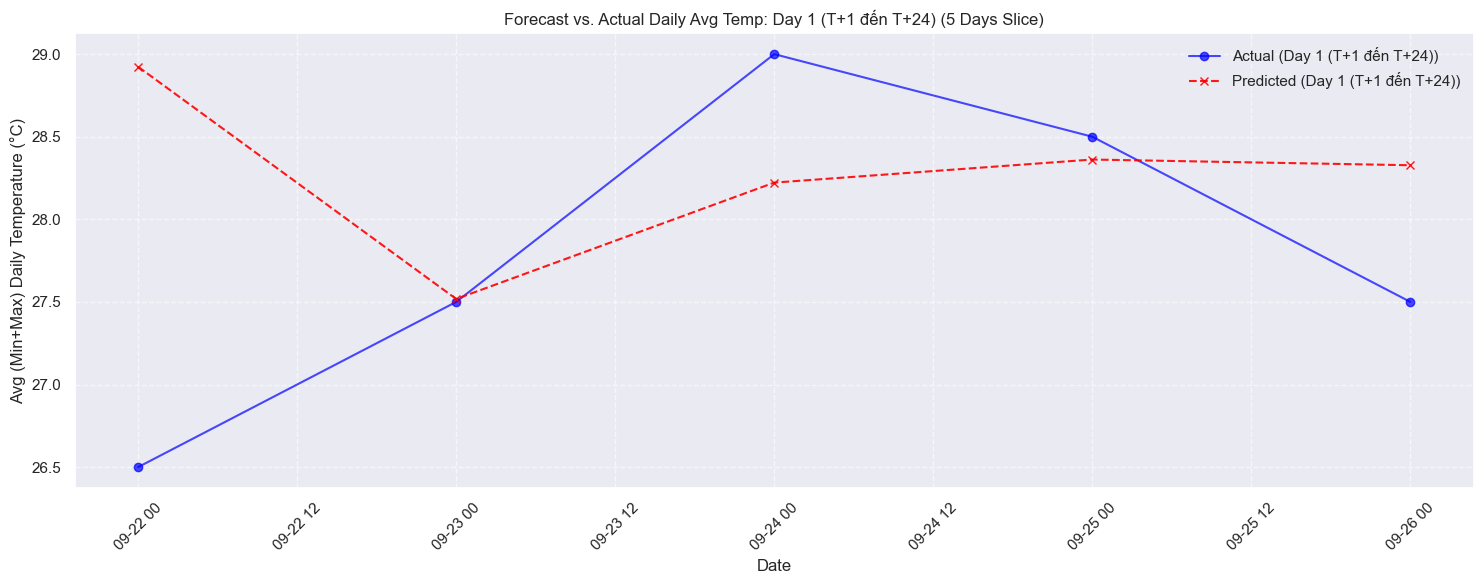

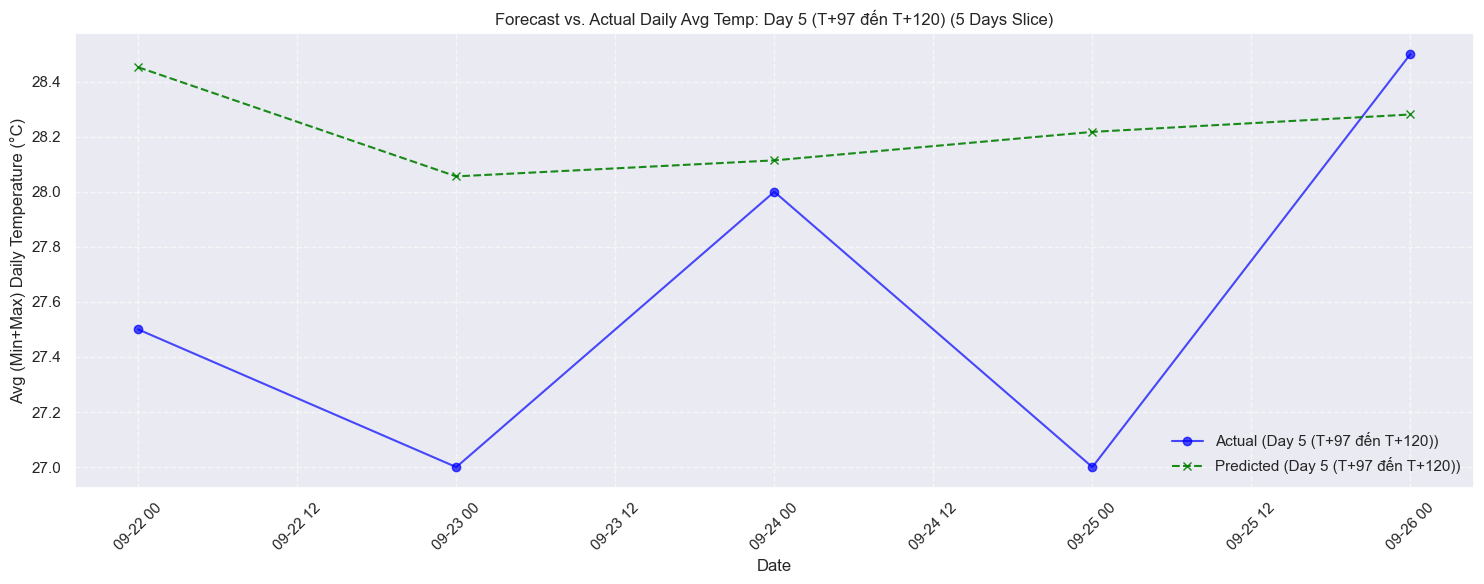

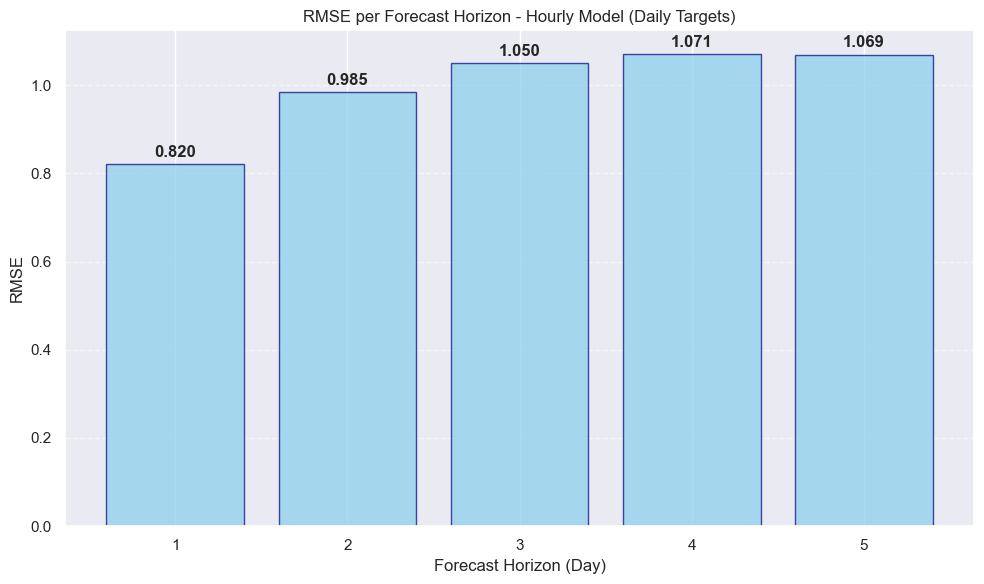

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Cần thiết cho việc xử lý DataFrame/Series

# Lấy dữ liệu từ kết quả mô hình cuối cùng
best_predictions_hourly = model_results_hourly['Final_Combined_Model_Hourly']['predictions_test']
test_metrics_hourly = model_results_hourly['Final_Combined_Model_Hourly']['test_metrics']

# --- CĂN CHỈNH TẦN SUẤT DAILY (Mục tiêu chính) ---
# 1. Xác định phạm vi thời gian (5 ngày cuối cùng)
slice_hours = 5 * 24
slice_idx = max(0, len(test_dates_hourly) - slice_hours)
time_range_hourly = test_dates_hourly.iloc[slice_idx:]

# 2. Tạo mặt nạ Daily: Chọn hàng đầu tiên của mỗi ngày (mỗi 24 hàng)
daily_mask = np.arange(len(time_range_hourly)) % 24 == 0
daily_time = time_range_hourly[daily_mask]

# 3. Lấy số lượng Horizon (Ngày) thực tế mà mô hình dự đoán
n_horiz_model = best_predictions_hourly.shape[1]
horizons_model = list(range(1, n_horiz_model + 1))

print("=== Visualization: Daily Avg Temp Forecast vs. Actual ===")

# --- VẼ ĐỒ THỊ 1: NGÀY ĐẦU TIÊN (Day 1 / Horizon 1) ---
horizon_day_1_idx = 0
horizon_day_1_label = f'Day 1 (T+1 đến T+24)'

# Áp dụng Daily Mask để chỉ lấy một điểm dữ liệu mỗi ngày
actual_daily_h1 = y_test_hourly.iloc[slice_idx:, horizon_day_1_idx].values[daily_mask]
predicted_daily_h1 = best_predictions_hourly[slice_idx:, horizon_day_1_idx][daily_mask]

plt.figure(figsize=(15, 6))
plt.plot(daily_time, actual_daily_h1,
         label=f'Actual ({horizon_day_1_label})', marker='o', linestyle='-', linewidth=1.5, color='blue', alpha=0.7)
plt.plot(daily_time, predicted_daily_h1,
         label=f'Predicted ({horizon_day_1_label})', marker='x', linestyle='--', linewidth=1.5, color='red', alpha=0.9)

plt.title(f'Forecast vs. Actual Daily Avg Temp: {horizon_day_1_label} (5 Days Slice)')
plt.ylabel('Avg (Min+Max) Daily Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- VẼ ĐỒ THỊ 2: NGÀY CUỐI CÙNG (Day N / Horizon N) ---
last_horizon_idx = n_horiz_model - 1
last_horizon_label = f'Day {n_horiz_model} (T+{24*n_horiz_model-23} đến T+{24*n_horiz_model})'

# Áp dụng Daily Mask
actual_daily_last = y_test_hourly.iloc[slice_idx:, last_horizon_idx].values[daily_mask]
predicted_daily_last = best_predictions_hourly[slice_idx:, last_horizon_idx][daily_mask]

plt.figure(figsize=(15, 6))
plt.plot(daily_time, actual_daily_last,
         label=f'Actual ({last_horizon_label})', marker='o', linestyle='-', linewidth=1.5, color='blue', alpha=0.7)
plt.plot(daily_time, predicted_daily_last,
         label=f'Predicted ({last_horizon_label})', marker='x', linestyle='--', linewidth=1.5, color='green', alpha=0.9)

plt.title(f'Forecast vs. Actual Daily Avg Temp: {last_horizon_label} (5 Days Slice)')
plt.ylabel('Avg (Min+Max) Daily Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- VẼ ĐỒ THỊ 3: RMSE THEO HORIZON (NGÀY) ---
rmse_values = [test_metrics_hourly.get(f'RMSE_h{h}', np.nan) for h in horizons_model]

plt.figure(figsize=(10, 6))
bars = plt.bar(horizons_model, rmse_values, alpha=0.7, color='skyblue', edgecolor='navy')
plt.title('RMSE per Forecast Horizon - Hourly Model (Daily Targets)')
plt.xlabel('Forecast Horizon (Day)')
plt.ylabel('RMSE')
plt.grid(True, linestyle='--', alpha=0.6, axis='y')

for i, v in enumerate(rmse_values):
    if np.isnan(v):
        label = 'nan'
    else:
        label = f'{v:.3f}'
    plt.text(horizons_model[i], (0.01 if np.isnan(v) else v) + 0.01, label, ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

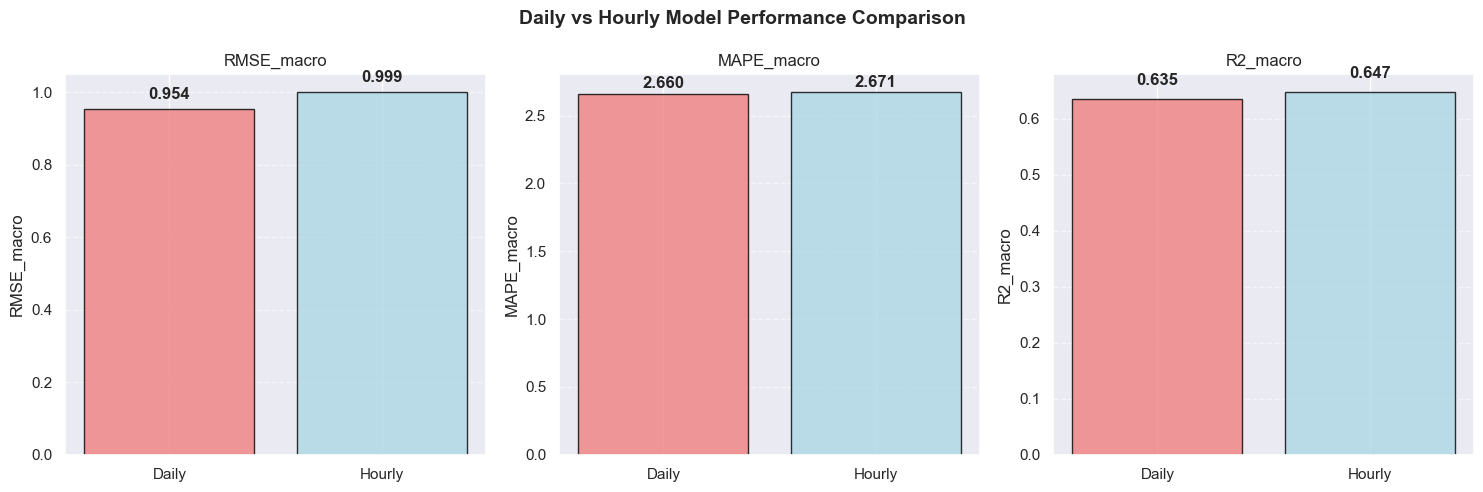

In [61]:
daily_metrics = model_results['Final_Combined_Model']['test_metrics']
hourly_metrics = model_results_hourly['Final_Combined_Model_Hourly']['test_metrics']

daily_rmse = daily_metrics['RMSE_macro']
hourly_rmse = hourly_metrics['RMSE_macro']

daily_mape = daily_metrics['MAPE_macro']
hourly_mape = hourly_metrics['MAPE_macro']

daily_r2 = daily_metrics['R2_macro']
hourly_r2 = hourly_metrics['R2_macro']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['RMSE_macro', 'MAPE_macro', 'R2_macro']
daily_values = [daily_rmse, daily_mape, daily_r2]
hourly_values = [hourly_rmse, hourly_mape, hourly_r2]
colors = ['lightcoral', 'lightblue']

for i, metric in enumerate(metrics):
    ax[i].bar(['Daily', 'Hourly'], [daily_values[i], hourly_values[i]],
              color=colors, alpha=0.8, edgecolor='black')
    ax[i].set_title(metric)
    ax[i].grid(axis='y', linestyle='--', alpha=0.6)
    ax[i].set_ylabel(metric)

    for j, v in enumerate([daily_values[i], hourly_values[i]]):
        ax[i].text(j, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

fig.suptitle('Daily vs Hourly Model Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## <span style='color:blue'> Step 9 · ONNX


In [62]:
from scripts.export_onnx import export_model_to_onnx

